## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1096, 715)
Hypercube shape: (1096, 715, 102)


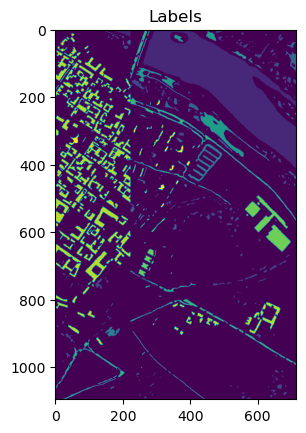

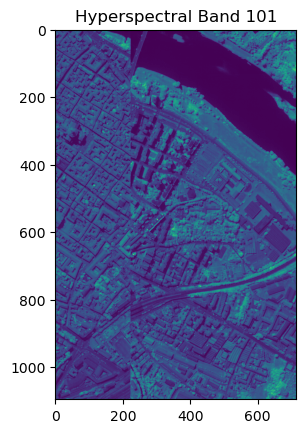

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Pavia_gt.mat'
data_files = 'Pavia.mat'
label_files = 'pavia_gt'
hypercube_files = 'pavia'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 148152
Extracted windows shape: (148152, 5, 5, 102)
Corresponding labels shape: (148152,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 65971 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 7598 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 3090 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 2685 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 6584 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 9248 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 7287 samples
Shuffled class indices for class '7'
Selected 5 training sam


 -- Test set created with: 
	148062 samples
	shape (148062, 5, 5, 102) --




All datasets saved to the 'indices' folder.
(45, 5, 5, 102)
(45, 5, 5, 102)
(148062, 5, 5, 102)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 45
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (118521, 5, 5, 102)
Validation data shape: (29631, 5, 5, 102)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

102


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/1852], Loss: 0.1719, PSNR: 3.2697


	 Training Batch [200/1852], Loss: 0.0935, PSNR: 8.2613


	 Training Batch [400/1852], Loss: 0.0519, PSNR: 9.4024


	 Training Batch [600/1852], Loss: 0.0234, PSNR: 13.0996


	 Training Batch [800/1852], Loss: 0.0177, PSNR: 12.3579


	 Training Batch [1000/1852], Loss: 0.0119, PSNR: 15.4834


	 Training Batch [1200/1852], Loss: 0.0087, PSNR: 16.5891


	 Training Batch [1400/1852], Loss: 0.0078, PSNR: 19.4670


	 Training Batch [1600/1852], Loss: 0.0071, PSNR: 18.3811


	 Training Batch [1800/1852], Loss: 0.0074, PSNR: 18.3586


Epoch [1/50] Training Loss: 0.0325, PSNR: 13.6772
	[Val]   Batch [1/463] Loss: 0.0055, PSNR: 17.8279
	[Val]   Batch [10/463] Loss: 0.0051, PSNR: 19.0033
	[Val]   Batch [20/463] Loss: 0.0051, PSNR: 18.0059
	[Val]   Batch [30/463] Loss: 0.0062, PSNR: 18.5514
	[Val]   Batch [40/463] Loss: 0.0049, PSNR: 17.6879
	[Val]   Batch [50/463] Loss: 0.0052, PSNR: 17.8938


	[Val]   Batch [60/463] Loss: 0.0049, PSNR: 17.9404
	[Val]   Batch [70/463] Loss: 0.0069, PSNR: 18.3029
	[Val]   Batch [80/463] Loss: 0.0062, PSNR: 20.2286
	[Val]   Batch [90/463] Loss: 0.0060, PSNR: 19.3012
	[Val]   Batch [100/463] Loss: 0.0060, PSNR: 19.0278
	[Val]   Batch [110/463] Loss: 0.0070, PSNR: 18.4372
	[Val]   Batch [120/463] Loss: 0.0048, PSNR: 17.9333


	[Val]   Batch [130/463] Loss: 0.0056, PSNR: 19.3284
	[Val]   Batch [140/463] Loss: 0.0066, PSNR: 18.8620
	[Val]   Batch [150/463] Loss: 0.0075, PSNR: 18.9162
	[Val]   Batch [160/463] Loss: 0.0060, PSNR: 19.1467
	[Val]   Batch [170/463] Loss: 0.0077, PSNR: 18.1022
	[Val]   Batch [180/463] Loss: 0.0056, PSNR: 18.8898


	[Val]   Batch [190/463] Loss: 0.0061, PSNR: 19.2393
	[Val]   Batch [200/463] Loss: 0.0061, PSNR: 18.6349
	[Val]   Batch [210/463] Loss: 0.0059, PSNR: 18.1929
	[Val]   Batch [220/463] Loss: 0.0059, PSNR: 19.3952
	[Val]   Batch [230/463] Loss: 0.0069, PSNR: 19.2666
	[Val]   Batch [240/463] Loss: 0.0052, PSNR: 18.0693
	[Val]   Batch [250/463] Loss: 0.0067, PSNR: 17.2295


	[Val]   Batch [260/463] Loss: 0.0059, PSNR: 18.2460
	[Val]   Batch [270/463] Loss: 0.0045, PSNR: 17.4300
	[Val]   Batch [280/463] Loss: 0.0055, PSNR: 20.1308
	[Val]   Batch [290/463] Loss: 0.0061, PSNR: 17.1577
	[Val]   Batch [300/463] Loss: 0.0061, PSNR: 19.4228
	[Val]   Batch [310/463] Loss: 0.0057, PSNR: 19.2786
	[Val]   Batch [320/463] Loss: 0.0057, PSNR: 19.1659


	[Val]   Batch [330/463] Loss: 0.0066, PSNR: 18.5719
	[Val]   Batch [340/463] Loss: 0.0054, PSNR: 19.5041
	[Val]   Batch [350/463] Loss: 0.0071, PSNR: 19.4274
	[Val]   Batch [360/463] Loss: 0.0048, PSNR: 20.3461
	[Val]   Batch [370/463] Loss: 0.0070, PSNR: 18.4947
	[Val]   Batch [380/463] Loss: 0.0069, PSNR: 18.6490
	[Val]   Batch [390/463] Loss: 0.0063, PSNR: 18.4652


	[Val]   Batch [400/463] Loss: 0.0056, PSNR: 17.5036
	[Val]   Batch [410/463] Loss: 0.0054, PSNR: 19.8483
	[Val]   Batch [420/463] Loss: 0.0057, PSNR: 18.6057
	[Val]   Batch [430/463] Loss: 0.0056, PSNR: 18.0064
	[Val]   Batch [440/463] Loss: 0.0054, PSNR: 19.0523
	[Val]   Batch [450/463] Loss: 0.0043, PSNR: 16.3658
	[Val]   Batch [460/463] Loss: 0.0059, PSNR: 17.7695
Epoch [1/50] Validation Loss: 0.0059, PSNR: 18.5934

LOG: Epoch [2/50]
	 Training Batch [1/1852], Loss: 0.0070, PSNR: 19.2140


	 Training Batch [200/1852], Loss: 0.0057, PSNR: 18.9377


	 Training Batch [400/1852], Loss: 0.0055, PSNR: 19.9361


	 Training Batch [600/1852], Loss: 0.0052, PSNR: 18.8960


	 Training Batch [800/1852], Loss: 0.0046, PSNR: 18.8222


	 Training Batch [1000/1852], Loss: 0.0040, PSNR: 20.2390


	 Training Batch [1200/1852], Loss: 0.0044, PSNR: 19.1834


	 Training Batch [1400/1852], Loss: 0.0036, PSNR: 22.2988


	 Training Batch [1600/1852], Loss: 0.0033, PSNR: 21.0132


	 Training Batch [1800/1852], Loss: 0.0031, PSNR: 20.6630


Epoch [2/50] Training Loss: 0.0045, PSNR: 19.9709
	[Val]   Batch [1/463] Loss: 0.0027, PSNR: 20.9677
	[Val]   Batch [10/463] Loss: 0.0025, PSNR: 22.1713
	[Val]   Batch [20/463] Loss: 0.0024, PSNR: 21.2487
	[Val]   Batch [30/463] Loss: 0.0031, PSNR: 21.5624
	[Val]   Batch [40/463] Loss: 0.0024, PSNR: 20.7590
	[Val]   Batch [50/463] Loss: 0.0026, PSNR: 20.9588
	[Val]   Batch [60/463] Loss: 0.0024, PSNR: 21.0383


	[Val]   Batch [70/463] Loss: 0.0035, PSNR: 21.2181
	[Val]   Batch [80/463] Loss: 0.0031, PSNR: 23.1553
	[Val]   Batch [90/463] Loss: 0.0029, PSNR: 22.3768
	[Val]   Batch [100/463] Loss: 0.0031, PSNR: 21.8787
	[Val]   Batch [110/463] Loss: 0.0035, PSNR: 21.3943
	[Val]   Batch [120/463] Loss: 0.0024, PSNR: 20.9934


	[Val]   Batch [130/463] Loss: 0.0027, PSNR: 22.4707
	[Val]   Batch [140/463] Loss: 0.0034, PSNR: 21.7846
	[Val]   Batch [150/463] Loss: 0.0037, PSNR: 21.9858
	[Val]   Batch [160/463] Loss: 0.0032, PSNR: 21.9376
	[Val]   Batch [170/463] Loss: 0.0040, PSNR: 20.9676
	[Val]   Batch [180/463] Loss: 0.0030, PSNR: 21.6353


	[Val]   Batch [190/463] Loss: 0.0030, PSNR: 22.3478
	[Val]   Batch [200/463] Loss: 0.0030, PSNR: 21.6331
	[Val]   Batch [210/463] Loss: 0.0032, PSNR: 20.9236
	[Val]   Batch [220/463] Loss: 0.0030, PSNR: 22.2621
	[Val]   Batch [230/463] Loss: 0.0034, PSNR: 22.3802
	[Val]   Batch [240/463] Loss: 0.0026, PSNR: 21.1234
	[Val]   Batch [250/463] Loss: 0.0035, PSNR: 20.1227


	[Val]   Batch [260/463] Loss: 0.0030, PSNR: 21.1711
	[Val]   Batch [270/463] Loss: 0.0021, PSNR: 20.6489
	[Val]   Batch [280/463] Loss: 0.0027, PSNR: 23.1865
	[Val]   Batch [290/463] Loss: 0.0030, PSNR: 20.2259
	[Val]   Batch [300/463] Loss: 0.0031, PSNR: 22.3948
	[Val]   Batch [310/463] Loss: 0.0030, PSNR: 22.0174
	[Val]   Batch [320/463] Loss: 0.0029, PSNR: 22.0981


	[Val]   Batch [330/463] Loss: 0.0032, PSNR: 21.7057
	[Val]   Batch [340/463] Loss: 0.0027, PSNR: 22.4945
	[Val]   Batch [350/463] Loss: 0.0038, PSNR: 22.1655
	[Val]   Batch [360/463] Loss: 0.0026, PSNR: 23.0466
	[Val]   Batch [370/463] Loss: 0.0035, PSNR: 21.5336


	[Val]   Batch [380/463] Loss: 0.0033, PSNR: 21.8812
	[Val]   Batch [390/463] Loss: 0.0031, PSNR: 21.6124
	[Val]   Batch [400/463] Loss: 0.0029, PSNR: 20.4126
	[Val]   Batch [410/463] Loss: 0.0026, PSNR: 23.0070
	[Val]   Batch [420/463] Loss: 0.0028, PSNR: 21.6981


	[Val]   Batch [430/463] Loss: 0.0029, PSNR: 20.8813
	[Val]   Batch [440/463] Loss: 0.0028, PSNR: 21.9249
	[Val]   Batch [450/463] Loss: 0.0021, PSNR: 19.3573
	[Val]   Batch [460/463] Loss: 0.0029, PSNR: 20.8657
Epoch [2/50] Validation Loss: 0.0029, PSNR: 21.6162

LOG: Epoch [3/50]
	 Training Batch [1/1852], Loss: 0.0021, PSNR: 20.4494


	 Training Batch [200/1852], Loss: 0.0031, PSNR: 22.6336


	 Training Batch [400/1852], Loss: 0.0032, PSNR: 21.8533


	 Training Batch [600/1852], Loss: 0.0026, PSNR: 24.3525


	 Training Batch [800/1852], Loss: 0.0029, PSNR: 22.4287


	 Training Batch [1000/1852], Loss: 0.0023, PSNR: 22.4893


	 Training Batch [1200/1852], Loss: 0.0021, PSNR: 23.0841


	 Training Batch [1400/1852], Loss: 0.0021, PSNR: 22.6794


	 Training Batch [1600/1852], Loss: 0.0019, PSNR: 24.1737


	 Training Batch [1800/1852], Loss: 0.0019, PSNR: 22.9770


Epoch [3/50] Training Loss: 0.0024, PSNR: 22.6188
	[Val]   Batch [1/463] Loss: 0.0016, PSNR: 23.2607
	[Val]   Batch [10/463] Loss: 0.0015, PSNR: 24.4428
	[Val]   Batch [20/463] Loss: 0.0014, PSNR: 23.5782
	[Val]   Batch [30/463] Loss: 0.0017, PSNR: 24.1585
	[Val]   Batch [40/463] Loss: 0.0015, PSNR: 22.7178
	[Val]   Batch [50/463] Loss: 0.0016, PSNR: 23.0504


	[Val]   Batch [60/463] Loss: 0.0015, PSNR: 23.0876
	[Val]   Batch [70/463] Loss: 0.0019, PSNR: 23.8184
	[Val]   Batch [80/463] Loss: 0.0017, PSNR: 25.7866
	[Val]   Batch [90/463] Loss: 0.0017, PSNR: 24.7597
	[Val]   Batch [100/463] Loss: 0.0018, PSNR: 24.3392
	[Val]   Batch [110/463] Loss: 0.0019, PSNR: 24.0627
	[Val]   Batch [120/463] Loss: 0.0015, PSNR: 22.9648


	[Val]   Batch [130/463] Loss: 0.0015, PSNR: 25.0989
	[Val]   Batch [140/463] Loss: 0.0019, PSNR: 24.2559
	[Val]   Batch [150/463] Loss: 0.0019, PSNR: 24.9574
	[Val]   Batch [160/463] Loss: 0.0020, PSNR: 24.0027
	[Val]   Batch [170/463] Loss: 0.0023, PSNR: 23.4053
	[Val]   Batch [180/463] Loss: 0.0018, PSNR: 23.8259


	[Val]   Batch [190/463] Loss: 0.0017, PSNR: 24.8341
	[Val]   Batch [200/463] Loss: 0.0017, PSNR: 24.2320
	[Val]   Batch [210/463] Loss: 0.0020, PSNR: 22.9814
	[Val]   Batch [220/463] Loss: 0.0018, PSNR: 24.4235
	[Val]   Batch [230/463] Loss: 0.0016, PSNR: 25.4931


	[Val]   Batch [240/463] Loss: 0.0015, PSNR: 23.3800
	[Val]   Batch [250/463] Loss: 0.0021, PSNR: 22.3544
	[Val]   Batch [260/463] Loss: 0.0018, PSNR: 23.3641
	[Val]   Batch [270/463] Loss: 0.0014, PSNR: 22.5926
	[Val]   Batch [280/463] Loss: 0.0016, PSNR: 25.4363
	[Val]   Batch [290/463] Loss: 0.0017, PSNR: 22.6103


	[Val]   Batch [300/463] Loss: 0.0018, PSNR: 24.6008
	[Val]   Batch [310/463] Loss: 0.0019, PSNR: 23.9799
	[Val]   Batch [320/463] Loss: 0.0017, PSNR: 24.4217
	[Val]   Batch [330/463] Loss: 0.0017, PSNR: 24.4061
	[Val]   Batch [340/463] Loss: 0.0016, PSNR: 24.7294
	[Val]   Batch [350/463] Loss: 0.0022, PSNR: 24.6211
	[Val]   Batch [360/463] Loss: 0.0018, PSNR: 24.5280


	[Val]   Batch [370/463] Loss: 0.0019, PSNR: 24.2069
	[Val]   Batch [380/463] Loss: 0.0017, PSNR: 24.8389
	[Val]   Batch [390/463] Loss: 0.0016, PSNR: 24.3993
	[Val]   Batch [400/463] Loss: 0.0018, PSNR: 22.4458
	[Val]   Batch [410/463] Loss: 0.0015, PSNR: 25.3650


	[Val]   Batch [420/463] Loss: 0.0016, PSNR: 24.0770
	[Val]   Batch [430/463] Loss: 0.0018, PSNR: 22.8409
	[Val]   Batch [440/463] Loss: 0.0017, PSNR: 24.0742
	[Val]   Batch [450/463] Loss: 0.0015, PSNR: 21.0119
	[Val]   Batch [460/463] Loss: 0.0017, PSNR: 23.1798
Epoch [3/50] Validation Loss: 0.0017, PSNR: 23.9761

LOG: Epoch [4/50]
	 Training Batch [1/1852], Loss: 0.0022, PSNR: 23.2705


	 Training Batch [200/1852], Loss: 0.0019, PSNR: 24.7702


	 Training Batch [400/1852], Loss: 0.0015, PSNR: 22.1468


	 Training Batch [600/1852], Loss: 0.0013, PSNR: 25.2232


	 Training Batch [800/1852], Loss: 0.0017, PSNR: 23.3698


	 Training Batch [1000/1852], Loss: 0.0014, PSNR: 24.5816


	 Training Batch [1200/1852], Loss: 0.0013, PSNR: 23.0389


	 Training Batch [1400/1852], Loss: 0.0015, PSNR: 23.4749


	 Training Batch [1600/1852], Loss: 0.0013, PSNR: 26.3676


	 Training Batch [1800/1852], Loss: 0.0013, PSNR: 23.1815


Epoch [4/50] Training Loss: 0.0016, PSNR: 24.2701
	[Val]   Batch [1/463] Loss: 0.0012, PSNR: 24.6104
	[Val]   Batch [10/463] Loss: 0.0011, PSNR: 25.8870
	[Val]   Batch [20/463] Loss: 0.0010, PSNR: 25.0857
	[Val]   Batch [30/463] Loss: 0.0012, PSNR: 25.5781
	[Val]   Batch [40/463] Loss: 0.0011, PSNR: 24.0678


	[Val]   Batch [50/463] Loss: 0.0011, PSNR: 24.4710
	[Val]   Batch [60/463] Loss: 0.0011, PSNR: 24.4617
	[Val]   Batch [70/463] Loss: 0.0014, PSNR: 25.2402
	[Val]   Batch [80/463] Loss: 0.0012, PSNR: 27.3990
	[Val]   Batch [90/463] Loss: 0.0012, PSNR: 26.2278
	[Val]   Batch [100/463] Loss: 0.0013, PSNR: 25.7143


	[Val]   Batch [110/463] Loss: 0.0013, PSNR: 25.5845
	[Val]   Batch [120/463] Loss: 0.0011, PSNR: 24.3771
	[Val]   Batch [130/463] Loss: 0.0011, PSNR: 26.5980
	[Val]   Batch [140/463] Loss: 0.0014, PSNR: 25.7242
	[Val]   Batch [150/463] Loss: 0.0013, PSNR: 26.5152
	[Val]   Batch [160/463] Loss: 0.0015, PSNR: 25.3128


	[Val]   Batch [170/463] Loss: 0.0017, PSNR: 24.6872
	[Val]   Batch [180/463] Loss: 0.0013, PSNR: 25.1683
	[Val]   Batch [190/463] Loss: 0.0012, PSNR: 26.2647
	[Val]   Batch [200/463] Loss: 0.0011, PSNR: 25.8552
	[Val]   Batch [210/463] Loss: 0.0015, PSNR: 24.2751
	[Val]   Batch [220/463] Loss: 0.0014, PSNR: 25.7577
	[Val]   Batch [230/463] Loss: 0.0011, PSNR: 27.1372


	[Val]   Batch [240/463] Loss: 0.0011, PSNR: 24.8057
	[Val]   Batch [250/463] Loss: 0.0015, PSNR: 23.6763
	[Val]   Batch [260/463] Loss: 0.0013, PSNR: 24.6309
	[Val]   Batch [270/463] Loss: 0.0010, PSNR: 24.1231
	[Val]   Batch [280/463] Loss: 0.0012, PSNR: 26.8449
	[Val]   Batch [290/463] Loss: 0.0012, PSNR: 24.0454
	[Val]   Batch [300/463] Loss: 0.0013, PSNR: 25.9576


	[Val]   Batch [310/463] Loss: 0.0014, PSNR: 25.3383
	[Val]   Batch [320/463] Loss: 0.0012, PSNR: 25.9035
	[Val]   Batch [330/463] Loss: 0.0012, PSNR: 25.9437
	[Val]   Batch [340/463] Loss: 0.0012, PSNR: 26.1626
	[Val]   Batch [350/463] Loss: 0.0016, PSNR: 25.9714
	[Val]   Batch [360/463] Loss: 0.0014, PSNR: 25.6288


	[Val]   Batch [370/463] Loss: 0.0013, PSNR: 25.6896
	[Val]   Batch [380/463] Loss: 0.0011, PSNR: 26.4942
	[Val]   Batch [390/463] Loss: 0.0011, PSNR: 25.9794
	[Val]   Batch [400/463] Loss: 0.0014, PSNR: 23.6682
	[Val]   Batch [410/463] Loss: 0.0011, PSNR: 26.8263
	[Val]   Batch [420/463] Loss: 0.0012, PSNR: 25.5231
	[Val]   Batch [430/463] Loss: 0.0014, PSNR: 24.0777


	[Val]   Batch [440/463] Loss: 0.0013, PSNR: 25.4151
	[Val]   Batch [450/463] Loss: 0.0011, PSNR: 22.4068
	[Val]   Batch [460/463] Loss: 0.0012, PSNR: 24.5990
Epoch [4/50] Validation Loss: 0.0012, PSNR: 25.4187

LOG: Epoch [5/50]
	 Training Batch [1/1852], Loss: 0.0015, PSNR: 25.9500


	 Training Batch [200/1852], Loss: 0.0012, PSNR: 25.9469


	 Training Batch [400/1852], Loss: 0.0012, PSNR: 24.4679


	 Training Batch [600/1852], Loss: 0.0013, PSNR: 25.5865


	 Training Batch [800/1852], Loss: 0.0013, PSNR: 24.8894


	 Training Batch [1000/1852], Loss: 0.0012, PSNR: 24.9080


	 Training Batch [1200/1852], Loss: 0.0013, PSNR: 26.7838


	 Training Batch [1400/1852], Loss: 0.0014, PSNR: 26.3627


	 Training Batch [1600/1852], Loss: 0.0010, PSNR: 24.6349


	 Training Batch [1800/1852], Loss: 0.0013, PSNR: 25.6250


Epoch [5/50] Training Loss: 0.0013, PSNR: 25.3394
	[Val]   Batch [1/463] Loss: 0.0009, PSNR: 25.7743
	[Val]   Batch [10/463] Loss: 0.0008, PSNR: 27.1232
	[Val]   Batch [20/463] Loss: 0.0008, PSNR: 26.3661
	[Val]   Batch [30/463] Loss: 0.0010, PSNR: 26.7018
	[Val]   Batch [40/463] Loss: 0.0009, PSNR: 25.1505
	[Val]   Batch [50/463] Loss: 0.0009, PSNR: 25.6891
	[Val]   Batch [60/463] Loss: 0.0008, PSNR: 25.6154


	[Val]   Batch [70/463] Loss: 0.0011, PSNR: 26.3599
	[Val]   Batch [80/463] Loss: 0.0009, PSNR: 28.7302
	[Val]   Batch [90/463] Loss: 0.0009, PSNR: 27.4347
	[Val]   Batch [100/463] Loss: 0.0010, PSNR: 26.9377
	[Val]   Batch [110/463] Loss: 0.0010, PSNR: 26.8310
	[Val]   Batch [120/463] Loss: 0.0008, PSNR: 25.6339
	[Val]   Batch [130/463] Loss: 0.0008, PSNR: 27.7811


	[Val]   Batch [140/463] Loss: 0.0010, PSNR: 26.8878
	[Val]   Batch [150/463] Loss: 0.0010, PSNR: 27.7285
	[Val]   Batch [160/463] Loss: 0.0011, PSNR: 26.3649
	[Val]   Batch [170/463] Loss: 0.0013, PSNR: 25.6918
	[Val]   Batch [180/463] Loss: 0.0010, PSNR: 26.3243
	[Val]   Batch [190/463] Loss: 0.0009, PSNR: 27.4364
	[Val]   Batch [200/463] Loss: 0.0008, PSNR: 27.1668


	[Val]   Batch [210/463] Loss: 0.0011, PSNR: 25.3495
	[Val]   Batch [220/463] Loss: 0.0011, PSNR: 26.8625
	[Val]   Batch [230/463] Loss: 0.0008, PSNR: 28.4106
	[Val]   Batch [240/463] Loss: 0.0008, PSNR: 26.0181
	[Val]   Batch [250/463] Loss: 0.0012, PSNR: 24.7319
	[Val]   Batch [260/463] Loss: 0.0011, PSNR: 25.6493


	[Val]   Batch [270/463] Loss: 0.0007, PSNR: 25.4711
	[Val]   Batch [280/463] Loss: 0.0009, PSNR: 28.0346
	[Val]   Batch [290/463] Loss: 0.0009, PSNR: 25.2345
	[Val]   Batch [300/463] Loss: 0.0011, PSNR: 26.9647
	[Val]   Batch [310/463] Loss: 0.0011, PSNR: 26.5237
	[Val]   Batch [320/463] Loss: 0.0009, PSNR: 27.1822
	[Val]   Batch [330/463] Loss: 0.0009, PSNR: 27.1576


	[Val]   Batch [340/463] Loss: 0.0009, PSNR: 27.4086
	[Val]   Batch [350/463] Loss: 0.0012, PSNR: 27.0258
	[Val]   Batch [360/463] Loss: 0.0012, PSNR: 26.5241
	[Val]   Batch [370/463] Loss: 0.0010, PSNR: 26.8612
	[Val]   Batch [380/463] Loss: 0.0008, PSNR: 27.8185
	[Val]   Batch [390/463] Loss: 0.0008, PSNR: 27.2528
	[Val]   Batch [400/463] Loss: 0.0010, PSNR: 24.7723


	[Val]   Batch [410/463] Loss: 0.0008, PSNR: 28.0691
	[Val]   Batch [420/463] Loss: 0.0009, PSNR: 26.6786
	[Val]   Batch [430/463] Loss: 0.0011, PSNR: 25.1371
	[Val]   Batch [440/463] Loss: 0.0010, PSNR: 26.5436
	[Val]   Batch [450/463] Loss: 0.0008, PSNR: 23.6340
	[Val]   Batch [460/463] Loss: 0.0010, PSNR: 25.6969
Epoch [5/50] Validation Loss: 0.0009, PSNR: 26.6174

LOG: Epoch [6/50]
	 Training Batch [1/1852], Loss: 0.0012, PSNR: 26.4161


	 Training Batch [200/1852], Loss: 0.0010, PSNR: 27.6502


	 Training Batch [400/1852], Loss: 0.0010, PSNR: 24.5886


	 Training Batch [600/1852], Loss: 0.0010, PSNR: 26.1387


	 Training Batch [800/1852], Loss: 0.0009, PSNR: 26.8815


	 Training Batch [1000/1852], Loss: 0.0010, PSNR: 25.6858


	 Training Batch [1200/1852], Loss: 0.0011, PSNR: 23.5664


	 Training Batch [1400/1852], Loss: 0.0009, PSNR: 26.7844


	 Training Batch [1600/1852], Loss: 0.0009, PSNR: 26.7648


	 Training Batch [1800/1852], Loss: 0.0009, PSNR: 27.6335


Epoch [6/50] Training Loss: 0.0010, PSNR: 26.1776
	[Val]   Batch [1/463] Loss: 0.0007, PSNR: 26.5800
	[Val]   Batch [10/463] Loss: 0.0006, PSNR: 28.0068
	[Val]   Batch [20/463] Loss: 0.0006, PSNR: 27.2348
	[Val]   Batch [30/463] Loss: 0.0008, PSNR: 27.5551
	[Val]   Batch [40/463] Loss: 0.0007, PSNR: 25.9625
	[Val]   Batch [50/463] Loss: 0.0007, PSNR: 26.5086


	[Val]   Batch [60/463] Loss: 0.0007, PSNR: 26.3874
	[Val]   Batch [70/463] Loss: 0.0009, PSNR: 27.1984
	[Val]   Batch [80/463] Loss: 0.0007, PSNR: 29.7843
	[Val]   Batch [90/463] Loss: 0.0007, PSNR: 28.3384
	[Val]   Batch [100/463] Loss: 0.0008, PSNR: 27.8401
	[Val]   Batch [110/463] Loss: 0.0008, PSNR: 27.7441


	[Val]   Batch [120/463] Loss: 0.0007, PSNR: 26.4880
	[Val]   Batch [130/463] Loss: 0.0007, PSNR: 28.6048
	[Val]   Batch [140/463] Loss: 0.0008, PSNR: 27.7696
	[Val]   Batch [150/463] Loss: 0.0008, PSNR: 28.6162
	[Val]   Batch [160/463] Loss: 0.0010, PSNR: 27.1425
	[Val]   Batch [170/463] Loss: 0.0011, PSNR: 26.4975
	[Val]   Batch [180/463] Loss: 0.0008, PSNR: 27.2622


	[Val]   Batch [190/463] Loss: 0.0008, PSNR: 28.2831
	[Val]   Batch [200/463] Loss: 0.0007, PSNR: 28.1207
	[Val]   Batch [210/463] Loss: 0.0009, PSNR: 26.1711
	[Val]   Batch [220/463] Loss: 0.0009, PSNR: 27.6998
	[Val]   Batch [230/463] Loss: 0.0007, PSNR: 29.3254
	[Val]   Batch [240/463] Loss: 0.0007, PSNR: 26.9034


	[Val]   Batch [250/463] Loss: 0.0010, PSNR: 25.5428
	[Val]   Batch [260/463] Loss: 0.0009, PSNR: 26.3848
	[Val]   Batch [270/463] Loss: 0.0006, PSNR: 26.4313
	[Val]   Batch [280/463] Loss: 0.0007, PSNR: 28.8909
	[Val]   Batch [290/463] Loss: 0.0008, PSNR: 26.1082
	[Val]   Batch [300/463] Loss: 0.0009, PSNR: 27.6789


	[Val]   Batch [310/463] Loss: 0.0009, PSNR: 27.3918
	[Val]   Batch [320/463] Loss: 0.0007, PSNR: 28.1220
	[Val]   Batch [330/463] Loss: 0.0007, PSNR: 28.0668
	[Val]   Batch [340/463] Loss: 0.0007, PSNR: 28.2902
	[Val]   Batch [350/463] Loss: 0.0010, PSNR: 27.8646


	[Val]   Batch [360/463] Loss: 0.0010, PSNR: 27.1639
	[Val]   Batch [370/463] Loss: 0.0008, PSNR: 27.7695
	[Val]   Batch [380/463] Loss: 0.0007, PSNR: 28.7722
	[Val]   Batch [390/463] Loss: 0.0007, PSNR: 28.1822
	[Val]   Batch [400/463] Loss: 0.0009, PSNR: 25.5933
	[Val]   Batch [410/463] Loss: 0.0007, PSNR: 28.8982


	[Val]   Batch [420/463] Loss: 0.0007, PSNR: 27.5317
	[Val]   Batch [430/463] Loss: 0.0009, PSNR: 25.9446
	[Val]   Batch [440/463] Loss: 0.0008, PSNR: 27.3738
	[Val]   Batch [450/463] Loss: 0.0007, PSNR: 24.4914
	[Val]   Batch [460/463] Loss: 0.0008, PSNR: 26.4997
Epoch [6/50] Validation Loss: 0.0008, PSNR: 27.4835

LOG: Epoch [7/50]
	 Training Batch [1/1852], Loss: 0.0008, PSNR: 26.0413


	 Training Batch [200/1852], Loss: 0.0008, PSNR: 24.7595


	 Training Batch [400/1852], Loss: 0.0009, PSNR: 27.2862


	 Training Batch [600/1852], Loss: 0.0008, PSNR: 27.4618


	 Training Batch [800/1852], Loss: 0.0008, PSNR: 27.6608


	 Training Batch [1000/1852], Loss: 0.0007, PSNR: 27.2660


	 Training Batch [1200/1852], Loss: 0.0008, PSNR: 27.7647


	 Training Batch [1400/1852], Loss: 0.0009, PSNR: 27.7095


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 27.5567


	 Training Batch [1800/1852], Loss: 0.0008, PSNR: 26.8888


Epoch [7/50] Training Loss: 0.0009, PSNR: 26.8891
	[Val]   Batch [1/463] Loss: 0.0006, PSNR: 27.3971
	[Val]   Batch [10/463] Loss: 0.0005, PSNR: 28.9368
	[Val]   Batch [20/463] Loss: 0.0005, PSNR: 28.2215
	[Val]   Batch [30/463] Loss: 0.0006, PSNR: 28.4550
	[Val]   Batch [40/463] Loss: 0.0006, PSNR: 26.8547
	[Val]   Batch [50/463] Loss: 0.0006, PSNR: 27.4465


	[Val]   Batch [60/463] Loss: 0.0006, PSNR: 27.1942
	[Val]   Batch [70/463] Loss: 0.0007, PSNR: 28.0618
	[Val]   Batch [80/463] Loss: 0.0005, PSNR: 30.8022
	[Val]   Batch [90/463] Loss: 0.0006, PSNR: 29.2751
	[Val]   Batch [100/463] Loss: 0.0006, PSNR: 28.7528
	[Val]   Batch [110/463] Loss: 0.0007, PSNR: 28.6828
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 27.3740


	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 29.5053
	[Val]   Batch [140/463] Loss: 0.0007, PSNR: 28.6960
	[Val]   Batch [150/463] Loss: 0.0006, PSNR: 29.6198
	[Val]   Batch [160/463] Loss: 0.0008, PSNR: 27.9614
	[Val]   Batch [170/463] Loss: 0.0009, PSNR: 27.3347


	[Val]   Batch [180/463] Loss: 0.0007, PSNR: 28.2188
	[Val]   Batch [190/463] Loss: 0.0006, PSNR: 29.1458
	[Val]   Batch [200/463] Loss: 0.0005, PSNR: 29.0776
	[Val]   Batch [210/463] Loss: 0.0008, PSNR: 27.0371
	[Val]   Batch [220/463] Loss: 0.0007, PSNR: 28.5364
	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 30.2845


	[Val]   Batch [240/463] Loss: 0.0006, PSNR: 27.8114
	[Val]   Batch [250/463] Loss: 0.0008, PSNR: 26.4295
	[Val]   Batch [260/463] Loss: 0.0007, PSNR: 27.2593
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 27.4364
	[Val]   Batch [280/463] Loss: 0.0006, PSNR: 29.7788
	[Val]   Batch [290/463] Loss: 0.0006, PSNR: 27.0500


	[Val]   Batch [300/463] Loss: 0.0008, PSNR: 28.4883
	[Val]   Batch [310/463] Loss: 0.0007, PSNR: 28.2337
	[Val]   Batch [320/463] Loss: 0.0006, PSNR: 29.0627
	[Val]   Batch [330/463] Loss: 0.0006, PSNR: 29.0298
	[Val]   Batch [340/463] Loss: 0.0006, PSNR: 29.2453
	[Val]   Batch [350/463] Loss: 0.0008, PSNR: 28.7430


	[Val]   Batch [360/463] Loss: 0.0009, PSNR: 27.7694
	[Val]   Batch [370/463] Loss: 0.0007, PSNR: 28.7460
	[Val]   Batch [380/463] Loss: 0.0005, PSNR: 29.8520
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.1711
	[Val]   Batch [400/463] Loss: 0.0007, PSNR: 26.4210
	[Val]   Batch [410/463] Loss: 0.0006, PSNR: 29.7655
	[Val]   Batch [420/463] Loss: 0.0006, PSNR: 28.4535


	[Val]   Batch [430/463] Loss: 0.0007, PSNR: 26.7438
	[Val]   Batch [440/463] Loss: 0.0007, PSNR: 28.2144
	[Val]   Batch [450/463] Loss: 0.0005, PSNR: 25.4120
	[Val]   Batch [460/463] Loss: 0.0006, PSNR: 27.3850
Epoch [7/50] Validation Loss: 0.0006, PSNR: 28.4015

LOG: Epoch [8/50]
	 Training Batch [1/1852], Loss: 0.0008, PSNR: 27.2517


	 Training Batch [200/1852], Loss: 0.0008, PSNR: 28.0851


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 27.4198


	 Training Batch [600/1852], Loss: 0.0009, PSNR: 25.4788


	 Training Batch [800/1852], Loss: 0.0008, PSNR: 26.7608


	 Training Batch [1000/1852], Loss: 0.0007, PSNR: 27.2475


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 28.2725


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 27.3781


	 Training Batch [1600/1852], Loss: 0.0008, PSNR: 26.2430


	 Training Batch [1800/1852], Loss: 0.0008, PSNR: 26.5843


Epoch [8/50] Training Loss: 0.0008, PSNR: 27.4795
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.0854
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 29.6653
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 28.8618
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.1483
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 27.5196
	[Val]   Batch [50/463] Loss: 0.0005, PSNR: 28.2674
	[Val]   Batch [60/463] Loss: 0.0005, PSNR: 27.8663


	[Val]   Batch [70/463] Loss: 0.0006, PSNR: 28.7376
	[Val]   Batch [80/463] Loss: 0.0005, PSNR: 31.5537
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 30.0068
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 29.5072
	[Val]   Batch [110/463] Loss: 0.0006, PSNR: 29.3855
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 28.1083


	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 30.1393
	[Val]   Batch [140/463] Loss: 0.0006, PSNR: 29.3227
	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 30.3259
	[Val]   Batch [160/463] Loss: 0.0007, PSNR: 28.6423
	[Val]   Batch [170/463] Loss: 0.0008, PSNR: 28.0412
	[Val]   Batch [180/463] Loss: 0.0006, PSNR: 28.9071
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 29.7488


	[Val]   Batch [200/463] Loss: 0.0005, PSNR: 29.8138
	[Val]   Batch [210/463] Loss: 0.0007, PSNR: 27.7610
	[Val]   Batch [220/463] Loss: 0.0006, PSNR: 29.1513
	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 30.9603
	[Val]   Batch [240/463] Loss: 0.0005, PSNR: 28.5327
	[Val]   Batch [250/463] Loss: 0.0007, PSNR: 27.2113


	[Val]   Batch [260/463] Loss: 0.0006, PSNR: 27.9574
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 28.1564
	[Val]   Batch [280/463] Loss: 0.0005, PSNR: 30.4674
	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 27.7844
	[Val]   Batch [300/463] Loss: 0.0007, PSNR: 28.9995
	[Val]   Batch [310/463] Loss: 0.0006, PSNR: 28.9371
	[Val]   Batch [320/463] Loss: 0.0005, PSNR: 29.9209


	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 29.7047
	[Val]   Batch [340/463] Loss: 0.0005, PSNR: 29.9144
	[Val]   Batch [350/463] Loss: 0.0007, PSNR: 29.3755
	[Val]   Batch [360/463] Loss: 0.0008, PSNR: 28.2237
	[Val]   Batch [370/463] Loss: 0.0006, PSNR: 29.4200
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 30.5958
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.8406


	[Val]   Batch [400/463] Loss: 0.0006, PSNR: 27.0606
	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 30.4503
	[Val]   Batch [420/463] Loss: 0.0005, PSNR: 29.1564
	[Val]   Batch [430/463] Loss: 0.0006, PSNR: 27.4940
	[Val]   Batch [440/463] Loss: 0.0006, PSNR: 28.8226
	[Val]   Batch [450/463] Loss: 0.0005, PSNR: 26.0985


	[Val]   Batch [460/463] Loss: 0.0006, PSNR: 28.0838
Epoch [8/50] Validation Loss: 0.0005, PSNR: 29.1016

LOG: Epoch [9/50]
	 Training Batch [1/1852], Loss: 0.0007, PSNR: 28.7811


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 28.0772


	 Training Batch [400/1852], Loss: 0.0008, PSNR: 27.3384


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 25.7461


	 Training Batch [800/1852], Loss: 0.0008, PSNR: 27.3614


	 Training Batch [1000/1852], Loss: 0.0008, PSNR: 27.9655


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 28.4718


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 28.1436


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 28.6029


	 Training Batch [1800/1852], Loss: 0.0007, PSNR: 27.4021


Epoch [9/50] Training Loss: 0.0007, PSNR: 27.9882
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.5552
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 30.2519
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 29.4534
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.6505
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 28.0225
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 28.8888
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.4210


	[Val]   Batch [70/463] Loss: 0.0006, PSNR: 29.2847
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 32.1665
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 30.5280
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 30.1204
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 29.9974
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.6459
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 30.6042


	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 29.8261
	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 30.9230
	[Val]   Batch [160/463] Loss: 0.0006, PSNR: 29.2254
	[Val]   Batch [170/463] Loss: 0.0007, PSNR: 28.5852
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.4648
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 30.2864


	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.3889
	[Val]   Batch [210/463] Loss: 0.0006, PSNR: 28.3668
	[Val]   Batch [220/463] Loss: 0.0006, PSNR: 29.6695
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.4405
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.1224
	[Val]   Batch [250/463] Loss: 0.0006, PSNR: 27.7935
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 28.5996
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 28.7721


	[Val]   Batch [280/463] Loss: 0.0005, PSNR: 30.9929
	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 28.3030
	[Val]   Batch [300/463] Loss: 0.0006, PSNR: 29.5158
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 29.5440
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.5025
	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 30.2385
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 30.5222


	[Val]   Batch [350/463] Loss: 0.0006, PSNR: 29.9503
	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.6164
	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 29.9226
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 31.1427
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.3610
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 27.5780
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 30.9542
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 29.6941


	[Val]   Batch [430/463] Loss: 0.0006, PSNR: 28.0392
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.3627
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.6834
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.6505
Epoch [9/50] Validation Loss: 0.0005, PSNR: 29.6611

LOG: Epoch [10/50]
	 Training Batch [1/1852], Loss: 0.0008, PSNR: 26.8034


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 27.6182


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 27.6578


	 Training Batch [600/1852], Loss: 0.0007, PSNR: 26.3970


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 28.0365


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 28.3938


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 29.6705


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 28.7856


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 29.9366


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 29.4389


Epoch [10/50] Training Loss: 0.0006, PSNR: 28.4832
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.1972
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 30.9233
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.0883
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.3860
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.6652
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 29.5304
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 29.0203


	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 30.0597
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 32.9273
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 31.2560
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.8427
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 30.7332
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 29.2434
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 31.3060
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 30.5299


	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.7946
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 29.9465
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 29.3193
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.1806
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 30.9427
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.0786
	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 29.1711


	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 30.2967
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.2435
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 29.8440
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.5118
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 29.3098
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.4687
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.6778


	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 29.1452
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.0186
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 30.2055
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 31.2002
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 31.0108
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 31.2381
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 30.7528


	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 29.0120
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 30.7529
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 31.9304
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.1350
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 28.2211
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.5781
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.4043


	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.6840
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 29.9259
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.3354
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.3774
Epoch [10/50] Validation Loss: 0.0004, PSNR: 30.3642

LOG: Epoch [11/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 28.1590


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 29.6692


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 28.3720


	 Training Batch [600/1852], Loss: 0.0007, PSNR: 27.8819


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 29.0324


	 Training Batch [1000/1852], Loss: 0.0007, PSNR: 30.0204


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 27.5286


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 29.0991


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 30.3733


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 28.1174


Epoch [11/50] Training Loss: 0.0006, PSNR: 28.8232
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.5817
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.3765
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.4942
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.7638
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 29.0527
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.0342
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.5090


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.5266
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.4095
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 31.6399
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 31.2621
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 31.2218
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.6165
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.7722
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 30.9843


	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.3556
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 30.4089
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 29.7933
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.5474
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.3264
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.5165
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 29.6953
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.6664


	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.6495
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.2898
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.0185
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 29.8332
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.9131
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.1056
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 29.6003
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.4695
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.6449


	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.5919
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.4456
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.6710
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 31.2174
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.2666
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.1479
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.4276


	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.5747
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.6298
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 31.9395
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 30.8061
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.1292
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.3539
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.8191
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.9101
Epoch [11/50] Validation Loss: 0.0004, PSNR: 30.8046

LOG: Epoch [12/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 29.7993


	 Training Batch [200/1852], Loss: 0.0004, PSNR: 28.8159


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 30.0935


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 28.5187


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 28.7233


	 Training Batch [1000/1852], Loss: 0.0007, PSNR: 28.1663


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 28.8962


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 28.4292


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 28.1415


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 29.1960


Epoch [12/50] Training Loss: 0.0005, PSNR: 29.1481
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.6797
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.4982
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.5991
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.8188
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.2642
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.2771


	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.6898
	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.6141
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.4390
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 31.7246
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 31.3387
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 31.2371
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.7884


	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.8334
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 30.9917
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.4619
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.7347
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 29.9270
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.6948
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.3078
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.6450


	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 29.9061
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.7642
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.5147
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.4505
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.1770
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 30.1125
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.0154


	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.1421
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 29.6368
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.5871
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.8241
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.7485
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.4914
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.7539


	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 31.2625
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.3873
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.2176
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.5038
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.5505
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.7382


	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 31.9426
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 30.9296
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.3294
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.3642
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.9476
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 30.0139
Epoch [12/50] Validation Loss: 0.0003, PSNR: 30.9161

LOG: Epoch [13/50]
	 Training Batch [1/1852], Loss: 0.0004, PSNR: 30.3177


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 27.8350


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 28.3079


	 Training Batch [600/1852], Loss: 0.0004, PSNR: 28.2805


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 28.4563


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 28.9581


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 28.4757


	 Training Batch [1400/1852], Loss: 0.0004, PSNR: 29.6066


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 29.4870


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 28.5121


Epoch [13/50] Training Loss: 0.0005, PSNR: 29.4296
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 29.9299
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.8709
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.9544
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.1752
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.5395
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.6679
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.0957


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.9739
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.7914
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.0612
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.6715
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.6373
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.0515
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.1416


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.3373
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.8594
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 31.1137
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 30.2799
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.0346
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.6734


	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.9543
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 30.2418
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.0085
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.9130
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.8504
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.5549
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 30.5934
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.3753


	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.4539
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.0045
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 30.9466
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 31.1540
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.0159
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.8397
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.1373


	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.5909
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.5859
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.5792
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.9109
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.8697
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.0822
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.3308


	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.2831
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.6408
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.6997
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.1765
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.4383
Epoch [13/50] Validation Loss: 0.0003, PSNR: 31.2608

LOG: Epoch [14/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 28.9531


	 Training Batch [200/1852], Loss: 0.0004, PSNR: 28.5768


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 29.6058


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 28.4189


	 Training Batch [800/1852], Loss: 0.0004, PSNR: 29.7768


	 Training Batch [1000/1852], Loss: 0.0004, PSNR: 29.1965


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 30.1998


	 Training Batch [1400/1852], Loss: 0.0004, PSNR: 31.5373


	 Training Batch [1600/1852], Loss: 0.0004, PSNR: 30.4585


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 29.9344


Epoch [14/50] Training Loss: 0.0005, PSNR: 29.6872
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.4412
	[Val]   Batch [10/463] Loss: 0.0002, PSNR: 32.3830
	[Val]   Batch [20/463] Loss: 0.0002, PSNR: 31.4164
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.7085
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 30.0027
	[Val]   Batch [50/463] Loss: 0.0002, PSNR: 31.1644
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.5793


	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.6335
	[Val]   Batch [80/463] Loss: 0.0002, PSNR: 34.3747
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.6103
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 32.2136
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 32.2398
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.4988
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.7215


	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 31.9323
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.5160
	[Val]   Batch [160/463] Loss: 0.0003, PSNR: 31.6828
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.8452
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.5474
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 32.1798


	[Val]   Batch [200/463] Loss: 0.0002, PSNR: 32.5105
	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 30.8349
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.5395
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.5865
	[Val]   Batch [240/463] Loss: 0.0002, PSNR: 31.3641
	[Val]   Batch [250/463] Loss: 0.0003, PSNR: 30.0799
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 31.1338


	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.9376
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 33.0000
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.6005
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.2902
	[Val]   Batch [310/463] Loss: 0.0003, PSNR: 31.6445
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.5681
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.3686


	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.6567
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 32.2435
	[Val]   Batch [360/463] Loss: 0.0005, PSNR: 29.8379
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 32.1341
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.5086
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.4340
	[Val]   Batch [400/463] Loss: 0.0003, PSNR: 29.5525


	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.7271
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.7713
	[Val]   Batch [430/463] Loss: 0.0003, PSNR: 30.1320
	[Val]   Batch [440/463] Loss: 0.0003, PSNR: 31.1875
	[Val]   Batch [450/463] Loss: 0.0002, PSNR: 28.7905
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.9786
Epoch [14/50] Validation Loss: 0.0003, PSNR: 31.8040
Early stopping triggered at epoch 14. No improvement for 3 epochs.


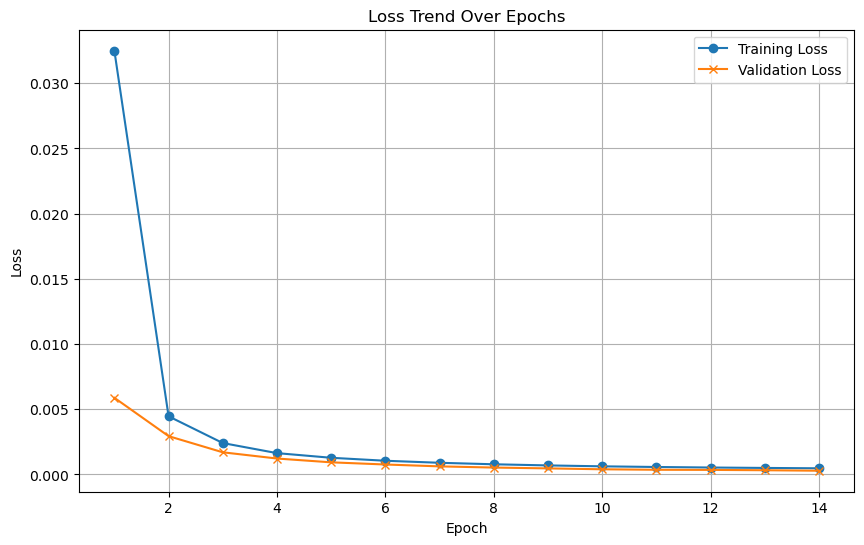

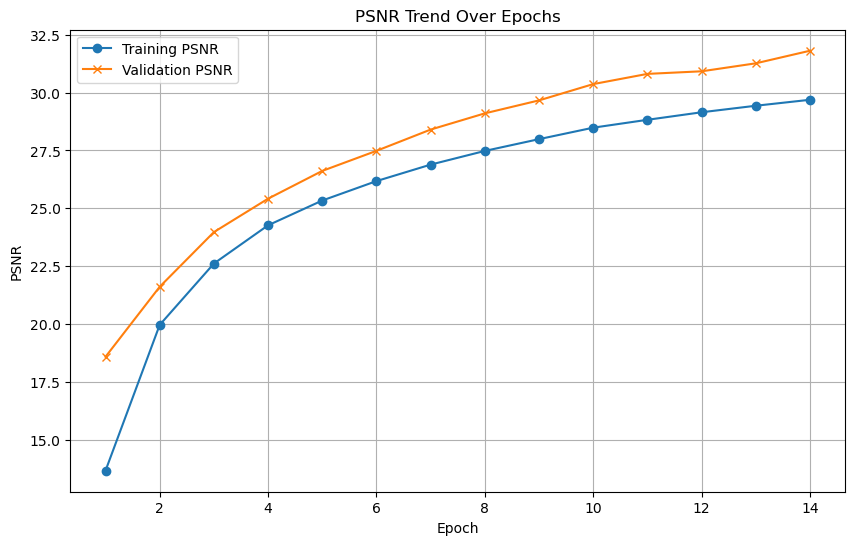

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/579 for test dataset.


    Processed batch 101/579 for test dataset.


    Processed batch 201/579 for test dataset.


    Processed batch 301/579 for test dataset.


    Processed batch 401/579 for test dataset.


    Processed batch 501/579 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.1773
    Validation Batch [1/1], Loss: 2.1985
Validation Loss: 2.1985, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.1985. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1253
    Validation Batch [1/1], Loss: 2.1984
Validation Loss: 2.1984, Validation Accuracy: 11.11%
Validation loss improved from 2.1985 to 2.1984. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.0889
    Validation Batch [1/1], Loss: 2.1984
Validation Loss: 2.1984, Validation Accuracy: 11.11%
Validation loss improved from 2.1984 to 2.1984. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.0739
    Validation Batch [1/1], Loss: 2.1985
Validation Loss: 2.1985, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [5/1000] - Training


Epoch [5/1000] completed, Average Training Loss: 2.0580
    Validation Batch [1/1], Loss: 2.1985
Validation Loss: 2.1985, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [6/1000] - Training
Epoch [6/1000] completed, Average Training Loss: 2.0284
    Validation Batch [1/1], Loss: 2.1984
Validation Loss: 2.1984, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [7/1000] - Training
Epoch [7/1000] completed, Average Training Loss: 2.0038
    Validation Batch [1/1], Loss: 2.1984
Validation Loss: 2.1984, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [8/1000] - Training
Epoch [8/1000] completed, Average Training Loss: 2.0025
    Validation Batch [1/1], Loss: 2.1984
Validation Loss: 2.1984, Validation Accuracy: 11.11%
Validation loss improved from 2.1984 to 2.1984. Saving model...

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 1.9567
    V

Epoch [33/1000] completed, Average Training Loss: 1.6865
    Validation Batch [1/1], Loss: 2.1453
Validation Loss: 2.1453, Validation Accuracy: 40.00%
Validation loss improved from 2.1529 to 2.1453. Saving model...

LOG: Epoch [34/1000] - Training
Epoch [34/1000] completed, Average Training Loss: 1.6593
    Validation Batch [1/1], Loss: 2.1374
Validation Loss: 2.1374, Validation Accuracy: 37.78%
Validation loss improved from 2.1453 to 2.1374. Saving model...

LOG: Epoch [35/1000] - Training
Epoch [35/1000] completed, Average Training Loss: 1.6536
    Validation Batch [1/1], Loss: 2.1284
Validation Loss: 2.1284, Validation Accuracy: 37.78%
Validation loss improved from 2.1374 to 2.1284. Saving model...

LOG: Epoch [36/1000] - Training
Epoch [36/1000] completed, Average Training Loss: 1.6191
    Validation Batch [1/1], Loss: 2.1188
Validation Loss: 2.1188, Validation Accuracy: 40.00%
Validation loss improved from 2.1284 to 2.1188. Saving model...

LOG: Epoch [37/1000] - Training
Epoch [3

Epoch [62/1000] completed, Average Training Loss: 1.3730
    Validation Batch [1/1], Loss: 1.5980
Validation Loss: 1.5980, Validation Accuracy: 84.44%
Validation loss improved from 1.6145 to 1.5980. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 1.3636
    Validation Batch [1/1], Loss: 1.5822
Validation Loss: 1.5822, Validation Accuracy: 86.67%
Validation loss improved from 1.5980 to 1.5822. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 1.3949
    Validation Batch [1/1], Loss: 1.5709
Validation Loss: 1.5709, Validation Accuracy: 86.67%
Validation loss improved from 1.5822 to 1.5709. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [65/1000] completed, Average Training Loss: 1.4027
    Validation Batch [1/1], Loss: 1.5604
Validation Loss: 1.5604, Validation Accuracy: 86.67%
Validation loss improved from 1.5709 to 1.5604. Saving model...

LOG: Epoch [66/1000] - Training
Epoch [6

Epoch [91/1000] completed, Average Training Loss: 1.0703
    Validation Batch [1/1], Loss: 1.3035
Validation Loss: 1.3035, Validation Accuracy: 91.11%
Validation loss improved from 1.3139 to 1.3035. Saving model...

LOG: Epoch [92/1000] - Training
Epoch [92/1000] completed, Average Training Loss: 1.1150
    Validation Batch [1/1], Loss: 1.2942
Validation Loss: 1.2942, Validation Accuracy: 91.11%
Validation loss improved from 1.3035 to 1.2942. Saving model...

LOG: Epoch [93/1000] - Training
Epoch [93/1000] completed, Average Training Loss: 1.1088
    Validation Batch [1/1], Loss: 1.2861
Validation Loss: 1.2861, Validation Accuracy: 91.11%
Validation loss improved from 1.2942 to 1.2861. Saving model...

LOG: Epoch [94/1000] - Training
Epoch [94/1000] completed, Average Training Loss: 1.1159
    Validation Batch [1/1], Loss: 1.2798
Validation Loss: 1.2798, Validation Accuracy: 91.11%
Validation loss improved from 1.2861 to 1.2798. Saving model...

LOG: Epoch [95/1000] - Training
Epoch [9

Epoch [119/1000] completed, Average Training Loss: 0.9348
    Validation Batch [1/1], Loss: 1.1194
Validation Loss: 1.1194, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [120/1000] - Training
Epoch [120/1000] completed, Average Training Loss: 0.9129
    Validation Batch [1/1], Loss: 1.1228
Validation Loss: 1.1228, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 0.8557
    Validation Batch [1/1], Loss: 1.1231
Validation Loss: 1.1231, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 0.8876
    Validation Batch [1/1], Loss: 1.1198
Validation Loss: 1.1198, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 0.8729
  

Validation Loss: 0.9545, Validation Accuracy: 91.11%
Validation loss improved from 0.9594 to 0.9545. Saving model...

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Average Training Loss: 0.7295
    Validation Batch [1/1], Loss: 0.9427
Validation Loss: 0.9427, Validation Accuracy: 91.11%
Validation loss improved from 0.9545 to 0.9427. Saving model...

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Average Training Loss: 0.6769
    Validation Batch [1/1], Loss: 0.9380
Validation Loss: 0.9380, Validation Accuracy: 91.11%
Validation loss improved from 0.9427 to 0.9380. Saving model...

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 0.6753
    Validation Batch [1/1], Loss: 0.9363
Validation Loss: 0.9363, Validation Accuracy: 91.11%
Validation loss improved from 0.9380 to 0.9363. Saving model...

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 0.6792
    Validation Batch [1/1], Loss: 0.9293


Epoch [182/1000] completed, Average Training Loss: 0.5250
    Validation Batch [1/1], Loss: 0.7836
Validation Loss: 0.7836, Validation Accuracy: 91.11%
Validation loss improved from 0.7863 to 0.7836. Saving model...

LOG: Epoch [183/1000] - Training
Epoch [183/1000] completed, Average Training Loss: 0.5747
    Validation Batch [1/1], Loss: 0.7655
Validation Loss: 0.7655, Validation Accuracy: 91.11%
Validation loss improved from 0.7836 to 0.7655. Saving model...

LOG: Epoch [184/1000] - Training
Epoch [184/1000] completed, Average Training Loss: 0.5094
    Validation Batch [1/1], Loss: 0.7560
Validation Loss: 0.7560, Validation Accuracy: 91.11%
Validation loss improved from 0.7655 to 0.7560. Saving model...

LOG: Epoch [185/1000] - Training
Epoch [185/1000] completed, Average Training Loss: 0.5173
    Validation Batch [1/1], Loss: 0.7626
Validation Loss: 0.7626, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [186/1000] - Training
Epoch [186/1000

Epoch [211/1000] completed, Average Training Loss: 0.3708
    Validation Batch [1/1], Loss: 0.6718
Validation Loss: 0.6718, Validation Accuracy: 91.11%
Validation loss improved from 0.6829 to 0.6718. Saving model...

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training Loss: 0.4160
    Validation Batch [1/1], Loss: 0.6647
Validation Loss: 0.6647, Validation Accuracy: 91.11%
Validation loss improved from 0.6718 to 0.6647. Saving model...

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 0.4178
    Validation Batch [1/1], Loss: 0.6724
Validation Loss: 0.6724, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [214/1000] - Training
Epoch [214/1000] completed, Average Training Loss: 0.3977
    Validation Batch [1/1], Loss: 0.6835
Validation Loss: 0.6835, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Av

    Validation Batch [1/1], Loss: 0.5682
Validation Loss: 0.5682, Validation Accuracy: 91.11%
Validation loss improved from 0.5859 to 0.5682. Saving model...

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Average Training Loss: 0.2932
    Validation Batch [1/1], Loss: 0.5711
Validation Loss: 0.5711, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [243/1000] - Training
Epoch [243/1000] completed, Average Training Loss: 0.2914
    Validation Batch [1/1], Loss: 0.5787
Validation Loss: 0.5787, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.2985
    Validation Batch [1/1], Loss: 0.5880
Validation Loss: 0.5880, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.3291
    Validation Batch [1/1], Loss: 0.5967
Vali

Epoch [273/1000] completed, Average Training Loss: 0.2763
    Validation Batch [1/1], Loss: 0.5230
Validation Loss: 0.5230, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [274/1000] - Training
Epoch [274/1000] completed, Average Training Loss: 0.2240
    Validation Batch [1/1], Loss: 0.5713
Validation Loss: 0.5713, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [275/1000] - Training
Epoch [275/1000] completed, Average Training Loss: 0.2342
    Validation Batch [1/1], Loss: 0.5825
Validation Loss: 0.5825, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [276/1000] - Training
Epoch [276/1000] completed, Average Training Loss: 0.2304
    Validation Batch [1/1], Loss: 0.5571
Validation Loss: 0.5571, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [277/1000] - Training
Epoch [277/1000] completed, Average Training Loss: 0.3022
  

    Validation Batch [1/1], Loss: 0.5115
Validation Loss: 0.5115, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.1523
    Validation Batch [1/1], Loss: 0.4955
Validation Loss: 0.4955, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.1694
    Validation Batch [1/1], Loss: 0.4709
Validation Loss: 0.4709, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [306/1000] - Training
Epoch [306/1000] completed, Average Training Loss: 0.2270
    Validation Batch [1/1], Loss: 0.4639
Validation Loss: 0.4639, Validation Accuracy: 91.11%
Validation loss improved from 0.4676 to 0.4639. Saving model...

LOG: Epoch [307/1000] - Training
Epoch [307/1000] completed, Average Training Loss: 0.1797
    Validation Batch [1/1], Loss: 0.4709
Vali

    Validation Batch [1/1], Loss: 0.5123
Validation Loss: 0.5123, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.1491
    Validation Batch [1/1], Loss: 0.4842
Validation Loss: 0.4842, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.1643
    Validation Batch [1/1], Loss: 0.4529
Validation Loss: 0.4529, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [335/1000] - Training
Epoch [335/1000] completed, Average Training Loss: 0.1217
    Validation Batch [1/1], Loss: 0.4361
Validation Loss: 0.4361, Validation Accuracy: 88.89%
Validation loss improved from 0.4423 to 0.4361. Saving model...

LOG: Epoch [336/1000] - Training
Epoch [336/1000] completed, Average Training Loss: 0.1342
    Validation Batch [1/1], Loss: 0.4437
Vali

Epoch [364/1000] completed, Average Training Loss: 0.1241
    Validation Batch [1/1], Loss: 0.4914
Validation Loss: 0.4914, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [365/1000] - Training
Epoch [365/1000] completed, Average Training Loss: 0.1480
    Validation Batch [1/1], Loss: 0.4793
Validation Loss: 0.4793, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.1070
    Validation Batch [1/1], Loss: 0.4513
Validation Loss: 0.4513, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.0823
    Validation Batch [1/1], Loss: 0.4267
Validation Loss: 0.4267, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.1005
  

Epoch [397/1000] completed, Average Training Loss: 0.0918
    Validation Batch [1/1], Loss: 0.4504
Validation Loss: 0.4504, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training Loss: 0.0737
    Validation Batch [1/1], Loss: 0.4697
Validation Loss: 0.4697, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.0937
    Validation Batch [1/1], Loss: 0.4422
Validation Loss: 0.4422, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.0980
    Validation Batch [1/1], Loss: 0.4211
Validation Loss: 0.4211, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.091

Epoch [427/1000] completed, Average Training Loss: 0.0760
    Validation Batch [1/1], Loss: 0.3854
Validation Loss: 0.3854, Validation Accuracy: 88.89%
Validation loss improved from 0.3927 to 0.3854. Saving model...

LOG: Epoch [428/1000] - Training
Epoch [428/1000] completed, Average Training Loss: 0.0932
    Validation Batch [1/1], Loss: 0.3922
Validation Loss: 0.3922, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [429/1000] - Training
Epoch [429/1000] completed, Average Training Loss: 0.0869
    Validation Batch [1/1], Loss: 0.3965
Validation Loss: 0.3965, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [430/1000] - Training
Epoch [430/1000] completed, Average Training Loss: 0.0791
    Validation Batch [1/1], Loss: 0.3980
Validation Loss: 0.3980, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [431/1000] - Training
Epoch [431/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.4102
Validation Loss: 0.4102, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [459/1000] - Training
Epoch [459/1000] completed, Average Training Loss: 0.0785
    Validation Batch [1/1], Loss: 0.4283
Validation Loss: 0.4283, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [460/1000] - Training
Epoch [460/1000] completed, Average Training Loss: 0.0631
    Validation Batch [1/1], Loss: 0.4412
Validation Loss: 0.4412, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [461/1000] - Training
Epoch [461/1000] completed, Average Training Loss: 0.0581
    Validation Batch [1/1], Loss: 0.4545
Validation Loss: 0.4545, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [462/1000] - Training
Epoch [462/1000] completed, Average Training Loss: 0.0514
    Validation Batch [1/1], Loss: 0.4438
Validation Loss

Epoch [489/1000] completed, Average Training Loss: 0.0650
    Validation Batch [1/1], Loss: 0.4238
Validation Loss: 0.4238, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [490/1000] - Training
Epoch [490/1000] completed, Average Training Loss: 0.0755
    Validation Batch [1/1], Loss: 0.4364
Validation Loss: 0.4364, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [491/1000] - Training
Epoch [491/1000] completed, Average Training Loss: 0.0549
    Validation Batch [1/1], Loss: 0.4251
Validation Loss: 0.4251, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [492/1000] - Training
Epoch [492/1000] completed, Average Training Loss: 0.0505
    Validation Batch [1/1], Loss: 0.4178
Validation Loss: 0.4178, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.052

    Validation Batch [1/1], Loss: 0.4713
Validation Loss: 0.4713, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [520/1000] - Training
Epoch [520/1000] completed, Average Training Loss: 0.0470
    Validation Batch [1/1], Loss: 0.3840
Validation Loss: 0.3840, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [521/1000] - Training
Epoch [521/1000] completed, Average Training Loss: 0.0459
    Validation Batch [1/1], Loss: 0.3426
Validation Loss: 0.3426, Validation Accuracy: 88.89%
Validation loss improved from 0.3554 to 0.3426. Saving model...

LOG: Epoch [522/1000] - Training
Epoch [522/1000] completed, Average Training Loss: 0.0486
    Validation Batch [1/1], Loss: 0.3465
Validation Loss: 0.3465, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [523/1000] - Training
Epoch [523/1000] completed, Average Training Loss: 0.0383
    Validation Batch [1/1], Loss: 0.3693
Va

Epoch [549/1000] completed, Average Training Loss: 0.0663
    Validation Batch [1/1], Loss: 0.4318
Validation Loss: 0.4318, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [550/1000] - Training
Epoch [550/1000] completed, Average Training Loss: 0.0413
    Validation Batch [1/1], Loss: 0.4246
Validation Loss: 0.4246, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [551/1000] - Training
Epoch [551/1000] completed, Average Training Loss: 0.0739
    Validation Batch [1/1], Loss: 0.4079
Validation Loss: 0.4079, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [552/1000] - Training
Epoch [552/1000] completed, Average Training Loss: 0.0458
    Validation Batch [1/1], Loss: 0.4077
Validation Loss: 0.4077, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [553/1000] - Training
Epoch [553/1000] completed, Average Training Loss: 0.034

Epoch [580/1000] completed, Average Training Loss: 0.0386
    Validation Batch [1/1], Loss: 0.4479
Validation Loss: 0.4479, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [581/1000] - Training
Epoch [581/1000] completed, Average Training Loss: 0.0391
    Validation Batch [1/1], Loss: 0.3996
Validation Loss: 0.3996, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [582/1000] - Training
Epoch [582/1000] completed, Average Training Loss: 0.0407
    Validation Batch [1/1], Loss: 0.3762
Validation Loss: 0.3762, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [583/1000] - Training
Epoch [583/1000] completed, Average Training Loss: 0.0408
    Validation Batch [1/1], Loss: 0.3783
Validation Loss: 0.3783, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [584/1000] - Training
Epoch [584/1000] completed, Average Training Loss: 0.051

Epoch [611/1000] completed, Average Training Loss: 0.0368
    Validation Batch [1/1], Loss: 0.4223
Validation Loss: 0.4223, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 90/100

LOG: Epoch [612/1000] - Training
Epoch [612/1000] completed, Average Training Loss: 0.0324
    Validation Batch [1/1], Loss: 0.4425
Validation Loss: 0.4425, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 91/100

LOG: Epoch [613/1000] - Training
Epoch [613/1000] completed, Average Training Loss: 0.0368
    Validation Batch [1/1], Loss: 0.4582
Validation Loss: 0.4582, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 92/100

LOG: Epoch [614/1000] - Training
Epoch [614/1000] completed, Average Training Loss: 0.0272
    Validation Batch [1/1], Loss: 0.4653
Validation Loss: 0.4653, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 93/100

LOG: Epoch [615/1000] - Training
Epoch [615/1000] completed, Average Training Loss: 0.034

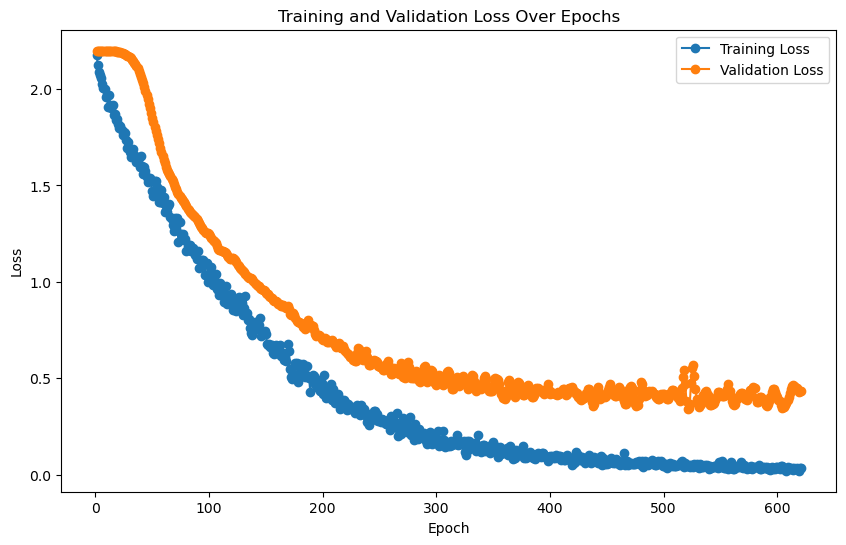

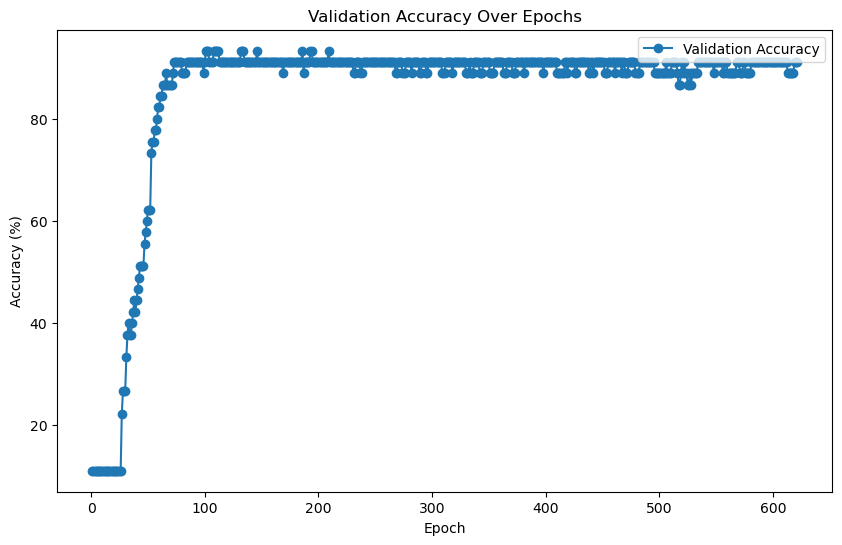


Evaluating on the test set...
    Test Batch [1/579], Loss: 0.1083



Final Test Loss: 0.1977, Test Accuracy: 95.79%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/579 for test dataset.
  Processed batch 20/579 for test dataset.
  Processed batch 30/579 for test dataset.


  Processed batch 40/579 for test dataset.
  Processed batch 50/579 for test dataset.
  Processed batch 60/579 for test dataset.
  Processed batch 70/579 for test dataset.
  Processed batch 80/579 for test dataset.


  Processed batch 90/579 for test dataset.
  Processed batch 100/579 for test dataset.
  Processed batch 110/579 for test dataset.
  Processed batch 120/579 for test dataset.
  Processed batch 130/579 for test dataset.


  Processed batch 140/579 for test dataset.
  Processed batch 150/579 for test dataset.
  Processed batch 160/579 for test dataset.
  Processed batch 170/579 for test dataset.
  Processed batch 180/579 for test dataset.


  Processed batch 190/579 for test dataset.
  Processed batch 200/579 for test dataset.
  Processed batch 210/579 for test dataset.
  Processed batch 220/579 for test dataset.
  Processed batch 230/579 for test dataset.


  Processed batch 240/579 for test dataset.
  Processed batch 250/579 for test dataset.
  Processed batch 260/579 for test dataset.
  Processed batch 270/579 for test dataset.
  Processed batch 280/579 for test dataset.


  Processed batch 290/579 for test dataset.
  Processed batch 300/579 for test dataset.
  Processed batch 310/579 for test dataset.
  Processed batch 320/579 for test dataset.
  Processed batch 330/579 for test dataset.


  Processed batch 340/579 for test dataset.
  Processed batch 350/579 for test dataset.
  Processed batch 360/579 for test dataset.
  Processed batch 370/579 for test dataset.
  Processed batch 380/579 for test dataset.


  Processed batch 390/579 for test dataset.
  Processed batch 400/579 for test dataset.
  Processed batch 410/579 for test dataset.
  Processed batch 420/579 for test dataset.
  Processed batch 430/579 for test dataset.


  Processed batch 440/579 for test dataset.
  Processed batch 450/579 for test dataset.
  Processed batch 460/579 for test dataset.
  Processed batch 470/579 for test dataset.
  Processed batch 480/579 for test dataset.


  Processed batch 490/579 for test dataset.
  Processed batch 500/579 for test dataset.
  Processed batch 510/579 for test dataset.
  Processed batch 520/579 for test dataset.
  Processed batch 530/579 for test dataset.


  Processed batch 540/579 for test dataset.
  Processed batch 550/579 for test dataset.
  Processed batch 560/579 for test dataset.
  Processed batch 570/579 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148062 samples with 64 features each
LOG: Labels shape: (148062,)

LOG: Training features shape: (45, 64), Training labels shape: (45,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (148062, 64), Test labels shape: (148062,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 84.44%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.71      1.00      0.83         5
           2       1.00      0.60      0.75         5
           3       0.80      0.80      0.80         5
           4       0.80      0.80      0.80         5
           5       0.75      0.60      0.67         5
           6       0.67      0.80      0.73         5
           7       1.00      1.00      1.00         5
           8       1.00      


Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     65961
           1       0.87      0.83      0.85      7588
           2       0.54      0.70      0.61      3080
           3       0.61      0.67      0.64      2675
           4       0.72      0.89      0.80      6574
           5       0.58      0.85      0.69      9238
           6       0.82      0.87      0.84      7277
           7       1.00      0.84      0.91     42816
           8       0.99      1.00      0.99      2853

    accuracy                           0.91    148062
   macro avg       0.79      0.85      0.82    148062
weighted avg       0.93      0.91      0.91    148062

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 148062 samples with 64 features each
LOG: Labels shape: (148062,)
Train reps shape: (45, 64)
Train labels shape: (45,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (148062, 64)
Test labels shape: (148062,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.4632  |  Val Loss: 2.3505
Validation loss improved from inf to 2.3505.


[Epoch 2/1000] Train Loss: 2.3428  |  Val Loss: 2.2555
Validation loss improved from 2.3505 to 2.2555.
[Epoch 3/1000] Train Loss: 2.2475  |  Val Loss: 2.1803
Validation loss improved from 2.2555 to 2.1803.
[Epoch 4/1000] Train Loss: 2.1706  |  Val Loss: 2.1223
Validation loss improved from 2.1803 to 2.1223.
[Epoch 5/1000] Train Loss: 2.1108  |  Val Loss: 2.0791
Validation loss improved from 2.1223 to 2.0791.
[Epoch 6/1000] Train Loss: 2.0674  |  Val Loss: 2.0417
Validation loss improved from 2.0791 to 2.0417.
[Epoch 7/1000] Train Loss: 2.0300  |  Val Loss: 2.0097
Validation loss improved from 2.0417 to 2.0097.
[Epoch 8/1000] Train Loss: 1.9916  |  Val Loss: 1.9803
Validation loss improved from 2.0097 to 1.9803.
[Epoch 9/1000] Train Loss: 1.9522  |  Val Loss: 1.9514
Validation loss improved from 1.9803 to 1.9514.
[Epoch 10/1000] Train Loss: 1.9132  |  Val Loss: 1.9212
Validation loss improved from 1.9514 to 1.9212.
[Epoch 11/1000] Train Loss: 1.8762  |  Val Loss: 1.8904
Validation loss 

[Epoch 70/1000] Train Loss: 0.1731  |  Val Loss: 0.4721
Validation loss improved from 0.4772 to 0.4721.
[Epoch 71/1000] Train Loss: 0.1664  |  Val Loss: 0.4677
Validation loss improved from 0.4721 to 0.4677.
[Epoch 72/1000] Train Loss: 0.1601  |  Val Loss: 0.4635
Validation loss improved from 0.4677 to 0.4635.
[Epoch 73/1000] Train Loss: 0.1540  |  Val Loss: 0.4594
Validation loss improved from 0.4635 to 0.4594.
[Epoch 74/1000] Train Loss: 0.1483  |  Val Loss: 0.4554
Validation loss improved from 0.4594 to 0.4554.
[Epoch 75/1000] Train Loss: 0.1428  |  Val Loss: 0.4510
Validation loss improved from 0.4554 to 0.4510.
[Epoch 76/1000] Train Loss: 0.1378  |  Val Loss: 0.4466
Validation loss improved from 0.4510 to 0.4466.
[Epoch 77/1000] Train Loss: 0.1335  |  Val Loss: 0.4431
Validation loss improved from 0.4466 to 0.4431.
[Epoch 78/1000] Train Loss: 0.1293  |  Val Loss: 0.4403
Validation loss improved from 0.4431 to 0.4403.
[Epoch 79/1000] Train Loss: 0.1252  |  Val Loss: 0.4367
Validati

[Epoch 138/1000] Train Loss: 0.0211  |  Val Loss: 0.4101
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 139/1000] Train Loss: 0.0205  |  Val Loss: 0.4103
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 140/1000] Train Loss: 0.0200  |  Val Loss: 0.4103
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 141/1000] Train Loss: 0.0195  |  Val Loss: 0.4103
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 142/1000] Train Loss: 0.0190  |  Val Loss: 0.4102
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 143/1000] Train Loss: 0.0186  |  Val Loss: 0.4108
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 144/1000] Train Loss: 0.0181  |  Val Loss: 0.4119
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 145/1000] Train Loss: 0.0177  |  Val Loss: 0.4133
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 146/1000] Train Loss: 0.0173  |  Val Loss: 0.4150
!! Validation loss did NOT improve !! Patience:

[Epoch 209/1000] Train Loss: 0.0057  |  Val Loss: 0.4495
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 210/1000] Train Loss: 0.0056  |  Val Loss: 0.4500
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 211/1000] Train Loss: 0.0056  |  Val Loss: 0.4504
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 212/1000] Train Loss: 0.0055  |  Val Loss: 0.4508
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 213/1000] Train Loss: 0.0054  |  Val Loss: 0.4513
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 213 !!
No improvement for 100 epochs.


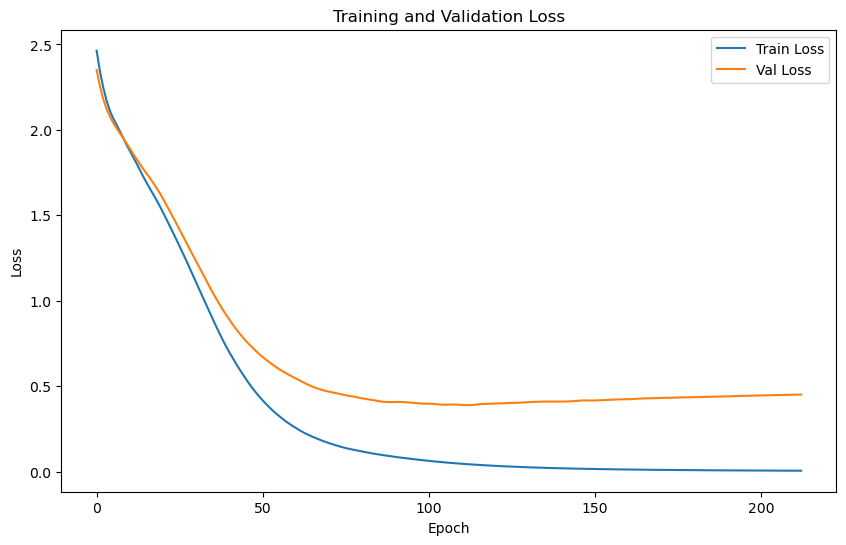

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.2896 | Test Accuracy: 91.10%


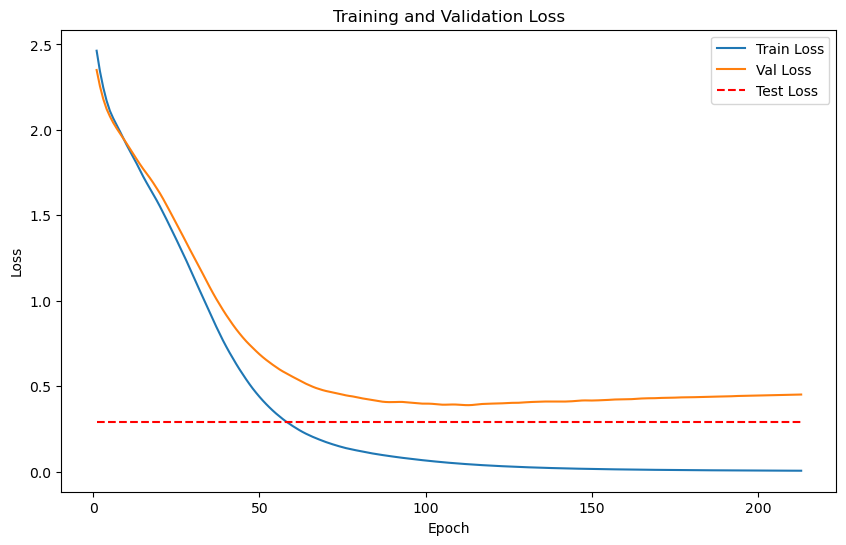

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148062 samples with 64 features each
LOG: Labels shape: (148062,)


Train embeddings shape: (45, 64), 
Train labels shape: (45,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (148062, 64), 
Test labels shape: (148062,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Training batch size: 45


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 7.9282
Epoch [1/2000], Avg Train Loss: 7.9282


Epoch [1/2000], Avg Val Loss: 3.4540
Validation loss improved from inf to 3.4540. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.4565
Epoch [2/2000], Avg Train Loss: 8.4565
Epoch [2/2000], Avg Val Loss: 3.4240
Validation loss improved from 3.4540 to 3.4240. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.4302
Epoch [3/2000], Avg Train Loss: 8.4302
Epoch [3/2000], Avg Val Loss: 3.3950
Validation loss improved from 3.4240 to 3.3950. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.2054
Epoch [4/2000], Avg Train Loss: 8.2054
Epoch [4/2000], Avg Val Loss: 3.3676
Validation loss improved from 3.3950 to 3.3676. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.1502
Epoch [5/2000], Avg Train Loss: 8.1502
Epoch [5/2000], Avg Val Loss: 3.3411
Validation loss improved from 3.3676 to 3.3411. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 7.6966
Ep

    Batch [1/1], Train Loss: 7.7480
Epoch [11/2000], Avg Train Loss: 7.7480
Epoch [11/2000], Avg Val Loss: 3.1988
Validation loss improved from 3.2209 to 3.1988. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 7.5147
Epoch [12/2000], Avg Train Loss: 7.5147
Epoch [12/2000], Avg Val Loss: 3.1772
Validation loss improved from 3.1988 to 3.1772. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 7.1276
Epoch [13/2000], Avg Train Loss: 7.1276
Epoch [13/2000], Avg Val Loss: 3.1565
Validation loss improved from 3.1772 to 3.1565. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 7.0016
Epoch [14/2000], Avg Train Loss: 7.0016
Epoch [14/2000], Avg Val Loss: 3.1364
Validation loss improved from 3.1565 to 3.1364. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 7.2730
Epoch [15/2000], Avg Train Loss: 7.2730
Epoch [15/2000], Avg Val Loss: 3.1167
Validation loss improved from 3.1364 to 3.

Epoch [52/2000], Avg Val Loss: 2.7000
Validation loss improved from 2.7056 to 2.7000. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 5.5085
Epoch [53/2000], Avg Train Loss: 5.5085
Epoch [53/2000], Avg Val Loss: 2.6946
Validation loss improved from 2.7000 to 2.6946. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 5.1175
Epoch [54/2000], Avg Train Loss: 5.1175
Epoch [54/2000], Avg Val Loss: 2.6894
Validation loss improved from 2.6946 to 2.6894. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 5.2617
Epoch [55/2000], Avg Train Loss: 5.2617
Epoch [55/2000], Avg Val Loss: 2.6844
Validation loss improved from 2.6894 to 2.6844. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 5.2676
Epoch [56/2000], Avg Train Loss: 5.2676
Epoch [56/2000], Avg Val Loss: 2.6796
Validation loss improved from 2.6844 to 2.6796. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.0535
Epoch [103/2000], Avg Train Loss: 4.0535
Epoch [103/2000], Avg Val Loss: 2.5789
Validation loss improved from 2.5796 to 2.5789. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 4.0340
Epoch [104/2000], Avg Train Loss: 4.0340
Epoch [104/2000], Avg Val Loss: 2.5782
Validation loss improved from 2.5789 to 2.5782. Saving model...

LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 4.0934
Epoch [105/2000], Avg Train Loss: 4.0934
Epoch [105/2000], Avg Val Loss: 2.5775
Validation loss improved from 2.5782 to 2.5775. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 4.1164
Epoch [106/2000], Avg Train Loss: 4.1164
Epoch [106/2000], Avg Val Loss: 2.5768
Validation loss improved from 2.5775 to 2.5768. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 4.0214
Epoch [107/2000], Avg Train Loss: 4.0214
Epoch [107/2000], Avg Val Loss: 2.5762
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6759
Epoch [149/2000], Avg Train Loss: 3.6759
Epoch [149/2000], Avg Val Loss: 2.5623
Validation loss improved from 2.5625 to 2.5623. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 3.4724
Epoch [150/2000], Avg Train Loss: 3.4724
Epoch [150/2000], Avg Val Loss: 2.5620
Validation loss improved from 2.5623 to 2.5620. Saving model...

LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 3.6438
Epoch [151/2000], Avg Train Loss: 3.6438
Epoch [151/2000], Avg Val Loss: 2.5618
Validation loss improved from 2.5620 to 2.5618. Saving model...

LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 3.5421
Epoch [152/2000], Avg Train Loss: 3.5421
Epoch [152/2000], Avg Val Loss: 2.5615
Validation loss improved from 2.5618 to 2.5615. Saving model...

LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 3.6196
Epoch [153/2000], Avg Train Loss: 3.6196
Epoch [153/2000], Avg Val Loss: 2.5613
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2513
Epoch [195/2000], Avg Train Loss: 3.2513
Epoch [195/2000], Avg Val Loss: 2.5509
Validation loss improved from 2.5512 to 2.5509. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 3.2330
Epoch [196/2000], Avg Train Loss: 3.2330
Epoch [196/2000], Avg Val Loss: 2.5505
Validation loss improved from 2.5509 to 2.5505. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 3.1451
Epoch [197/2000], Avg Train Loss: 3.1451
Epoch [197/2000], Avg Val Loss: 2.5502
Validation loss improved from 2.5505 to 2.5502. Saving model...

LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 3.2159
Epoch [198/2000], Avg Train Loss: 3.2159
Epoch [198/2000], Avg Val Loss: 2.5498
Validation loss improved from 2.5502 to 2.5498. Saving model...

LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 3.1469
Epoch [199/2000], Avg Train Loss: 3.1469
Epoch [199/2000], Avg Val Loss: 2.5494
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1576
Epoch [243/2000], Avg Train Loss: 3.1576
Epoch [243/2000], Avg Val Loss: 2.5299
Validation loss improved from 2.5305 to 2.5299. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 3.0486
Epoch [244/2000], Avg Train Loss: 3.0486
Epoch [244/2000], Avg Val Loss: 2.5294
Validation loss improved from 2.5299 to 2.5294. Saving model...

LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 3.2081
Epoch [245/2000], Avg Train Loss: 3.2081
Epoch [245/2000], Avg Val Loss: 2.5289
Validation loss improved from 2.5294 to 2.5289. Saving model...

LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 3.0539
Epoch [246/2000], Avg Train Loss: 3.0539
Epoch [246/2000], Avg Val Loss: 2.5284
Validation loss improved from 2.5289 to 2.5284. Saving model...

LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 3.0807
Epoch [247/2000], Avg Train Loss: 3.0807
Epoch [247/2000], Avg Val Loss: 2.5278
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9932
Epoch [287/2000], Avg Train Loss: 2.9932
Epoch [287/2000], Avg Val Loss: 2.5066
Validation loss improved from 2.5072 to 2.5066. Saving model...

LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 2.9846
Epoch [288/2000], Avg Train Loss: 2.9846
Epoch [288/2000], Avg Val Loss: 2.5060
Validation loss improved from 2.5066 to 2.5060. Saving model...

LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 3.0718
Epoch [289/2000], Avg Train Loss: 3.0718
Epoch [289/2000], Avg Val Loss: 2.5054
Validation loss improved from 2.5060 to 2.5054. Saving model...

LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 2.9481
Epoch [290/2000], Avg Train Loss: 2.9481
Epoch [290/2000], Avg Val Loss: 2.5049
Validation loss improved from 2.5054 to 2.5049. Saving model...

LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 2.9334
Epoch [291/2000], Avg Train Loss: 2.9334
Epoch [291/2000], Avg Val Loss: 2.5043
Validation loss improved fro

Epoch [334/2000], Avg Val Loss: 2.4788
Validation loss improved from 2.4794 to 2.4788. Saving model...

LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 2.8931
Epoch [335/2000], Avg Train Loss: 2.8931
Epoch [335/2000], Avg Val Loss: 2.4783
Validation loss improved from 2.4788 to 2.4783. Saving model...

LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 2.8769
Epoch [336/2000], Avg Train Loss: 2.8769
Epoch [336/2000], Avg Val Loss: 2.4777
Validation loss improved from 2.4783 to 2.4777. Saving model...

LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 2.9533
Epoch [337/2000], Avg Train Loss: 2.9533
Epoch [337/2000], Avg Val Loss: 2.4772
Validation loss improved from 2.4777 to 2.4772. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 2.9782
Epoch [338/2000], Avg Train Loss: 2.9782
Epoch [338/2000], Avg Val Loss: 2.4766
Validation loss improved from 2.4772 to 2.4766. Saving model...

LOG: Epoch [339/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.8310
Epoch [380/2000], Avg Train Loss: 2.8310
Epoch [380/2000], Avg Val Loss: 2.4516
Validation loss improved from 2.4522 to 2.4516. Saving model...

LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 2.8189
Epoch [381/2000], Avg Train Loss: 2.8189
Epoch [381/2000], Avg Val Loss: 2.4510
Validation loss improved from 2.4516 to 2.4510. Saving model...

LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 2.8725
Epoch [382/2000], Avg Train Loss: 2.8725
Epoch [382/2000], Avg Val Loss: 2.4504
Validation loss improved from 2.4510 to 2.4504. Saving model...

LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 2.8214
Epoch [383/2000], Avg Train Loss: 2.8214
Epoch [383/2000], Avg Val Loss: 2.4498
Validation loss improved from 2.4504 to 2.4498. Saving model...

LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 2.7943
Epoch [384/2000], Avg Train Loss: 2.7943
Epoch [384/2000], Avg Val Loss: 2.4492
Validation loss improved fro

    Batch [1/1], Train Loss: 2.7092
Epoch [423/2000], Avg Train Loss: 2.7092
Epoch [423/2000], Avg Val Loss: 2.4263
Validation loss improved from 2.4269 to 2.4263. Saving model...

LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 2.7345
Epoch [424/2000], Avg Train Loss: 2.7345
Epoch [424/2000], Avg Val Loss: 2.4257
Validation loss improved from 2.4263 to 2.4257. Saving model...

LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 2.7240
Epoch [425/2000], Avg Train Loss: 2.7240
Epoch [425/2000], Avg Val Loss: 2.4251
Validation loss improved from 2.4257 to 2.4251. Saving model...

LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 2.6791
Epoch [426/2000], Avg Train Loss: 2.6791
Epoch [426/2000], Avg Val Loss: 2.4245
Validation loss improved from 2.4251 to 2.4245. Saving model...

LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 2.7259
Epoch [427/2000], Avg Train Loss: 2.7259
Epoch [427/2000], Avg Val Loss: 2.4239
Validation loss improved fro

    Batch [1/1], Train Loss: 2.6284
Epoch [465/2000], Avg Train Loss: 2.6284
Epoch [465/2000], Avg Val Loss: 2.4028
Validation loss improved from 2.4033 to 2.4028. Saving model...

LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 2.6879
Epoch [466/2000], Avg Train Loss: 2.6879
Epoch [466/2000], Avg Val Loss: 2.4022
Validation loss improved from 2.4028 to 2.4022. Saving model...

LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 2.7308
Epoch [467/2000], Avg Train Loss: 2.7308
Epoch [467/2000], Avg Val Loss: 2.4017
Validation loss improved from 2.4022 to 2.4017. Saving model...

LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 2.6587
Epoch [468/2000], Avg Train Loss: 2.6587
Epoch [468/2000], Avg Val Loss: 2.4011
Validation loss improved from 2.4017 to 2.4011. Saving model...

LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 2.6990
Epoch [469/2000], Avg Train Loss: 2.6990
Epoch [469/2000], Avg Val Loss: 2.4005
Validation loss improved fro

    Batch [1/1], Train Loss: 2.6628
Epoch [509/2000], Avg Train Loss: 2.6628
Epoch [509/2000], Avg Val Loss: 2.3798
Validation loss improved from 2.3803 to 2.3798. Saving model...

LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 2.6453
Epoch [510/2000], Avg Train Loss: 2.6453
Epoch [510/2000], Avg Val Loss: 2.3793
Validation loss improved from 2.3798 to 2.3793. Saving model...

LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 2.6465
Epoch [511/2000], Avg Train Loss: 2.6465
Epoch [511/2000], Avg Val Loss: 2.3788
Validation loss improved from 2.3793 to 2.3788. Saving model...

LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 2.6388
Epoch [512/2000], Avg Train Loss: 2.6388
Epoch [512/2000], Avg Val Loss: 2.3783
Validation loss improved from 2.3788 to 2.3783. Saving model...

LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 2.6442
Epoch [513/2000], Avg Train Loss: 2.6442
Epoch [513/2000], Avg Val Loss: 2.3778
Validation loss improved fro

    Batch [1/1], Train Loss: 2.6191
Epoch [556/2000], Avg Train Loss: 2.6191
Epoch [556/2000], Avg Val Loss: 2.3591
Validation loss improved from 2.3595 to 2.3591. Saving model...

LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 2.7062
Epoch [557/2000], Avg Train Loss: 2.7062
Epoch [557/2000], Avg Val Loss: 2.3588
Validation loss improved from 2.3591 to 2.3588. Saving model...

LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 2.5513
Epoch [558/2000], Avg Train Loss: 2.5513
Epoch [558/2000], Avg Val Loss: 2.3584
Validation loss improved from 2.3588 to 2.3584. Saving model...

LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 2.6717
Epoch [559/2000], Avg Train Loss: 2.6717
Epoch [559/2000], Avg Val Loss: 2.3580
Validation loss improved from 2.3584 to 2.3580. Saving model...

LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 2.6051
Epoch [560/2000], Avg Train Loss: 2.6051
Epoch [560/2000], Avg Val Loss: 2.3576
Validation loss improved fro

Epoch [601/2000], Avg Val Loss: 2.3411
Validation loss improved from 2.3415 to 2.3411. Saving model...

LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 2.5558
Epoch [602/2000], Avg Train Loss: 2.5558
Epoch [602/2000], Avg Val Loss: 2.3408
Validation loss improved from 2.3411 to 2.3408. Saving model...

LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 2.5951
Epoch [603/2000], Avg Train Loss: 2.5951
Epoch [603/2000], Avg Val Loss: 2.3404
Validation loss improved from 2.3408 to 2.3404. Saving model...

LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 2.5902
Epoch [604/2000], Avg Train Loss: 2.5902
Epoch [604/2000], Avg Val Loss: 2.3400
Validation loss improved from 2.3404 to 2.3400. Saving model...

LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 2.5917
Epoch [605/2000], Avg Train Loss: 2.5917
Epoch [605/2000], Avg Val Loss: 2.3397
Validation loss improved from 2.3400 to 2.3397. Saving model...

LOG: Epoch [606/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.5642
Epoch [649/2000], Avg Train Loss: 2.5642
Epoch [649/2000], Avg Val Loss: 2.3236
Validation loss improved from 2.3240 to 2.3236. Saving model...

LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 2.5218
Epoch [650/2000], Avg Train Loss: 2.5218
Epoch [650/2000], Avg Val Loss: 2.3233
Validation loss improved from 2.3236 to 2.3233. Saving model...

LOG: Epoch [651/2000] - Training
    Batch [1/1], Train Loss: 2.4970
Epoch [651/2000], Avg Train Loss: 2.4970
Epoch [651/2000], Avg Val Loss: 2.3229
Validation loss improved from 2.3233 to 2.3229. Saving model...

LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 2.5889
Epoch [652/2000], Avg Train Loss: 2.5889
Epoch [652/2000], Avg Val Loss: 2.3226
Validation loss improved from 2.3229 to 2.3226. Saving model...

LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 2.5214
Epoch [653/2000], Avg Train Loss: 2.5214
Epoch [653/2000], Avg Val Loss: 2.3222
Validation loss improved fro

    Batch [1/1], Train Loss: 2.4795
Epoch [695/2000], Avg Train Loss: 2.4795
Epoch [695/2000], Avg Val Loss: 2.3087
Validation loss improved from 2.3091 to 2.3087. Saving model...

LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 2.4928
Epoch [696/2000], Avg Train Loss: 2.4928
Epoch [696/2000], Avg Val Loss: 2.3084
Validation loss improved from 2.3087 to 2.3084. Saving model...

LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 2.4567
Epoch [697/2000], Avg Train Loss: 2.4567
Epoch [697/2000], Avg Val Loss: 2.3081
Validation loss improved from 2.3084 to 2.3081. Saving model...

LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 2.4709
Epoch [698/2000], Avg Train Loss: 2.4709
Epoch [698/2000], Avg Val Loss: 2.3078
Validation loss improved from 2.3081 to 2.3078. Saving model...

LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 2.4823
Epoch [699/2000], Avg Train Loss: 2.4823
Epoch [699/2000], Avg Val Loss: 2.3074
Validation loss improved fro

    Batch [1/1], Train Loss: 2.4745
Epoch [739/2000], Avg Train Loss: 2.4745
Epoch [739/2000], Avg Val Loss: 2.2951
Validation loss improved from 2.2954 to 2.2951. Saving model...

LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 2.5167
Epoch [740/2000], Avg Train Loss: 2.5167
Epoch [740/2000], Avg Val Loss: 2.2948
Validation loss improved from 2.2951 to 2.2948. Saving model...

LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 2.4147
Epoch [741/2000], Avg Train Loss: 2.4147
Epoch [741/2000], Avg Val Loss: 2.2945
Validation loss improved from 2.2948 to 2.2945. Saving model...

LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 2.4538
Epoch [742/2000], Avg Train Loss: 2.4538
Epoch [742/2000], Avg Val Loss: 2.2942
Validation loss improved from 2.2945 to 2.2942. Saving model...

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 2.4309
Epoch [743/2000], Avg Train Loss: 2.4309
Epoch [743/2000], Avg Val Loss: 2.2939
Validation loss improved fro

Epoch [784/2000], Avg Val Loss: 2.2818
Validation loss improved from 2.2821 to 2.2818. Saving model...

LOG: Epoch [785/2000] - Training
    Batch [1/1], Train Loss: 2.4571
Epoch [785/2000], Avg Train Loss: 2.4571
Epoch [785/2000], Avg Val Loss: 2.2815
Validation loss improved from 2.2818 to 2.2815. Saving model...

LOG: Epoch [786/2000] - Training
    Batch [1/1], Train Loss: 2.4232
Epoch [786/2000], Avg Train Loss: 2.4232
Epoch [786/2000], Avg Val Loss: 2.2812
Validation loss improved from 2.2815 to 2.2812. Saving model...

LOG: Epoch [787/2000] - Training
    Batch [1/1], Train Loss: 2.4817
Epoch [787/2000], Avg Train Loss: 2.4817
Epoch [787/2000], Avg Val Loss: 2.2810
Validation loss improved from 2.2812 to 2.2810. Saving model...

LOG: Epoch [788/2000] - Training
    Batch [1/1], Train Loss: 2.4030
Epoch [788/2000], Avg Train Loss: 2.4030
Epoch [788/2000], Avg Val Loss: 2.2807
Validation loss improved from 2.2810 to 2.2807. Saving model...

LOG: Epoch [789/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.4174
Epoch [828/2000], Avg Train Loss: 2.4174
Epoch [828/2000], Avg Val Loss: 2.2696
Validation loss improved from 2.2699 to 2.2696. Saving model...

LOG: Epoch [829/2000] - Training
    Batch [1/1], Train Loss: 2.3916
Epoch [829/2000], Avg Train Loss: 2.3916
Epoch [829/2000], Avg Val Loss: 2.2694
Validation loss improved from 2.2696 to 2.2694. Saving model...

LOG: Epoch [830/2000] - Training
    Batch [1/1], Train Loss: 2.3443
Epoch [830/2000], Avg Train Loss: 2.3443
Epoch [830/2000], Avg Val Loss: 2.2691
Validation loss improved from 2.2694 to 2.2691. Saving model...

LOG: Epoch [831/2000] - Training
    Batch [1/1], Train Loss: 2.3381
Epoch [831/2000], Avg Train Loss: 2.3381
Epoch [831/2000], Avg Val Loss: 2.2689
Validation loss improved from 2.2691 to 2.2689. Saving model...

LOG: Epoch [832/2000] - Training
    Batch [1/1], Train Loss: 2.4138
Epoch [832/2000], Avg Train Loss: 2.4138
Epoch [832/2000], Avg Val Loss: 2.2686
Validation loss improved fro

Epoch [871/2000], Avg Val Loss: 2.2597
Validation loss improved from 2.2599 to 2.2597. Saving model...

LOG: Epoch [872/2000] - Training
    Batch [1/1], Train Loss: 2.4477
Epoch [872/2000], Avg Train Loss: 2.4477
Epoch [872/2000], Avg Val Loss: 2.2595
Validation loss improved from 2.2597 to 2.2595. Saving model...

LOG: Epoch [873/2000] - Training
    Batch [1/1], Train Loss: 2.3653
Epoch [873/2000], Avg Train Loss: 2.3653
Epoch [873/2000], Avg Val Loss: 2.2592
Validation loss improved from 2.2595 to 2.2592. Saving model...

LOG: Epoch [874/2000] - Training
    Batch [1/1], Train Loss: 2.4371
Epoch [874/2000], Avg Train Loss: 2.4371
Epoch [874/2000], Avg Val Loss: 2.2590
Validation loss improved from 2.2592 to 2.2590. Saving model...

LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 2.3497
Epoch [875/2000], Avg Train Loss: 2.3497
Epoch [875/2000], Avg Val Loss: 2.2588
Validation loss improved from 2.2590 to 2.2588. Saving model...

LOG: Epoch [876/2000] - Training
    Bat

Epoch [918/2000], Avg Train Loss: 2.2979
Epoch [918/2000], Avg Val Loss: 2.2473
Validation loss improved from 2.2475 to 2.2473. Saving model...

LOG: Epoch [919/2000] - Training
    Batch [1/1], Train Loss: 2.3546
Epoch [919/2000], Avg Train Loss: 2.3546
Epoch [919/2000], Avg Val Loss: 2.2470
Validation loss improved from 2.2473 to 2.2470. Saving model...

LOG: Epoch [920/2000] - Training
    Batch [1/1], Train Loss: 2.3305
Epoch [920/2000], Avg Train Loss: 2.3305
Epoch [920/2000], Avg Val Loss: 2.2468
Validation loss improved from 2.2470 to 2.2468. Saving model...

LOG: Epoch [921/2000] - Training
    Batch [1/1], Train Loss: 2.3639
Epoch [921/2000], Avg Train Loss: 2.3639
Epoch [921/2000], Avg Val Loss: 2.2466
Validation loss improved from 2.2468 to 2.2466. Saving model...

LOG: Epoch [922/2000] - Training
    Batch [1/1], Train Loss: 2.3117
Epoch [922/2000], Avg Train Loss: 2.3117
Epoch [922/2000], Avg Val Loss: 2.2463
Validation loss improved from 2.2466 to 2.2463. Saving model...


    Batch [1/1], Train Loss: 2.3520
Epoch [961/2000], Avg Train Loss: 2.3520
Epoch [961/2000], Avg Val Loss: 2.2370
Validation loss improved from 2.2373 to 2.2370. Saving model...

LOG: Epoch [962/2000] - Training
    Batch [1/1], Train Loss: 2.2938
Epoch [962/2000], Avg Train Loss: 2.2938
Epoch [962/2000], Avg Val Loss: 2.2368
Validation loss improved from 2.2370 to 2.2368. Saving model...

LOG: Epoch [963/2000] - Training
    Batch [1/1], Train Loss: 2.3447
Epoch [963/2000], Avg Train Loss: 2.3447
Epoch [963/2000], Avg Val Loss: 2.2366
Validation loss improved from 2.2368 to 2.2366. Saving model...

LOG: Epoch [964/2000] - Training
    Batch [1/1], Train Loss: 2.2420
Epoch [964/2000], Avg Train Loss: 2.2420
Epoch [964/2000], Avg Val Loss: 2.2363
Validation loss improved from 2.2366 to 2.2363. Saving model...

LOG: Epoch [965/2000] - Training
    Batch [1/1], Train Loss: 2.2794
Epoch [965/2000], Avg Train Loss: 2.2794
Epoch [965/2000], Avg Val Loss: 2.2361
Validation loss improved fro

Epoch [1010/2000], Avg Val Loss: 2.2263
Validation loss improved from 2.2265 to 2.2263. Saving model...

LOG: Epoch [1011/2000] - Training
    Batch [1/1], Train Loss: 2.2898
Epoch [1011/2000], Avg Train Loss: 2.2898
Epoch [1011/2000], Avg Val Loss: 2.2261
Validation loss improved from 2.2263 to 2.2261. Saving model...

LOG: Epoch [1012/2000] - Training
    Batch [1/1], Train Loss: 2.3058
Epoch [1012/2000], Avg Train Loss: 2.3058
Epoch [1012/2000], Avg Val Loss: 2.2259
Validation loss improved from 2.2261 to 2.2259. Saving model...

LOG: Epoch [1013/2000] - Training
    Batch [1/1], Train Loss: 2.2837
Epoch [1013/2000], Avg Train Loss: 2.2837
Epoch [1013/2000], Avg Val Loss: 2.2257
Validation loss improved from 2.2259 to 2.2257. Saving model...

LOG: Epoch [1014/2000] - Training
    Batch [1/1], Train Loss: 2.2574
Epoch [1014/2000], Avg Train Loss: 2.2574
Epoch [1014/2000], Avg Val Loss: 2.2255
Validation loss improved from 2.2257 to 2.2255. Saving model...

LOG: Epoch [1015/2000] - Tr

    Batch [1/1], Train Loss: 2.2967
Epoch [1050/2000], Avg Train Loss: 2.2967
Epoch [1050/2000], Avg Val Loss: 2.2188
Validation loss improved from 2.2190 to 2.2188. Saving model...

LOG: Epoch [1051/2000] - Training
    Batch [1/1], Train Loss: 2.2070
Epoch [1051/2000], Avg Train Loss: 2.2070
Epoch [1051/2000], Avg Val Loss: 2.2186
Validation loss improved from 2.2188 to 2.2186. Saving model...

LOG: Epoch [1052/2000] - Training
    Batch [1/1], Train Loss: 2.2391
Epoch [1052/2000], Avg Train Loss: 2.2391
Epoch [1052/2000], Avg Val Loss: 2.2184
Validation loss improved from 2.2186 to 2.2184. Saving model...

LOG: Epoch [1053/2000] - Training
    Batch [1/1], Train Loss: 2.3050
Epoch [1053/2000], Avg Train Loss: 2.3050
Epoch [1053/2000], Avg Val Loss: 2.2181
Validation loss improved from 2.2184 to 2.2181. Saving model...

LOG: Epoch [1054/2000] - Training
    Batch [1/1], Train Loss: 2.2937
Epoch [1054/2000], Avg Train Loss: 2.2937
Epoch [1054/2000], Avg Val Loss: 2.2179
Validation los

    Batch [1/1], Train Loss: 2.2466
Epoch [1096/2000], Avg Train Loss: 2.2466
Epoch [1096/2000], Avg Val Loss: 2.2103
Validation loss improved from 2.2104 to 2.2103. Saving model...

LOG: Epoch [1097/2000] - Training
    Batch [1/1], Train Loss: 2.2240
Epoch [1097/2000], Avg Train Loss: 2.2240
Epoch [1097/2000], Avg Val Loss: 2.2102
Validation loss improved from 2.2103 to 2.2102. Saving model...

LOG: Epoch [1098/2000] - Training
    Batch [1/1], Train Loss: 2.2489
Epoch [1098/2000], Avg Train Loss: 2.2489
Epoch [1098/2000], Avg Val Loss: 2.2100
Validation loss improved from 2.2102 to 2.2100. Saving model...

LOG: Epoch [1099/2000] - Training
    Batch [1/1], Train Loss: 2.2528
Epoch [1099/2000], Avg Train Loss: 2.2528
Epoch [1099/2000], Avg Val Loss: 2.2099
Validation loss improved from 2.2100 to 2.2099. Saving model...

LOG: Epoch [1100/2000] - Training
    Batch [1/1], Train Loss: 2.2357
Epoch [1100/2000], Avg Train Loss: 2.2357
Epoch [1100/2000], Avg Val Loss: 2.2097
Validation los

Epoch [1144/2000], Avg Val Loss: 2.2027
Validation loss improved from 2.2028 to 2.2027. Saving model...

LOG: Epoch [1145/2000] - Training
    Batch [1/1], Train Loss: 2.2054
Epoch [1145/2000], Avg Train Loss: 2.2054
Epoch [1145/2000], Avg Val Loss: 2.2026
Validation loss improved from 2.2027 to 2.2026. Saving model...

LOG: Epoch [1146/2000] - Training
    Batch [1/1], Train Loss: 2.1941
Epoch [1146/2000], Avg Train Loss: 2.1941
Epoch [1146/2000], Avg Val Loss: 2.2024
Validation loss improved from 2.2026 to 2.2024. Saving model...

LOG: Epoch [1147/2000] - Training
    Batch [1/1], Train Loss: 2.2930
Epoch [1147/2000], Avg Train Loss: 2.2930
Epoch [1147/2000], Avg Val Loss: 2.2023
Validation loss improved from 2.2024 to 2.2023. Saving model...

LOG: Epoch [1148/2000] - Training
    Batch [1/1], Train Loss: 2.2043
Epoch [1148/2000], Avg Train Loss: 2.2043
Epoch [1148/2000], Avg Val Loss: 2.2022
Validation loss improved from 2.2023 to 2.2022. Saving model...

LOG: Epoch [1149/2000] - Tr

    Batch [1/1], Train Loss: 2.2010
Epoch [1190/2000], Avg Train Loss: 2.2010
Epoch [1190/2000], Avg Val Loss: 2.1967
Validation loss improved from 2.1968 to 2.1967. Saving model...

LOG: Epoch [1191/2000] - Training
    Batch [1/1], Train Loss: 2.1988
Epoch [1191/2000], Avg Train Loss: 2.1988
Epoch [1191/2000], Avg Val Loss: 2.1965
Validation loss improved from 2.1967 to 2.1965. Saving model...

LOG: Epoch [1192/2000] - Training
    Batch [1/1], Train Loss: 2.1678
Epoch [1192/2000], Avg Train Loss: 2.1678
Epoch [1192/2000], Avg Val Loss: 2.1965
Validation loss improved from 2.1965 to 2.1965. Saving model...

LOG: Epoch [1193/2000] - Training
    Batch [1/1], Train Loss: 2.1583
Epoch [1193/2000], Avg Train Loss: 2.1583
Epoch [1193/2000], Avg Val Loss: 2.1964
Validation loss improved from 2.1965 to 2.1964. Saving model...

LOG: Epoch [1194/2000] - Training
    Batch [1/1], Train Loss: 2.1779
Epoch [1194/2000], Avg Train Loss: 2.1779
Epoch [1194/2000], Avg Val Loss: 2.1963
Validation los

    Batch [1/1], Train Loss: 2.1298
Epoch [1237/2000], Avg Train Loss: 2.1298
Epoch [1237/2000], Avg Val Loss: 2.1916
Validation loss improved from 2.1917 to 2.1916. Saving model...

LOG: Epoch [1238/2000] - Training
    Batch [1/1], Train Loss: 2.2316
Epoch [1238/2000], Avg Train Loss: 2.2316
Epoch [1238/2000], Avg Val Loss: 2.1915
Validation loss improved from 2.1916 to 2.1915. Saving model...

LOG: Epoch [1239/2000] - Training
    Batch [1/1], Train Loss: 2.2047
Epoch [1239/2000], Avg Train Loss: 2.2047
Epoch [1239/2000], Avg Val Loss: 2.1913
Validation loss improved from 2.1915 to 2.1913. Saving model...

LOG: Epoch [1240/2000] - Training
    Batch [1/1], Train Loss: 2.2114
Epoch [1240/2000], Avg Train Loss: 2.2114
Epoch [1240/2000], Avg Val Loss: 2.1912
Validation loss improved from 2.1913 to 2.1912. Saving model...

LOG: Epoch [1241/2000] - Training
    Batch [1/1], Train Loss: 2.2126
Epoch [1241/2000], Avg Train Loss: 2.2126
Epoch [1241/2000], Avg Val Loss: 2.1911
Validation los

    Batch [1/1], Train Loss: 2.1464
Epoch [1282/2000], Avg Train Loss: 2.1464
Epoch [1282/2000], Avg Val Loss: 2.1885
Validation loss improved from 2.1886 to 2.1885. Saving model...

LOG: Epoch [1283/2000] - Training
    Batch [1/1], Train Loss: 2.1356
Epoch [1283/2000], Avg Train Loss: 2.1356
Epoch [1283/2000], Avg Val Loss: 2.1885
Validation loss improved from 2.1885 to 2.1885. Saving model...

LOG: Epoch [1284/2000] - Training
    Batch [1/1], Train Loss: 2.0930
Epoch [1284/2000], Avg Train Loss: 2.0930
Epoch [1284/2000], Avg Val Loss: 2.1884
Validation loss improved from 2.1885 to 2.1884. Saving model...

LOG: Epoch [1285/2000] - Training
    Batch [1/1], Train Loss: 2.1351
Epoch [1285/2000], Avg Train Loss: 2.1351
Epoch [1285/2000], Avg Val Loss: 2.1884
Validation loss improved from 2.1884 to 2.1884. Saving model...

LOG: Epoch [1286/2000] - Training
    Batch [1/1], Train Loss: 2.1637
Epoch [1286/2000], Avg Train Loss: 2.1637
Epoch [1286/2000], Avg Val Loss: 2.1884
Validation los

    Batch [1/1], Train Loss: 2.1995
Epoch [1329/2000], Avg Train Loss: 2.1995
Epoch [1329/2000], Avg Val Loss: 2.1833
Validation loss improved from 2.1834 to 2.1833. Saving model...

LOG: Epoch [1330/2000] - Training
    Batch [1/1], Train Loss: 2.1149
Epoch [1330/2000], Avg Train Loss: 2.1149
Epoch [1330/2000], Avg Val Loss: 2.1832
Validation loss improved from 2.1833 to 2.1832. Saving model...

LOG: Epoch [1331/2000] - Training
    Batch [1/1], Train Loss: 2.1279
Epoch [1331/2000], Avg Train Loss: 2.1279
Epoch [1331/2000], Avg Val Loss: 2.1831
Validation loss improved from 2.1832 to 2.1831. Saving model...

LOG: Epoch [1332/2000] - Training
    Batch [1/1], Train Loss: 2.1071
Epoch [1332/2000], Avg Train Loss: 2.1071
Epoch [1332/2000], Avg Val Loss: 2.1830
Validation loss improved from 2.1831 to 2.1830. Saving model...

LOG: Epoch [1333/2000] - Training
    Batch [1/1], Train Loss: 2.0803
Epoch [1333/2000], Avg Train Loss: 2.0803
Epoch [1333/2000], Avg Val Loss: 2.1829
Validation los

    Batch [1/1], Train Loss: 2.1426
Epoch [1376/2000], Avg Train Loss: 2.1426
Epoch [1376/2000], Avg Val Loss: 2.1809
Validation loss improved from 2.1809 to 2.1809. Saving model...

LOG: Epoch [1377/2000] - Training
    Batch [1/1], Train Loss: 2.1265
Epoch [1377/2000], Avg Train Loss: 2.1265
Epoch [1377/2000], Avg Val Loss: 2.1809
Validation loss improved from 2.1809 to 2.1809. Saving model...

LOG: Epoch [1378/2000] - Training
    Batch [1/1], Train Loss: 2.0966
Epoch [1378/2000], Avg Train Loss: 2.0966
Epoch [1378/2000], Avg Val Loss: 2.1809
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1379/2000] - Training
    Batch [1/1], Train Loss: 2.1430
Epoch [1379/2000], Avg Train Loss: 2.1430
Epoch [1379/2000], Avg Val Loss: 2.1809
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1380/2000] - Training
    Batch [1/1], Train Loss: 2.0894
Epoch [1380/2000], Avg Train Loss: 2.0894
Epoch [1380/2000], Avg Val Loss: 2.1809
Validation loss did not improve. Patience: 3

    Batch [1/1], Train Loss: 2.1189
Epoch [1421/2000], Avg Train Loss: 2.1189
Epoch [1421/2000], Avg Val Loss: 2.1788
Validation loss improved from 2.1788 to 2.1788. Saving model...

LOG: Epoch [1422/2000] - Training
    Batch [1/1], Train Loss: 2.0431
Epoch [1422/2000], Avg Train Loss: 2.0431
Epoch [1422/2000], Avg Val Loss: 2.1788
Validation loss improved from 2.1788 to 2.1788. Saving model...

LOG: Epoch [1423/2000] - Training
    Batch [1/1], Train Loss: 2.0954
Epoch [1423/2000], Avg Train Loss: 2.0954
Epoch [1423/2000], Avg Val Loss: 2.1788
Validation loss improved from 2.1788 to 2.1788. Saving model...

LOG: Epoch [1424/2000] - Training
    Batch [1/1], Train Loss: 2.0922
Epoch [1424/2000], Avg Train Loss: 2.0922
Epoch [1424/2000], Avg Val Loss: 2.1787
Validation loss improved from 2.1788 to 2.1787. Saving model...

LOG: Epoch [1425/2000] - Training
    Batch [1/1], Train Loss: 2.1185
Epoch [1425/2000], Avg Train Loss: 2.1185
Epoch [1425/2000], Avg Val Loss: 2.1788
Validation los

    Batch [1/1], Train Loss: 2.0313
Epoch [1467/2000], Avg Train Loss: 2.0313
Epoch [1467/2000], Avg Val Loss: 2.1815
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1468/2000] - Training
    Batch [1/1], Train Loss: 2.0613
Epoch [1468/2000], Avg Train Loss: 2.0613
Epoch [1468/2000], Avg Val Loss: 2.1816
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1469/2000] - Training
    Batch [1/1], Train Loss: 2.0744
Epoch [1469/2000], Avg Train Loss: 2.0744
Epoch [1469/2000], Avg Val Loss: 2.1817
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1470/2000] - Training
    Batch [1/1], Train Loss: 2.0275
Epoch [1470/2000], Avg Train Loss: 2.0275
Epoch [1470/2000], Avg Val Loss: 2.1819
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1471/2000] - Training
    Batch [1/1], Train Loss: 2.0411
Epoch [1471/2000], Avg Train Loss: 2.0411
Epoch [1471/2000], Avg Val Loss: 2.1820
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1472/20

Epoch [1512/2000], Avg Val Loss: 2.1865
Validation loss did not improve. Patience: 88/100

LOG: Epoch [1513/2000] - Training
    Batch [1/1], Train Loss: 2.0889
Epoch [1513/2000], Avg Train Loss: 2.0889
Epoch [1513/2000], Avg Val Loss: 2.1865
Validation loss did not improve. Patience: 89/100

LOG: Epoch [1514/2000] - Training
    Batch [1/1], Train Loss: 2.0172
Epoch [1514/2000], Avg Train Loss: 2.0172
Epoch [1514/2000], Avg Val Loss: 2.1866
Validation loss did not improve. Patience: 90/100

LOG: Epoch [1515/2000] - Training
    Batch [1/1], Train Loss: 2.0883
Epoch [1515/2000], Avg Train Loss: 2.0883
Epoch [1515/2000], Avg Val Loss: 2.1866
Validation loss did not improve. Patience: 91/100

LOG: Epoch [1516/2000] - Training
    Batch [1/1], Train Loss: 2.0672
Epoch [1516/2000], Avg Train Loss: 2.0672
Epoch [1516/2000], Avg Val Loss: 2.1867
Validation loss did not improve. Patience: 92/100

LOG: Epoch [1517/2000] - Training
    Batch [1/1], Train Loss: 2.0885
Epoch [1517/2000], Avg Trai

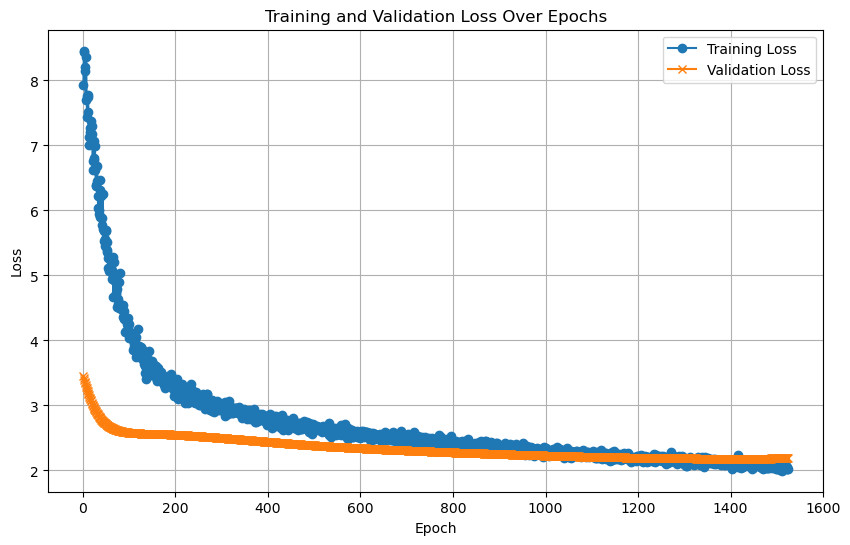

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/579], Loss: 4.4967


Test Batch [20/579], Loss: 4.3808
Test Batch [30/579], Loss: 4.5415
Test Batch [40/579], Loss: 4.6542
Test Batch [50/579], Loss: 4.4284
Test Batch [60/579], Loss: 4.5035
Test Batch [70/579], Loss: 4.4375
Test Batch [80/579], Loss: 4.5368
Test Batch [90/579], Loss: 4.1234
Test Batch [100/579], Loss: 4.3421
Test Batch [110/579], Loss: 4.2294
Test Batch [120/579], Loss: 4.2162
Test Batch [130/579], Loss: 4.2480
Test Batch [140/579], Loss: 4.2033
Test Batch [150/579], Loss: 4.2386


Test Batch [160/579], Loss: 4.3703
Test Batch [170/579], Loss: 4.4293
Test Batch [180/579], Loss: 4.2183
Test Batch [190/579], Loss: 4.4404
Test Batch [200/579], Loss: 4.6546
Test Batch [210/579], Loss: 4.6360
Test Batch [220/579], Loss: 4.7085
Test Batch [230/579], Loss: 4.6471
Test Batch [240/579], Loss: 4.8719
Test Batch [250/579], Loss: 4.6601
Test Batch [260/579], Loss: 4.7757
Test Batch [270/579], Loss: 4.6344
Test Batch [280/579], Loss: 4.1978
Test Batch [290/579], Loss: 4.7575


Test Batch [300/579], Loss: 4.7675
Test Batch [310/579], Loss: 5.0514
Test Batch [320/579], Loss: 4.7827
Test Batch [330/579], Loss: 4.8397
Test Batch [340/579], Loss: 5.3625
Test Batch [350/579], Loss: 5.1758
Test Batch [360/579], Loss: 4.8530
Test Batch [370/579], Loss: 5.2515
Test Batch [380/579], Loss: 4.1344
Test Batch [390/579], Loss: 4.9051
Test Batch [400/579], Loss: 4.7040
Test Batch [410/579], Loss: 4.6874
Test Batch [420/579], Loss: 4.8108
Test Batch [430/579], Loss: 4.7914


Test Batch [440/579], Loss: 4.8164
Test Batch [450/579], Loss: 4.7432
Test Batch [460/579], Loss: 4.8509
Test Batch [470/579], Loss: 4.7445
Test Batch [480/579], Loss: 4.1712
Test Batch [490/579], Loss: 5.0931
Test Batch [500/579], Loss: 4.8142
Test Batch [510/579], Loss: 4.9594
Test Batch [520/579], Loss: 5.5481
Test Batch [530/579], Loss: 5.1028
Test Batch [540/579], Loss: 4.3187
Test Batch [550/579], Loss: 4.2179
Test Batch [560/579], Loss: 4.2187
Test Batch [570/579], Loss: 4.3310



Test Loss: 4.6007


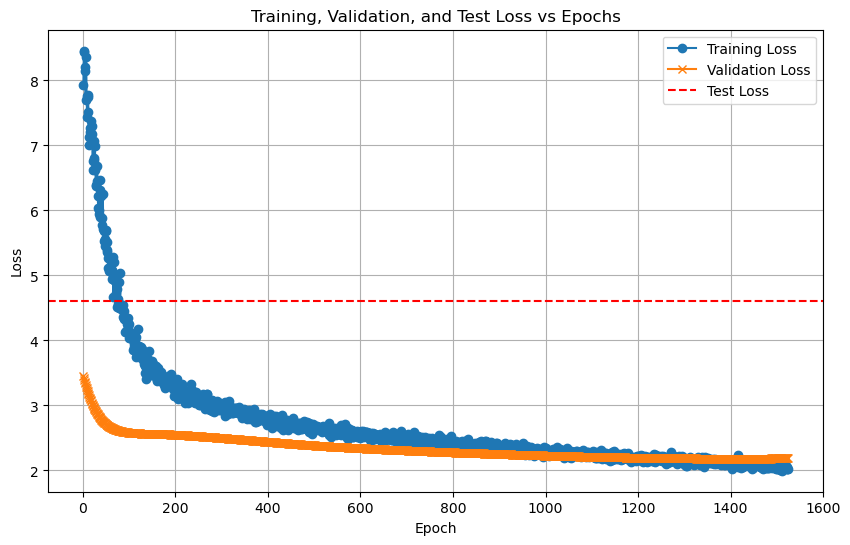

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/579 for test dataset.
  Processed batch 20/579 for test dataset.


  Processed batch 30/579 for test dataset.
  Processed batch 40/579 for test dataset.
  Processed batch 50/579 for test dataset.


  Processed batch 60/579 for test dataset.
  Processed batch 70/579 for test dataset.
  Processed batch 80/579 for test dataset.


  Processed batch 90/579 for test dataset.
  Processed batch 100/579 for test dataset.
  Processed batch 110/579 for test dataset.


  Processed batch 120/579 for test dataset.
  Processed batch 130/579 for test dataset.
  Processed batch 140/579 for test dataset.


  Processed batch 150/579 for test dataset.
  Processed batch 160/579 for test dataset.
  Processed batch 170/579 for test dataset.


  Processed batch 180/579 for test dataset.
  Processed batch 190/579 for test dataset.
  Processed batch 200/579 for test dataset.


  Processed batch 210/579 for test dataset.
  Processed batch 220/579 for test dataset.
  Processed batch 230/579 for test dataset.


  Processed batch 240/579 for test dataset.
  Processed batch 250/579 for test dataset.
  Processed batch 260/579 for test dataset.


  Processed batch 270/579 for test dataset.
  Processed batch 280/579 for test dataset.
  Processed batch 290/579 for test dataset.


  Processed batch 300/579 for test dataset.
  Processed batch 310/579 for test dataset.
  Processed batch 320/579 for test dataset.


  Processed batch 330/579 for test dataset.
  Processed batch 340/579 for test dataset.
  Processed batch 350/579 for test dataset.
  Processed batch 360/579 for test dataset.


  Processed batch 370/579 for test dataset.
  Processed batch 380/579 for test dataset.


  Processed batch 390/579 for test dataset.
  Processed batch 400/579 for test dataset.
  Processed batch 410/579 for test dataset.
  Processed batch 420/579 for test dataset.


  Processed batch 430/579 for test dataset.
  Processed batch 440/579 for test dataset.
  Processed batch 450/579 for test dataset.


  Processed batch 460/579 for test dataset.
  Processed batch 470/579 for test dataset.
  Processed batch 480/579 for test dataset.


  Processed batch 490/579 for test dataset.
  Processed batch 500/579 for test dataset.
  Processed batch 510/579 for test dataset.


  Processed batch 520/579 for test dataset.
  Processed batch 530/579 for test dataset.
  Processed batch 540/579 for test dataset.


  Processed batch 550/579 for test dataset.
  Processed batch 560/579 for test dataset.
  Processed batch 570/579 for test dataset.


Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148062, 128)
Test labels shape: (148062,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 93.33%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      0.80      0.80         5
           2       0.80      0.80      0.80         5
           3       1.00      0.80      0.89         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45


LOG: Evaluating on the test set...
Test Accuracy: 90.43%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     65961
           1       0.93      0.90      0.92      7588
           2       0.62      0.84      0.71      3080
           3       0.63      0.71      0.67      2675
           4       0.57      0.90      0.70      6574
           5       0.61      0.91      0.73      9238
           6       0.89      0.87      0.88      7277
           7       1.00      0.79      0.88     42816
           8       0.99      0.99      0.99      2853

    accuracy                           0.90    148062
   macro avg       0.80      0.88      0.83    148062
weighted avg       0.93      0.90      0.91    148062

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148062, 128)
Test labels shape: (148062,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3486  |  Val Loss: 2.4404
Validation loss improved from inf to 2.4404.
[Epoch 2/1000] Train Loss: 2.3311  |  Val Loss: 2.4216
Validation loss improved from 2.4404 to 2.4216.
[Epoch 3/1000] Train Loss: 2.3138  |  Val Loss: 2.4030
Validation loss improved from 2.4216 to 2.4030.
[Epoch 4/1000] Train Loss: 2.2967  |  Val Loss: 2.3847
Validation loss improved from 2.4030 to 2.3847.
[Epoch 5/1000] Train Loss: 2.2797  |  Val Loss: 2.3666
Validation loss improved from 2.3847 to 2.3666.
[Epoch 6/1000] Train Loss: 2.2632  |  Val Loss: 2.3486
Validation loss improved from 2.3666 to 2.3486.
[Epoch 7/1000] Train Loss: 2.2468  |  Val Loss: 2.3308
Validation loss improved from 2.3486 to 2.3308.
[Epoch 8/1000] Train Loss: 2.2309  |  Val Loss: 2.3133
Validation loss improved from 2.3308 to 2.3133.
[Epoch 9/1000] Train Loss: 2.2153  |  Val Loss: 2.2959
Validation loss improved from 2.3133 to 2.2959.
[Epoch 10/1000] Train Loss: 2.1999  |  Val Loss: 2.2789
Validation loss impr

[Epoch 60/1000] Train Loss: 1.7397  |  Val Loss: 1.7567
Validation loss improved from 1.7633 to 1.7567.
[Epoch 61/1000] Train Loss: 1.7335  |  Val Loss: 1.7502
Validation loss improved from 1.7567 to 1.7502.
[Epoch 62/1000] Train Loss: 1.7273  |  Val Loss: 1.7437
Validation loss improved from 1.7502 to 1.7437.
[Epoch 63/1000] Train Loss: 1.7211  |  Val Loss: 1.7372
Validation loss improved from 1.7437 to 1.7372.
[Epoch 64/1000] Train Loss: 1.7151  |  Val Loss: 1.7307
Validation loss improved from 1.7372 to 1.7307.
[Epoch 65/1000] Train Loss: 1.7090  |  Val Loss: 1.7243
Validation loss improved from 1.7307 to 1.7243.
[Epoch 66/1000] Train Loss: 1.7030  |  Val Loss: 1.7180
Validation loss improved from 1.7243 to 1.7180.
[Epoch 67/1000] Train Loss: 1.6970  |  Val Loss: 1.7116
Validation loss improved from 1.7180 to 1.7116.
[Epoch 68/1000] Train Loss: 1.6911  |  Val Loss: 1.7053
Validation loss improved from 1.7116 to 1.7053.
[Epoch 69/1000] Train Loss: 1.6851  |  Val Loss: 1.6989
Validati

[Epoch 134/1000] Train Loss: 1.3306  |  Val Loss: 1.3534
Validation loss improved from 1.3581 to 1.3534.
[Epoch 135/1000] Train Loss: 1.3254  |  Val Loss: 1.3486
Validation loss improved from 1.3534 to 1.3486.
[Epoch 136/1000] Train Loss: 1.3202  |  Val Loss: 1.3438
Validation loss improved from 1.3486 to 1.3438.
[Epoch 137/1000] Train Loss: 1.3151  |  Val Loss: 1.3391
Validation loss improved from 1.3438 to 1.3391.
[Epoch 138/1000] Train Loss: 1.3099  |  Val Loss: 1.3344
Validation loss improved from 1.3391 to 1.3344.
[Epoch 139/1000] Train Loss: 1.3048  |  Val Loss: 1.3297
Validation loss improved from 1.3344 to 1.3297.
[Epoch 140/1000] Train Loss: 1.2997  |  Val Loss: 1.3250
Validation loss improved from 1.3297 to 1.3250.
[Epoch 141/1000] Train Loss: 1.2945  |  Val Loss: 1.3203
Validation loss improved from 1.3250 to 1.3203.
[Epoch 142/1000] Train Loss: 1.2894  |  Val Loss: 1.3156
Validation loss improved from 1.3203 to 1.3156.
[Epoch 143/1000] Train Loss: 1.2843  |  Val Loss: 1.311

[Epoch 204/1000] Train Loss: 0.9956  |  Val Loss: 1.0587
Validation loss improved from 1.0625 to 1.0587.
[Epoch 205/1000] Train Loss: 0.9910  |  Val Loss: 1.0549
Validation loss improved from 1.0587 to 1.0549.
[Epoch 206/1000] Train Loss: 0.9864  |  Val Loss: 1.0511
Validation loss improved from 1.0549 to 1.0511.
[Epoch 207/1000] Train Loss: 0.9819  |  Val Loss: 1.0472
Validation loss improved from 1.0511 to 1.0472.
[Epoch 208/1000] Train Loss: 0.9773  |  Val Loss: 1.0434
Validation loss improved from 1.0472 to 1.0434.
[Epoch 209/1000] Train Loss: 0.9727  |  Val Loss: 1.0395
Validation loss improved from 1.0434 to 1.0395.
[Epoch 210/1000] Train Loss: 0.9680  |  Val Loss: 1.0356
Validation loss improved from 1.0395 to 1.0356.
[Epoch 211/1000] Train Loss: 0.9634  |  Val Loss: 1.0317
Validation loss improved from 1.0356 to 1.0317.
[Epoch 212/1000] Train Loss: 0.9587  |  Val Loss: 1.0277
Validation loss improved from 1.0317 to 1.0277.
[Epoch 213/1000] Train Loss: 0.9540  |  Val Loss: 1.023

[Epoch 275/1000] Train Loss: 0.6759  |  Val Loss: 0.8006
Validation loss improved from 0.8037 to 0.8006.
[Epoch 276/1000] Train Loss: 0.6717  |  Val Loss: 0.7975
Validation loss improved from 0.8006 to 0.7975.
[Epoch 277/1000] Train Loss: 0.6676  |  Val Loss: 0.7944
Validation loss improved from 0.7975 to 0.7944.
[Epoch 278/1000] Train Loss: 0.6635  |  Val Loss: 0.7913
Validation loss improved from 0.7944 to 0.7913.
[Epoch 279/1000] Train Loss: 0.6595  |  Val Loss: 0.7882
Validation loss improved from 0.7913 to 0.7882.
[Epoch 280/1000] Train Loss: 0.6554  |  Val Loss: 0.7851
Validation loss improved from 0.7882 to 0.7851.
[Epoch 281/1000] Train Loss: 0.6513  |  Val Loss: 0.7820
Validation loss improved from 0.7851 to 0.7820.
[Epoch 282/1000] Train Loss: 0.6473  |  Val Loss: 0.7789
Validation loss improved from 0.7820 to 0.7789.
[Epoch 283/1000] Train Loss: 0.6433  |  Val Loss: 0.7758
Validation loss improved from 0.7789 to 0.7758.
[Epoch 284/1000] Train Loss: 0.6393  |  Val Loss: 0.772

[Epoch 354/1000] Train Loss: 0.3935  |  Val Loss: 0.5925
Validation loss improved from 0.5945 to 0.5925.
[Epoch 355/1000] Train Loss: 0.3905  |  Val Loss: 0.5904
Validation loss improved from 0.5925 to 0.5904.
[Epoch 356/1000] Train Loss: 0.3876  |  Val Loss: 0.5886
Validation loss improved from 0.5904 to 0.5886.
[Epoch 357/1000] Train Loss: 0.3846  |  Val Loss: 0.5867
Validation loss improved from 0.5886 to 0.5867.
[Epoch 358/1000] Train Loss: 0.3817  |  Val Loss: 0.5849
Validation loss improved from 0.5867 to 0.5849.
[Epoch 359/1000] Train Loss: 0.3788  |  Val Loss: 0.5831
Validation loss improved from 0.5849 to 0.5831.
[Epoch 360/1000] Train Loss: 0.3759  |  Val Loss: 0.5812
Validation loss improved from 0.5831 to 0.5812.
[Epoch 361/1000] Train Loss: 0.3730  |  Val Loss: 0.5794
Validation loss improved from 0.5812 to 0.5794.
[Epoch 362/1000] Train Loss: 0.3702  |  Val Loss: 0.5777
Validation loss improved from 0.5794 to 0.5777.
[Epoch 363/1000] Train Loss: 0.3673  |  Val Loss: 0.576

[Epoch 430/1000] Train Loss: 0.2179  |  Val Loss: 0.4807
Validation loss improved from 0.4817 to 0.4807.
[Epoch 431/1000] Train Loss: 0.2163  |  Val Loss: 0.4797
Validation loss improved from 0.4807 to 0.4797.
[Epoch 432/1000] Train Loss: 0.2147  |  Val Loss: 0.4788
Validation loss improved from 0.4797 to 0.4788.
[Epoch 433/1000] Train Loss: 0.2131  |  Val Loss: 0.4778
Validation loss improved from 0.4788 to 0.4778.
[Epoch 434/1000] Train Loss: 0.2116  |  Val Loss: 0.4769
Validation loss improved from 0.4778 to 0.4769.
[Epoch 435/1000] Train Loss: 0.2100  |  Val Loss: 0.4759
Validation loss improved from 0.4769 to 0.4759.
[Epoch 436/1000] Train Loss: 0.2085  |  Val Loss: 0.4750
Validation loss improved from 0.4759 to 0.4750.
[Epoch 437/1000] Train Loss: 0.2069  |  Val Loss: 0.4741
Validation loss improved from 0.4750 to 0.4741.
[Epoch 438/1000] Train Loss: 0.2054  |  Val Loss: 0.4732
Validation loss improved from 0.4741 to 0.4732.
[Epoch 439/1000] Train Loss: 0.2039  |  Val Loss: 0.472

[Epoch 500/1000] Train Loss: 0.1336  |  Val Loss: 0.4329
Validation loss improved from 0.4333 to 0.4329.
[Epoch 501/1000] Train Loss: 0.1327  |  Val Loss: 0.4326
Validation loss improved from 0.4329 to 0.4326.
[Epoch 502/1000] Train Loss: 0.1318  |  Val Loss: 0.4322
Validation loss improved from 0.4326 to 0.4322.
[Epoch 503/1000] Train Loss: 0.1310  |  Val Loss: 0.4318
Validation loss improved from 0.4322 to 0.4318.
[Epoch 504/1000] Train Loss: 0.1301  |  Val Loss: 0.4314
Validation loss improved from 0.4318 to 0.4314.
[Epoch 505/1000] Train Loss: 0.1293  |  Val Loss: 0.4310
Validation loss improved from 0.4314 to 0.4310.
[Epoch 506/1000] Train Loss: 0.1284  |  Val Loss: 0.4307
Validation loss improved from 0.4310 to 0.4307.
[Epoch 507/1000] Train Loss: 0.1276  |  Val Loss: 0.4303
Validation loss improved from 0.4307 to 0.4303.
[Epoch 508/1000] Train Loss: 0.1268  |  Val Loss: 0.4299
Validation loss improved from 0.4303 to 0.4299.
[Epoch 509/1000] Train Loss: 0.1260  |  Val Loss: 0.429

[Epoch 565/1000] Train Loss: 0.0891  |  Val Loss: 0.4144
Validation loss improved from 0.4147 to 0.4144.
[Epoch 566/1000] Train Loss: 0.0886  |  Val Loss: 0.4142
Validation loss improved from 0.4144 to 0.4142.
[Epoch 567/1000] Train Loss: 0.0880  |  Val Loss: 0.4140
Validation loss improved from 0.4142 to 0.4140.
[Epoch 568/1000] Train Loss: 0.0875  |  Val Loss: 0.4138
Validation loss improved from 0.4140 to 0.4138.
[Epoch 569/1000] Train Loss: 0.0870  |  Val Loss: 0.4136
Validation loss improved from 0.4138 to 0.4136.
[Epoch 570/1000] Train Loss: 0.0865  |  Val Loss: 0.4134
Validation loss improved from 0.4136 to 0.4134.
[Epoch 571/1000] Train Loss: 0.0860  |  Val Loss: 0.4132
Validation loss improved from 0.4134 to 0.4132.
[Epoch 572/1000] Train Loss: 0.0855  |  Val Loss: 0.4130
Validation loss improved from 0.4132 to 0.4130.
[Epoch 573/1000] Train Loss: 0.0850  |  Val Loss: 0.4128
Validation loss improved from 0.4130 to 0.4128.
[Epoch 574/1000] Train Loss: 0.0845  |  Val Loss: 0.412

[Epoch 636/1000] Train Loss: 0.0602  |  Val Loss: 0.4112
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 637/1000] Train Loss: 0.0599  |  Val Loss: 0.4112
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 638/1000] Train Loss: 0.0596  |  Val Loss: 0.4112
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 639/1000] Train Loss: 0.0593  |  Val Loss: 0.4112
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 640/1000] Train Loss: 0.0590  |  Val Loss: 0.4112
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 641/1000] Train Loss: 0.0587  |  Val Loss: 0.4113
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 642/1000] Train Loss: 0.0584  |  Val Loss: 0.4113
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 643/1000] Train Loss: 0.0581  |  Val Loss: 0.4114
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 644/1000] Train Loss: 0.0578  |  Val Loss: 0.4114
!! Validation loss did NOT improve !! Patience: 1

[Epoch 711/1000] Train Loss: 0.0423  |  Val Loss: 0.4153
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 712/1000] Train Loss: 0.0421  |  Val Loss: 0.4154
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 713/1000] Train Loss: 0.0419  |  Val Loss: 0.4155
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 714/1000] Train Loss: 0.0417  |  Val Loss: 0.4156
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 715/1000] Train Loss: 0.0415  |  Val Loss: 0.4157
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 716/1000] Train Loss: 0.0414  |  Val Loss: 0.4158
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 717/1000] Train Loss: 0.0412  |  Val Loss: 0.4159
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 718/1000] Train Loss: 0.0410  |  Val Loss: 0.4160
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 719/1000] Train Loss: 0.0408  |  Val Loss: 0.4161
!! Validation loss did NOT improve !! Patience:

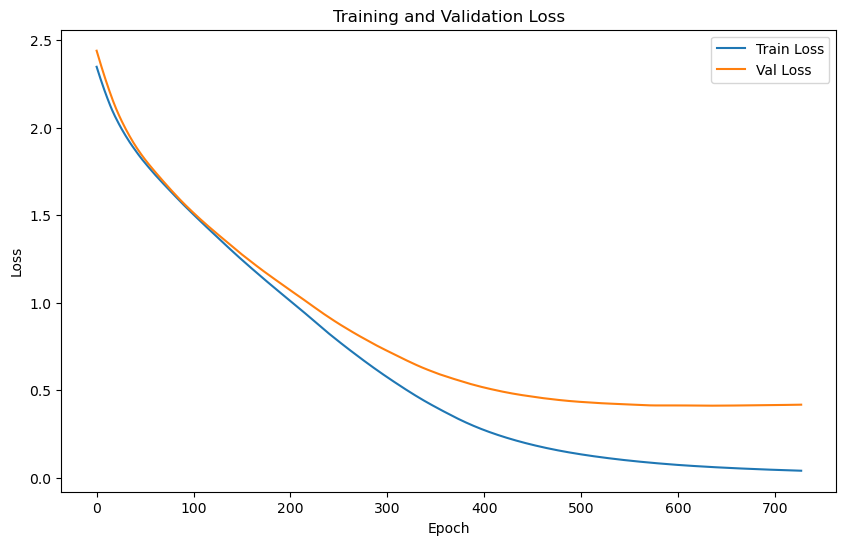

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.3173 | Test Accuracy: 89.04%


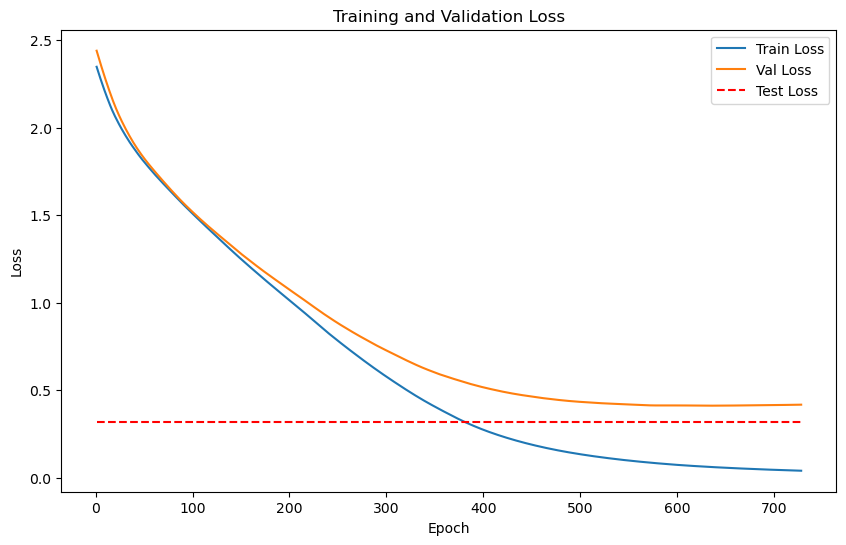

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148062 samples with 64 features each
LOG: Labels shape: (148062,)


Train embeddings shape: (45, 64), 
Train labels shape: (45,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (148062, 64), 
Test labels shape: (148062,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Training batch size: 45


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.3893
Epoch [1/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.3893

Validation loss improved from inf to 0.3893. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 0.4549
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.3890
Epoch [2/2000], Avg Train Loss: 0.4549, Avg Val Loss: 0.3890

Validation loss improved from 0.3893 to 0.3890. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [3/2000] - Validation


    Batch [1/1], Val Loss: 0.3884
Epoch [3/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.3884

Validation loss improved from 0.3890 to 0.3884. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.4591
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.3879
Epoch [4/2000], Avg Train Loss: 0.4591, Avg Val Loss: 0.3879

Validation loss improved from 0.3884 to 0.3879. Saving model...
LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.3882
Epoch [5/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.3882

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4531
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.3883
Epoch [6/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.3883

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [7/2000] - Validation
    Batch [1/1], Val Loss: 0.3890
Epoch [7/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.3890

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [8/2000] - Validation


    Batch [1/1], Val Loss: 0.3896
Epoch [8/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.3896

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.4424
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.3899
Epoch [9/2000], Avg Train Loss: 0.4424, Avg Val Loss: 0.3899

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.4444
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.3902
Epoch [10/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.3902

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4467
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.3905
Epoch [11/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.3905

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 0.4270
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.3905
Epoch [12/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.3905

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.3905
Epoch [13/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.3905

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4453
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.3903
Epoch [14/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.3903

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.4285
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.3900
Epoch [15/2000], Avg Train Loss: 0.4285, Avg Val Loss: 0.3900

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4317
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.3897
Epoch [16/2000], Avg Train Loss: 0.4317, Avg Val Loss: 0.3897

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.3895
Epoch [17/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.3895

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4416
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.3892
Epoch [18/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.3892

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.4325
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.3888
Epoch [19/2000], Avg Train Loss: 0.4325, Avg Val Loss: 0.3888

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4285
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.3884
Epoch [20/2000], Avg Train Loss: 0.4285, Avg Val Loss: 0.3884

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.4257
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.3881
Epoch [21/2000], Avg Train Loss: 0.4257, Avg Val Loss: 0.3881

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4218
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.3877
Epoch [22/2000], Avg Train Loss: 0.4218, Avg Val Loss: 0.3877

Validation loss improved from 0.3879 to 0.3877. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.4278
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.3873
Epoch [23/2000], Avg Train Loss: 0.4278, Avg Val Loss: 0.3873

Validation loss improved from 0.3877 to 0.3873. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.4257
LOG: Epoch [24/2000] - Validation


    Batch [1/1], Val Loss: 0.3868
Epoch [24/2000], Avg Train Loss: 0.4257, Avg Val Loss: 0.3868

Validation loss improved from 0.3873 to 0.3868. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.4224
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.3864
Epoch [25/2000], Avg Train Loss: 0.4224, Avg Val Loss: 0.3864

Validation loss improved from 0.3868 to 0.3864. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.4160
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.3860
Epoch [26/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.3860

Validation loss improved from 0.3864 to 0.3860. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4242
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.3855
Epoch [27/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.3855

Validation loss improved from 0.3860 to 0.3855. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4313
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.3851
Epoch [28/2000], Avg Train Loss: 0.4313, Avg Val Loss: 0.3851

Validation loss improved from 0.3855 to 0.3851. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4195
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.3847
Epoch [29/2000], Avg Train Loss: 0.4195, Avg Val Loss: 0.3847

Validation loss improved from 0.3851 to 0.3847. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.4161
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.3843
Epoch [30/2000], Avg Train Loss: 0.4161, Avg Val Loss: 0.3843

Validation loss improved from 0.3847 to 0.3843. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.4234
LOG: Epoch [31/2000] - Validation


    Batch [1/1], Val Loss: 0.3839
Epoch [31/2000], Avg Train Loss: 0.4234, Avg Val Loss: 0.3839

Validation loss improved from 0.3843 to 0.3839. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.4218
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.3835
Epoch [32/2000], Avg Train Loss: 0.4218, Avg Val Loss: 0.3835

Validation loss improved from 0.3839 to 0.3835. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.4122
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.3831
Epoch [33/2000], Avg Train Loss: 0.4122, Avg Val Loss: 0.3831

Validation loss improved from 0.3835 to 0.3831. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.3827
Epoch [34/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.3827

Validation loss improved from 0.3831 to 0.3827. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.4147
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.3823
Epoch [35/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.3823

Validation loss improved from 0.3827 to 0.3823. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.4091
LOG: Epoch [36/2000] - Validation


    Batch [1/1], Val Loss: 0.3819
Epoch [36/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.3819

Validation loss improved from 0.3823 to 0.3819. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.4105
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.3815
Epoch [37/2000], Avg Train Loss: 0.4105, Avg Val Loss: 0.3815

Validation loss improved from 0.3819 to 0.3815. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.4071
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.3811
Epoch [38/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.3811

Validation loss improved from 0.3815 to 0.3811. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.3807
Epoch [39/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.3807

Validation loss improved from 0.3811 to 0.3807. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.3803
Epoch [40/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.3803

Validation loss improved from 0.3807 to 0.3803. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [41/2000] - Validation


    Batch [1/1], Val Loss: 0.3799
Epoch [41/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.3799

Validation loss improved from 0.3803 to 0.3799. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.3795
Epoch [42/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.3795

Validation loss improved from 0.3799 to 0.3795. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.4138
LOG: Epoch [43/2000] - Validation


    Batch [1/1], Val Loss: 0.3791
Epoch [43/2000], Avg Train Loss: 0.4138, Avg Val Loss: 0.3791

Validation loss improved from 0.3795 to 0.3791. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.3787
Epoch [44/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.3787

Validation loss improved from 0.3791 to 0.3787. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.3784
Epoch [45/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.3784

Validation loss improved from 0.3787 to 0.3784. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.3780
Epoch [46/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.3780

Validation loss improved from 0.3784 to 0.3780. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.3776
Epoch [47/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.3776

Validation loss improved from 0.3780 to 0.3776. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [48/2000] - Validation


    Batch [1/1], Val Loss: 0.3772
Epoch [48/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.3772

Validation loss improved from 0.3776 to 0.3772. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.3986
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.3769
Epoch [49/2000], Avg Train Loss: 0.3986, Avg Val Loss: 0.3769

Validation loss improved from 0.3772 to 0.3769. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.3857
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3765
Epoch [50/2000], Avg Train Loss: 0.3857, Avg Val Loss: 0.3765

Validation loss improved from 0.3769 to 0.3765. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.3762
Epoch [51/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.3762

Validation loss improved from 0.3765 to 0.3762. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.3758
Epoch [52/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.3758

Validation loss improved from 0.3762 to 0.3758. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.3789
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.3754
Epoch [53/2000], Avg Train Loss: 0.3789, Avg Val Loss: 0.3754

Validation loss improved from 0.3758 to 0.3754. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.3750
Epoch [54/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.3750

Validation loss improved from 0.3754 to 0.3750. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.3747
Epoch [55/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.3747

Validation loss improved from 0.3750 to 0.3747. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [56/2000] - Validation
    Batch [1/1], Val Loss: 0.3743
Epoch [56/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.3743

Validation loss improved from 0.3747 to 0.3743. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.3860
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.3739
Epoch [57/2000], Avg Train Loss: 0.3860, Avg Val Loss: 0.3739

Validation loss improved from 0.3743 to 0.3739. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.3763
LOG: Epoch [58/2000] - Validation


    Batch [1/1], Val Loss: 0.3735
Epoch [58/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.3735

Validation loss improved from 0.3739 to 0.3735. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.3760
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [59/2000], Avg Train Loss: 0.3760, Avg Val Loss: 0.3732

Validation loss improved from 0.3735 to 0.3732. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.3716
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.3728
Epoch [60/2000], Avg Train Loss: 0.3716, Avg Val Loss: 0.3728

Validation loss improved from 0.3732 to 0.3728. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.3807
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.3725
Epoch [61/2000], Avg Train Loss: 0.3807, Avg Val Loss: 0.3725

Validation loss improved from 0.3728 to 0.3725. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.3745
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.3721
Epoch [62/2000], Avg Train Loss: 0.3745, Avg Val Loss: 0.3721

Validation loss improved from 0.3725 to 0.3721. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.3815
LOG: Epoch [63/2000] - Validation


    Batch [1/1], Val Loss: 0.3717
Epoch [63/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.3717

Validation loss improved from 0.3721 to 0.3717. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.3714
Epoch [64/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.3714

Validation loss improved from 0.3717 to 0.3714. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.3761
LOG: Epoch [65/2000] - Validation


    Batch [1/1], Val Loss: 0.3710
Epoch [65/2000], Avg Train Loss: 0.3761, Avg Val Loss: 0.3710

Validation loss improved from 0.3714 to 0.3710. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.3842
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.3707
Epoch [66/2000], Avg Train Loss: 0.3842, Avg Val Loss: 0.3707

Validation loss improved from 0.3710 to 0.3707. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.3703
Epoch [67/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.3703

Validation loss improved from 0.3707 to 0.3703. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.3791
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.3699
Epoch [68/2000], Avg Train Loss: 0.3791, Avg Val Loss: 0.3699

Validation loss improved from 0.3703 to 0.3699. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.3741
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.3696
Epoch [69/2000], Avg Train Loss: 0.3741, Avg Val Loss: 0.3696

Validation loss improved from 0.3699 to 0.3696. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.3700
LOG: Epoch [70/2000] - Validation


    Batch [1/1], Val Loss: 0.3692
Epoch [70/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.3692

Validation loss improved from 0.3696 to 0.3692. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.3689
Epoch [71/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.3689

Validation loss improved from 0.3692 to 0.3689. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.3686
Epoch [72/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.3686

Validation loss improved from 0.3689 to 0.3686. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.3737
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.3682
Epoch [73/2000], Avg Train Loss: 0.3737, Avg Val Loss: 0.3682

Validation loss improved from 0.3686 to 0.3682. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.3679
Epoch [74/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.3679

Validation loss improved from 0.3682 to 0.3679. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.3676
Epoch [75/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.3676

Validation loss improved from 0.3679 to 0.3676. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.3673
Epoch [76/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.3673

Validation loss improved from 0.3676 to 0.3673. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.3572
LOG: Epoch [77/2000] - Validation


    Batch [1/1], Val Loss: 0.3670
Epoch [77/2000], Avg Train Loss: 0.3572, Avg Val Loss: 0.3670

Validation loss improved from 0.3673 to 0.3670. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.3633
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.3667
Epoch [78/2000], Avg Train Loss: 0.3633, Avg Val Loss: 0.3667

Validation loss improved from 0.3670 to 0.3667. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.3664
Epoch [79/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.3664

Validation loss improved from 0.3667 to 0.3664. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.3624
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.3661
Epoch [80/2000], Avg Train Loss: 0.3624, Avg Val Loss: 0.3661

Validation loss improved from 0.3664 to 0.3661. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.3571
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.3658
Epoch [81/2000], Avg Train Loss: 0.3571, Avg Val Loss: 0.3658

Validation loss improved from 0.3661 to 0.3658. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.3505
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.3655
Epoch [82/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.3655

Validation loss improved from 0.3658 to 0.3655. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.3589
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.3652
Epoch [83/2000], Avg Train Loss: 0.3589, Avg Val Loss: 0.3652

Validation loss improved from 0.3655 to 0.3652. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.3649
Epoch [84/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.3649

Validation loss improved from 0.3652 to 0.3649. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.3561
LOG: Epoch [85/2000] - Validation


    Batch [1/1], Val Loss: 0.3646
Epoch [85/2000], Avg Train Loss: 0.3561, Avg Val Loss: 0.3646

Validation loss improved from 0.3649 to 0.3646. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.3610
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.3643
Epoch [86/2000], Avg Train Loss: 0.3610, Avg Val Loss: 0.3643

Validation loss improved from 0.3646 to 0.3643. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [87/2000] - Validation


    Batch [1/1], Val Loss: 0.3640
Epoch [87/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.3640

Validation loss improved from 0.3643 to 0.3640. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.3637
Epoch [88/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.3637

Validation loss improved from 0.3640 to 0.3637. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.3363
LOG: Epoch [89/2000] - Validation


    Batch [1/1], Val Loss: 0.3634
Epoch [89/2000], Avg Train Loss: 0.3363, Avg Val Loss: 0.3634

Validation loss improved from 0.3637 to 0.3634. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.3532
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.3631
Epoch [90/2000], Avg Train Loss: 0.3532, Avg Val Loss: 0.3631

Validation loss improved from 0.3634 to 0.3631. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.3510
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.3627
Epoch [91/2000], Avg Train Loss: 0.3510, Avg Val Loss: 0.3627

Validation loss improved from 0.3631 to 0.3627. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.3556
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.3623
Epoch [92/2000], Avg Train Loss: 0.3556, Avg Val Loss: 0.3623

Validation loss improved from 0.3627 to 0.3623. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.3507
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.3620
Epoch [93/2000], Avg Train Loss: 0.3507, Avg Val Loss: 0.3620

Validation loss improved from 0.3623 to 0.3620. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.3559
LOG: Epoch [94/2000] - Validation


    Batch [1/1], Val Loss: 0.3616
Epoch [94/2000], Avg Train Loss: 0.3559, Avg Val Loss: 0.3616

Validation loss improved from 0.3620 to 0.3616. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.3613
Epoch [95/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.3613

Validation loss improved from 0.3616 to 0.3613. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.3414
LOG: Epoch [96/2000] - Validation


    Batch [1/1], Val Loss: 0.3609
Epoch [96/2000], Avg Train Loss: 0.3414, Avg Val Loss: 0.3609

Validation loss improved from 0.3613 to 0.3609. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.3606
Epoch [97/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.3606

Validation loss improved from 0.3609 to 0.3606. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.3572
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [98/2000], Avg Train Loss: 0.3572, Avg Val Loss: 0.3602

Validation loss improved from 0.3606 to 0.3602. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.3362
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.3599
Epoch [99/2000], Avg Train Loss: 0.3362, Avg Val Loss: 0.3599

Validation loss improved from 0.3602 to 0.3599. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.3416
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.3595
Epoch [100/2000], Avg Train Loss: 0.3416, Avg Val Loss: 0.3595

Validation loss improved from 0.3599 to 0.3595. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.3344
LOG: Epoch [101/2000] - Validation


    Batch [1/1], Val Loss: 0.3592
Epoch [101/2000], Avg Train Loss: 0.3344, Avg Val Loss: 0.3592

Validation loss improved from 0.3595 to 0.3592. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.3431
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.3588
Epoch [102/2000], Avg Train Loss: 0.3431, Avg Val Loss: 0.3588

Validation loss improved from 0.3592 to 0.3588. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.3378
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.3585
Epoch [103/2000], Avg Train Loss: 0.3378, Avg Val Loss: 0.3585

Validation loss improved from 0.3588 to 0.3585. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.3363
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.3581
Epoch [104/2000], Avg Train Loss: 0.3363, Avg Val Loss: 0.3581

Validation loss improved from 0.3585 to 0.3581. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.3313
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.3578
Epoch [105/2000], Avg Train Loss: 0.3313, Avg Val Loss: 0.3578

Validation loss improved from 0.3581 to 0.3578. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.3482
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.3575
Epoch [106/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.3575

Validation loss improved from 0.3578 to 0.3575. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.3409
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.3572
Epoch [107/2000], Avg Train Loss: 0.3409, Avg Val Loss: 0.3572

Validation loss improved from 0.3575 to 0.3572. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.3378
LOG: Epoch [108/2000] - Validation


    Batch [1/1], Val Loss: 0.3569
Epoch [108/2000], Avg Train Loss: 0.3378, Avg Val Loss: 0.3569

Validation loss improved from 0.3572 to 0.3569. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.3251
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.3566
Epoch [109/2000], Avg Train Loss: 0.3251, Avg Val Loss: 0.3566

Validation loss improved from 0.3569 to 0.3566. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.3563
Epoch [110/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.3563

Validation loss improved from 0.3566 to 0.3563. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.3332
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.3560
Epoch [111/2000], Avg Train Loss: 0.3332, Avg Val Loss: 0.3560

Validation loss improved from 0.3563 to 0.3560. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.3355
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [112/2000], Avg Train Loss: 0.3355, Avg Val Loss: 0.3557

Validation loss improved from 0.3560 to 0.3557. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.3327
LOG: Epoch [113/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [113/2000], Avg Train Loss: 0.3327, Avg Val Loss: 0.3554

Validation loss improved from 0.3557 to 0.3554. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.3236
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.3552
Epoch [114/2000], Avg Train Loss: 0.3236, Avg Val Loss: 0.3552

Validation loss improved from 0.3554 to 0.3552. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.3327
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.3549
Epoch [115/2000], Avg Train Loss: 0.3327, Avg Val Loss: 0.3549

Validation loss improved from 0.3552 to 0.3549. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.3283
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [116/2000], Avg Train Loss: 0.3283, Avg Val Loss: 0.3546

Validation loss improved from 0.3549 to 0.3546. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.3283
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.3543
Epoch [117/2000], Avg Train Loss: 0.3283, Avg Val Loss: 0.3543

Validation loss improved from 0.3546 to 0.3543. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.3280
LOG: Epoch [118/2000] - Validation


    Batch [1/1], Val Loss: 0.3541
Epoch [118/2000], Avg Train Loss: 0.3280, Avg Val Loss: 0.3541

Validation loss improved from 0.3543 to 0.3541. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.3207
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.3538
Epoch [119/2000], Avg Train Loss: 0.3207, Avg Val Loss: 0.3538

Validation loss improved from 0.3541 to 0.3538. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.3227
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.3535
Epoch [120/2000], Avg Train Loss: 0.3227, Avg Val Loss: 0.3535

Validation loss improved from 0.3538 to 0.3535. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.3131
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.3532
Epoch [121/2000], Avg Train Loss: 0.3131, Avg Val Loss: 0.3532

Validation loss improved from 0.3535 to 0.3532. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.3308
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.3529
Epoch [122/2000], Avg Train Loss: 0.3308, Avg Val Loss: 0.3529

Validation loss improved from 0.3532 to 0.3529. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.3205
LOG: Epoch [123/2000] - Validation


    Batch [1/1], Val Loss: 0.3526
Epoch [123/2000], Avg Train Loss: 0.3205, Avg Val Loss: 0.3526

Validation loss improved from 0.3529 to 0.3526. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.3156
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.3523
Epoch [124/2000], Avg Train Loss: 0.3156, Avg Val Loss: 0.3523

Validation loss improved from 0.3526 to 0.3523. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.3226
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.3521
Epoch [125/2000], Avg Train Loss: 0.3226, Avg Val Loss: 0.3521

Validation loss improved from 0.3523 to 0.3521. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3144
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.3517
Epoch [126/2000], Avg Train Loss: 0.3144, Avg Val Loss: 0.3517

Validation loss improved from 0.3521 to 0.3517. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.3163
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.3514
Epoch [127/2000], Avg Train Loss: 0.3163, Avg Val Loss: 0.3514

Validation loss improved from 0.3517 to 0.3514. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.3187
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.3511
Epoch [128/2000], Avg Train Loss: 0.3187, Avg Val Loss: 0.3511

Validation loss improved from 0.3514 to 0.3511. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.3089
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.3508
Epoch [129/2000], Avg Train Loss: 0.3089, Avg Val Loss: 0.3508

Validation loss improved from 0.3511 to 0.3508. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.3227
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.3505
Epoch [130/2000], Avg Train Loss: 0.3227, Avg Val Loss: 0.3505

Validation loss improved from 0.3508 to 0.3505. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.3214
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.3502
Epoch [131/2000], Avg Train Loss: 0.3214, Avg Val Loss: 0.3502

Validation loss improved from 0.3505 to 0.3502. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.3026
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.3499
Epoch [132/2000], Avg Train Loss: 0.3026, Avg Val Loss: 0.3499

Validation loss improved from 0.3502 to 0.3499. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.3111
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.3496
Epoch [133/2000], Avg Train Loss: 0.3111, Avg Val Loss: 0.3496

Validation loss improved from 0.3499 to 0.3496. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.3238
LOG: Epoch [134/2000] - Validation


    Batch [1/1], Val Loss: 0.3493
Epoch [134/2000], Avg Train Loss: 0.3238, Avg Val Loss: 0.3493

Validation loss improved from 0.3496 to 0.3493. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.3198
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.3490
Epoch [135/2000], Avg Train Loss: 0.3198, Avg Val Loss: 0.3490

Validation loss improved from 0.3493 to 0.3490. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.3153
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.3487
Epoch [136/2000], Avg Train Loss: 0.3153, Avg Val Loss: 0.3487

Validation loss improved from 0.3490 to 0.3487. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.3023
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.3484
Epoch [137/2000], Avg Train Loss: 0.3023, Avg Val Loss: 0.3484

Validation loss improved from 0.3487 to 0.3484. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.3128
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.3481
Epoch [138/2000], Avg Train Loss: 0.3128, Avg Val Loss: 0.3481

Validation loss improved from 0.3484 to 0.3481. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.3097
LOG: Epoch [139/2000] - Validation


    Batch [1/1], Val Loss: 0.3478
Epoch [139/2000], Avg Train Loss: 0.3097, Avg Val Loss: 0.3478

Validation loss improved from 0.3481 to 0.3478. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.3189
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.3475
Epoch [140/2000], Avg Train Loss: 0.3189, Avg Val Loss: 0.3475

Validation loss improved from 0.3478 to 0.3475. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.3245
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.3472
Epoch [141/2000], Avg Train Loss: 0.3245, Avg Val Loss: 0.3472

Validation loss improved from 0.3475 to 0.3472. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.3130
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.3469
Epoch [142/2000], Avg Train Loss: 0.3130, Avg Val Loss: 0.3469

Validation loss improved from 0.3472 to 0.3469. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.2973
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.3466
Epoch [143/2000], Avg Train Loss: 0.2973, Avg Val Loss: 0.3466

Validation loss improved from 0.3469 to 0.3466. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.3048
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.3464
Epoch [144/2000], Avg Train Loss: 0.3048, Avg Val Loss: 0.3464

Validation loss improved from 0.3466 to 0.3464. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.2880
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.3461
Epoch [145/2000], Avg Train Loss: 0.2880, Avg Val Loss: 0.3461

Validation loss improved from 0.3464 to 0.3461. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.2991
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.3458
Epoch [146/2000], Avg Train Loss: 0.2991, Avg Val Loss: 0.3458

Validation loss improved from 0.3461 to 0.3458. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.2987
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.3455
Epoch [147/2000], Avg Train Loss: 0.2987, Avg Val Loss: 0.3455

Validation loss improved from 0.3458 to 0.3455. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3177
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.3453
Epoch [148/2000], Avg Train Loss: 0.3177, Avg Val Loss: 0.3453

Validation loss improved from 0.3455 to 0.3453. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.3040
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.3450
Epoch [149/2000], Avg Train Loss: 0.3040, Avg Val Loss: 0.3450

Validation loss improved from 0.3453 to 0.3450. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.2948
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.3448
Epoch [150/2000], Avg Train Loss: 0.2948, Avg Val Loss: 0.3448

Validation loss improved from 0.3450 to 0.3448. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.3008
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.3445
Epoch [151/2000], Avg Train Loss: 0.3008, Avg Val Loss: 0.3445

Validation loss improved from 0.3448 to 0.3445. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.3086
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.3442
Epoch [152/2000], Avg Train Loss: 0.3086, Avg Val Loss: 0.3442

Validation loss improved from 0.3445 to 0.3442. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.3058
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.3440
Epoch [153/2000], Avg Train Loss: 0.3058, Avg Val Loss: 0.3440

Validation loss improved from 0.3442 to 0.3440. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.3071
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.3437
Epoch [154/2000], Avg Train Loss: 0.3071, Avg Val Loss: 0.3437

Validation loss improved from 0.3440 to 0.3437. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.2990
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.3434
Epoch [155/2000], Avg Train Loss: 0.2990, Avg Val Loss: 0.3434

Validation loss improved from 0.3437 to 0.3434. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.3056
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.3431
Epoch [156/2000], Avg Train Loss: 0.3056, Avg Val Loss: 0.3431

Validation loss improved from 0.3434 to 0.3431. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.3016
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.3429
Epoch [157/2000], Avg Train Loss: 0.3016, Avg Val Loss: 0.3429

Validation loss improved from 0.3431 to 0.3429. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.2991
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.3426
Epoch [158/2000], Avg Train Loss: 0.2991, Avg Val Loss: 0.3426

Validation loss improved from 0.3429 to 0.3426. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.2846
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.3424
Epoch [159/2000], Avg Train Loss: 0.2846, Avg Val Loss: 0.3424

Validation loss improved from 0.3426 to 0.3424. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.2878
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.3421
Epoch [160/2000], Avg Train Loss: 0.2878, Avg Val Loss: 0.3421

Validation loss improved from 0.3424 to 0.3421. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.3419
Epoch [161/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.3419

Validation loss improved from 0.3421 to 0.3419. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.2847
LOG: Epoch [162/2000] - Validation


    Batch [1/1], Val Loss: 0.3417
Epoch [162/2000], Avg Train Loss: 0.2847, Avg Val Loss: 0.3417

Validation loss improved from 0.3419 to 0.3417. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.2944
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.3415
Epoch [163/2000], Avg Train Loss: 0.2944, Avg Val Loss: 0.3415

Validation loss improved from 0.3417 to 0.3415. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.3017
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.3413
Epoch [164/2000], Avg Train Loss: 0.3017, Avg Val Loss: 0.3413

Validation loss improved from 0.3415 to 0.3413. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.3129
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.3411
Epoch [165/2000], Avg Train Loss: 0.3129, Avg Val Loss: 0.3411

Validation loss improved from 0.3413 to 0.3411. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.3045
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.3408
Epoch [166/2000], Avg Train Loss: 0.3045, Avg Val Loss: 0.3408

Validation loss improved from 0.3411 to 0.3408. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.2915
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.3406
Epoch [167/2000], Avg Train Loss: 0.2915, Avg Val Loss: 0.3406

Validation loss improved from 0.3408 to 0.3406. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.2912
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.3403
Epoch [168/2000], Avg Train Loss: 0.2912, Avg Val Loss: 0.3403

Validation loss improved from 0.3406 to 0.3403. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.3083
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.3401
Epoch [169/2000], Avg Train Loss: 0.3083, Avg Val Loss: 0.3401

Validation loss improved from 0.3403 to 0.3401. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [170/2000] - Validation


    Batch [1/1], Val Loss: 0.3398
Epoch [170/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.3398

Validation loss improved from 0.3401 to 0.3398. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.2842
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.3396
Epoch [171/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.3396

Validation loss improved from 0.3398 to 0.3396. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3040
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.3393
Epoch [172/2000], Avg Train Loss: 0.3040, Avg Val Loss: 0.3393

Validation loss improved from 0.3396 to 0.3393. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.2845
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.3390
Epoch [173/2000], Avg Train Loss: 0.2845, Avg Val Loss: 0.3390

Validation loss improved from 0.3393 to 0.3390. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.2978
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.3387
Epoch [174/2000], Avg Train Loss: 0.2978, Avg Val Loss: 0.3387

Validation loss improved from 0.3390 to 0.3387. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.2937
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.3384
Epoch [175/2000], Avg Train Loss: 0.2937, Avg Val Loss: 0.3384

Validation loss improved from 0.3387 to 0.3384. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.2759
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.3381
Epoch [176/2000], Avg Train Loss: 0.2759, Avg Val Loss: 0.3381

Validation loss improved from 0.3384 to 0.3381. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.2836
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.3378
Epoch [177/2000], Avg Train Loss: 0.2836, Avg Val Loss: 0.3378

Validation loss improved from 0.3381 to 0.3378. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.3374
Epoch [178/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.3374

Validation loss improved from 0.3378 to 0.3374. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.2734
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.3371
Epoch [179/2000], Avg Train Loss: 0.2734, Avg Val Loss: 0.3371

Validation loss improved from 0.3374 to 0.3371. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.3368
Epoch [180/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.3368

Validation loss improved from 0.3371 to 0.3368. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [181/2000] - Validation
    Batch [1/1], Val Loss: 0.3365
Epoch [181/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.3365

Validation loss improved from 0.3368 to 0.3365. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.2750
LOG: Epoch [182/2000] - Validation


    Batch [1/1], Val Loss: 0.3363
Epoch [182/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.3363

Validation loss improved from 0.3365 to 0.3363. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [183/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.3360

Validation loss improved from 0.3363 to 0.3360. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [184/2000] - Validation


    Batch [1/1], Val Loss: 0.3357
Epoch [184/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.3357

Validation loss improved from 0.3360 to 0.3357. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [185/2000] - Validation
    Batch [1/1], Val Loss: 0.3354
Epoch [185/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.3354

Validation loss improved from 0.3357 to 0.3354. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [186/2000] - Validation


    Batch [1/1], Val Loss: 0.3351
Epoch [186/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.3351

Validation loss improved from 0.3354 to 0.3351. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.2860
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.3348
Epoch [187/2000], Avg Train Loss: 0.2860, Avg Val Loss: 0.3348

Validation loss improved from 0.3351 to 0.3348. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [188/2000] - Validation


    Batch [1/1], Val Loss: 0.3346
Epoch [188/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.3346

Validation loss improved from 0.3348 to 0.3346. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.2954
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.3343
Epoch [189/2000], Avg Train Loss: 0.2954, Avg Val Loss: 0.3343

Validation loss improved from 0.3346 to 0.3343. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [190/2000] - Validation


    Batch [1/1], Val Loss: 0.3341
Epoch [190/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.3341

Validation loss improved from 0.3343 to 0.3341. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.3339
Epoch [191/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.3339

Validation loss improved from 0.3341 to 0.3339. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.2532
LOG: Epoch [192/2000] - Validation


    Batch [1/1], Val Loss: 0.3337
Epoch [192/2000], Avg Train Loss: 0.2532, Avg Val Loss: 0.3337

Validation loss improved from 0.3339 to 0.3337. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.3334
Epoch [193/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.3334

Validation loss improved from 0.3337 to 0.3334. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.3333
Epoch [194/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.3333

Validation loss improved from 0.3334 to 0.3333. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.2671
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.3331
Epoch [195/2000], Avg Train Loss: 0.2671, Avg Val Loss: 0.3331

Validation loss improved from 0.3333 to 0.3331. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.3330
Epoch [196/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.3330

Validation loss improved from 0.3331 to 0.3330. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.2564
LOG: Epoch [197/2000] - Validation


    Batch [1/1], Val Loss: 0.3328
Epoch [197/2000], Avg Train Loss: 0.2564, Avg Val Loss: 0.3328

Validation loss improved from 0.3330 to 0.3328. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.2749
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.3327
Epoch [198/2000], Avg Train Loss: 0.2749, Avg Val Loss: 0.3327

Validation loss improved from 0.3328 to 0.3327. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.2734
LOG: Epoch [199/2000] - Validation


    Batch [1/1], Val Loss: 0.3325
Epoch [199/2000], Avg Train Loss: 0.2734, Avg Val Loss: 0.3325

Validation loss improved from 0.3327 to 0.3325. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.3323
Epoch [200/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.3323

Validation loss improved from 0.3325 to 0.3323. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.2626
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.3322
Epoch [201/2000], Avg Train Loss: 0.2626, Avg Val Loss: 0.3322

Validation loss improved from 0.3323 to 0.3322. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.2646
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.3320
Epoch [202/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.3320

Validation loss improved from 0.3322 to 0.3320. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.2727
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.3318
Epoch [203/2000], Avg Train Loss: 0.2727, Avg Val Loss: 0.3318

Validation loss improved from 0.3320 to 0.3318. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.2751
LOG: Epoch [204/2000] - Validation


    Batch [1/1], Val Loss: 0.3316
Epoch [204/2000], Avg Train Loss: 0.2751, Avg Val Loss: 0.3316

Validation loss improved from 0.3318 to 0.3316. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.2632
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.3315
Epoch [205/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.3315

Validation loss improved from 0.3316 to 0.3315. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [206/2000] - Validation


    Batch [1/1], Val Loss: 0.3312
Epoch [206/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.3312

Validation loss improved from 0.3315 to 0.3312. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.3310
Epoch [207/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.3310

Validation loss improved from 0.3312 to 0.3310. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.2493
LOG: Epoch [208/2000] - Validation


    Batch [1/1], Val Loss: 0.3309
Epoch [208/2000], Avg Train Loss: 0.2493, Avg Val Loss: 0.3309

Validation loss improved from 0.3310 to 0.3309. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.3307
Epoch [209/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.3307

Validation loss improved from 0.3309 to 0.3307. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.2722
LOG: Epoch [210/2000] - Validation


    Batch [1/1], Val Loss: 0.3305
Epoch [210/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.3305

Validation loss improved from 0.3307 to 0.3305. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.2645
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.3303
Epoch [211/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.3303

Validation loss improved from 0.3305 to 0.3303. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.2618
LOG: Epoch [212/2000] - Validation


    Batch [1/1], Val Loss: 0.3301
Epoch [212/2000], Avg Train Loss: 0.2618, Avg Val Loss: 0.3301

Validation loss improved from 0.3303 to 0.3301. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.2622
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.3300
Epoch [213/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.3300

Validation loss improved from 0.3301 to 0.3300. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.2435
LOG: Epoch [214/2000] - Validation


    Batch [1/1], Val Loss: 0.3298
Epoch [214/2000], Avg Train Loss: 0.2435, Avg Val Loss: 0.3298

Validation loss improved from 0.3300 to 0.3298. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.2530
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.3296
Epoch [215/2000], Avg Train Loss: 0.2530, Avg Val Loss: 0.3296

Validation loss improved from 0.3298 to 0.3296. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.2502
LOG: Epoch [216/2000] - Validation


    Batch [1/1], Val Loss: 0.3295
Epoch [216/2000], Avg Train Loss: 0.2502, Avg Val Loss: 0.3295

Validation loss improved from 0.3296 to 0.3295. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.2622
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.3293
Epoch [217/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.3293

Validation loss improved from 0.3295 to 0.3293. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.2481
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.3291
Epoch [218/2000], Avg Train Loss: 0.2481, Avg Val Loss: 0.3291

Validation loss improved from 0.3293 to 0.3291. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.2530
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [219/2000], Avg Train Loss: 0.2530, Avg Val Loss: 0.3289

Validation loss improved from 0.3291 to 0.3289. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.2543
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.3287
Epoch [220/2000], Avg Train Loss: 0.2543, Avg Val Loss: 0.3287

Validation loss improved from 0.3289 to 0.3287. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.2579
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.3285
Epoch [221/2000], Avg Train Loss: 0.2579, Avg Val Loss: 0.3285

Validation loss improved from 0.3287 to 0.3285. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.2564
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.3283
Epoch [222/2000], Avg Train Loss: 0.2564, Avg Val Loss: 0.3283

Validation loss improved from 0.3285 to 0.3283. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.2526
LOG: Epoch [223/2000] - Validation
    Batch [1/1], Val Loss: 0.3281
Epoch [223/2000], Avg Train Loss: 0.2526, Avg Val Loss: 0.3281

Validation loss improved from 0.3283 to 0.3281. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.2552
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.3279
Epoch [224/2000], Avg Train Loss: 0.2552, Avg Val Loss: 0.3279

Validation loss improved from 0.3281 to 0.3279. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.2539
LOG: Epoch [225/2000] - Validation


    Batch [1/1], Val Loss: 0.3277
Epoch [225/2000], Avg Train Loss: 0.2539, Avg Val Loss: 0.3277

Validation loss improved from 0.3279 to 0.3277. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.2545
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.3274
Epoch [226/2000], Avg Train Loss: 0.2545, Avg Val Loss: 0.3274

Validation loss improved from 0.3277 to 0.3274. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.2514
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.3272
Epoch [227/2000], Avg Train Loss: 0.2514, Avg Val Loss: 0.3272

Validation loss improved from 0.3274 to 0.3272. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.2577
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.3270
Epoch [228/2000], Avg Train Loss: 0.2577, Avg Val Loss: 0.3270

Validation loss improved from 0.3272 to 0.3270. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.2545
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.3268
Epoch [229/2000], Avg Train Loss: 0.2545, Avg Val Loss: 0.3268

Validation loss improved from 0.3270 to 0.3268. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.2500
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.3266
Epoch [230/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.3266

Validation loss improved from 0.3268 to 0.3266. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.2515
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.3264
Epoch [231/2000], Avg Train Loss: 0.2515, Avg Val Loss: 0.3264

Validation loss improved from 0.3266 to 0.3264. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.2253
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.3262
Epoch [232/2000], Avg Train Loss: 0.2253, Avg Val Loss: 0.3262

Validation loss improved from 0.3264 to 0.3262. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.2529
LOG: Epoch [233/2000] - Validation


    Batch [1/1], Val Loss: 0.3260
Epoch [233/2000], Avg Train Loss: 0.2529, Avg Val Loss: 0.3260

Validation loss improved from 0.3262 to 0.3260. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.2326
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.3258
Epoch [234/2000], Avg Train Loss: 0.2326, Avg Val Loss: 0.3258

Validation loss improved from 0.3260 to 0.3258. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.2406
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.3256
Epoch [235/2000], Avg Train Loss: 0.2406, Avg Val Loss: 0.3256

Validation loss improved from 0.3258 to 0.3256. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.2496
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [236/2000], Avg Train Loss: 0.2496, Avg Val Loss: 0.3254

Validation loss improved from 0.3256 to 0.3254. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.2299
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.3252
Epoch [237/2000], Avg Train Loss: 0.2299, Avg Val Loss: 0.3252

Validation loss improved from 0.3254 to 0.3252. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.2448
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.3250
Epoch [238/2000], Avg Train Loss: 0.2448, Avg Val Loss: 0.3250

Validation loss improved from 0.3252 to 0.3250. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 0.2378
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.3249
Epoch [239/2000], Avg Train Loss: 0.2378, Avg Val Loss: 0.3249

Validation loss improved from 0.3250 to 0.3249. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.2329
LOG: Epoch [240/2000] - Validation


    Batch [1/1], Val Loss: 0.3247
Epoch [240/2000], Avg Train Loss: 0.2329, Avg Val Loss: 0.3247

Validation loss improved from 0.3249 to 0.3247. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.2411
LOG: Epoch [241/2000] - Validation
    Batch [1/1], Val Loss: 0.3245
Epoch [241/2000], Avg Train Loss: 0.2411, Avg Val Loss: 0.3245

Validation loss improved from 0.3247 to 0.3245. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.2501
LOG: Epoch [242/2000] - Validation


    Batch [1/1], Val Loss: 0.3243
Epoch [242/2000], Avg Train Loss: 0.2501, Avg Val Loss: 0.3243

Validation loss improved from 0.3245 to 0.3243. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.2385
LOG: Epoch [243/2000] - Validation
    Batch [1/1], Val Loss: 0.3241
Epoch [243/2000], Avg Train Loss: 0.2385, Avg Val Loss: 0.3241

Validation loss improved from 0.3243 to 0.3241. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.2324
LOG: Epoch [244/2000] - Validation


    Batch [1/1], Val Loss: 0.3239
Epoch [244/2000], Avg Train Loss: 0.2324, Avg Val Loss: 0.3239

Validation loss improved from 0.3241 to 0.3239. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.2330
LOG: Epoch [245/2000] - Validation
    Batch [1/1], Val Loss: 0.3238
Epoch [245/2000], Avg Train Loss: 0.2330, Avg Val Loss: 0.3238

Validation loss improved from 0.3239 to 0.3238. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.2428
LOG: Epoch [246/2000] - Validation


    Batch [1/1], Val Loss: 0.3236
Epoch [246/2000], Avg Train Loss: 0.2428, Avg Val Loss: 0.3236

Validation loss improved from 0.3238 to 0.3236. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.2507
LOG: Epoch [247/2000] - Validation
    Batch [1/1], Val Loss: 0.3234
Epoch [247/2000], Avg Train Loss: 0.2507, Avg Val Loss: 0.3234

Validation loss improved from 0.3236 to 0.3234. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.2297
LOG: Epoch [248/2000] - Validation


    Batch [1/1], Val Loss: 0.3232
Epoch [248/2000], Avg Train Loss: 0.2297, Avg Val Loss: 0.3232

Validation loss improved from 0.3234 to 0.3232. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.2417
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.3230
Epoch [249/2000], Avg Train Loss: 0.2417, Avg Val Loss: 0.3230

Validation loss improved from 0.3232 to 0.3230. Saving model...
LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 0.2356
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.3228
Epoch [250/2000], Avg Train Loss: 0.2356, Avg Val Loss: 0.3228

Validation loss improved from 0.3230 to 0.3228. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.2371
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.3226
Epoch [251/2000], Avg Train Loss: 0.2371, Avg Val Loss: 0.3226

Validation loss improved from 0.3228 to 0.3226. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.2283
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.3224
Epoch [252/2000], Avg Train Loss: 0.2283, Avg Val Loss: 0.3224

Validation loss improved from 0.3226 to 0.3224. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.2267
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.3223
Epoch [253/2000], Avg Train Loss: 0.2267, Avg Val Loss: 0.3223

Validation loss improved from 0.3224 to 0.3223. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.2386
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.3221
Epoch [254/2000], Avg Train Loss: 0.2386, Avg Val Loss: 0.3221

Validation loss improved from 0.3223 to 0.3221. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.2375
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.3220
Epoch [255/2000], Avg Train Loss: 0.2375, Avg Val Loss: 0.3220

Validation loss improved from 0.3221 to 0.3220. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.2434
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.3218
Epoch [256/2000], Avg Train Loss: 0.2434, Avg Val Loss: 0.3218

Validation loss improved from 0.3220 to 0.3218. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.2387
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.3217
Epoch [257/2000], Avg Train Loss: 0.2387, Avg Val Loss: 0.3217

Validation loss improved from 0.3218 to 0.3217. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.2299
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.3216
Epoch [258/2000], Avg Train Loss: 0.2299, Avg Val Loss: 0.3216

Validation loss improved from 0.3217 to 0.3216. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.2443
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.3215
Epoch [259/2000], Avg Train Loss: 0.2443, Avg Val Loss: 0.3215

Validation loss improved from 0.3216 to 0.3215. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.2311
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.3214
Epoch [260/2000], Avg Train Loss: 0.2311, Avg Val Loss: 0.3214

Validation loss improved from 0.3215 to 0.3214. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.2347
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.3213
Epoch [261/2000], Avg Train Loss: 0.2347, Avg Val Loss: 0.3213

Validation loss improved from 0.3214 to 0.3213. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.2223
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.3212
Epoch [262/2000], Avg Train Loss: 0.2223, Avg Val Loss: 0.3212

Validation loss improved from 0.3213 to 0.3212. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.2278
LOG: Epoch [263/2000] - Validation


    Batch [1/1], Val Loss: 0.3211
Epoch [263/2000], Avg Train Loss: 0.2278, Avg Val Loss: 0.3211

Validation loss improved from 0.3212 to 0.3211. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.2348
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.3209
Epoch [264/2000], Avg Train Loss: 0.2348, Avg Val Loss: 0.3209

Validation loss improved from 0.3211 to 0.3209. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.2378
LOG: Epoch [265/2000] - Validation


    Batch [1/1], Val Loss: 0.3208
Epoch [265/2000], Avg Train Loss: 0.2378, Avg Val Loss: 0.3208

Validation loss improved from 0.3209 to 0.3208. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.2213
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.3207
Epoch [266/2000], Avg Train Loss: 0.2213, Avg Val Loss: 0.3207

Validation loss improved from 0.3208 to 0.3207. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.2216
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.3206
Epoch [267/2000], Avg Train Loss: 0.2216, Avg Val Loss: 0.3206

Validation loss improved from 0.3207 to 0.3206. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.2414
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.3205
Epoch [268/2000], Avg Train Loss: 0.2414, Avg Val Loss: 0.3205

Validation loss improved from 0.3206 to 0.3205. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.2257
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.3204
Epoch [269/2000], Avg Train Loss: 0.2257, Avg Val Loss: 0.3204

Validation loss improved from 0.3205 to 0.3204. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.2245
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.3203
Epoch [270/2000], Avg Train Loss: 0.2245, Avg Val Loss: 0.3203

Validation loss improved from 0.3204 to 0.3203. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.2224
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.3202
Epoch [271/2000], Avg Train Loss: 0.2224, Avg Val Loss: 0.3202

Validation loss improved from 0.3203 to 0.3202. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.2383
LOG: Epoch [272/2000] - Validation


    Batch [1/1], Val Loss: 0.3201
Epoch [272/2000], Avg Train Loss: 0.2383, Avg Val Loss: 0.3201

Validation loss improved from 0.3202 to 0.3201. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.2233
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.3199
Epoch [273/2000], Avg Train Loss: 0.2233, Avg Val Loss: 0.3199

Validation loss improved from 0.3201 to 0.3199. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.2328
LOG: Epoch [274/2000] - Validation


    Batch [1/1], Val Loss: 0.3198
Epoch [274/2000], Avg Train Loss: 0.2328, Avg Val Loss: 0.3198

Validation loss improved from 0.3199 to 0.3198. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.2273
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.3196
Epoch [275/2000], Avg Train Loss: 0.2273, Avg Val Loss: 0.3196

Validation loss improved from 0.3198 to 0.3196. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.2215
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.3195
Epoch [276/2000], Avg Train Loss: 0.2215, Avg Val Loss: 0.3195

Validation loss improved from 0.3196 to 0.3195. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.2200
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.3193
Epoch [277/2000], Avg Train Loss: 0.2200, Avg Val Loss: 0.3193

Validation loss improved from 0.3195 to 0.3193. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.2236
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.3192
Epoch [278/2000], Avg Train Loss: 0.2236, Avg Val Loss: 0.3192

Validation loss improved from 0.3193 to 0.3192. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.2295
LOG: Epoch [279/2000] - Validation


    Batch [1/1], Val Loss: 0.3190
Epoch [279/2000], Avg Train Loss: 0.2295, Avg Val Loss: 0.3190

Validation loss improved from 0.3192 to 0.3190. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.2330
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.3189
Epoch [280/2000], Avg Train Loss: 0.2330, Avg Val Loss: 0.3189

Validation loss improved from 0.3190 to 0.3189. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.2265
LOG: Epoch [281/2000] - Validation


    Batch [1/1], Val Loss: 0.3187
Epoch [281/2000], Avg Train Loss: 0.2265, Avg Val Loss: 0.3187

Validation loss improved from 0.3189 to 0.3187. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.2246
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.3186
Epoch [282/2000], Avg Train Loss: 0.2246, Avg Val Loss: 0.3186

Validation loss improved from 0.3187 to 0.3186. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.2198
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.3185
Epoch [283/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.3185

Validation loss improved from 0.3186 to 0.3185. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.2270
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.3184
Epoch [284/2000], Avg Train Loss: 0.2270, Avg Val Loss: 0.3184

Validation loss improved from 0.3185 to 0.3184. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.2269
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.3183
Epoch [285/2000], Avg Train Loss: 0.2269, Avg Val Loss: 0.3183

Validation loss improved from 0.3184 to 0.3183. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.2201
LOG: Epoch [286/2000] - Validation


    Batch [1/1], Val Loss: 0.3182
Epoch [286/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.3182

Validation loss improved from 0.3183 to 0.3182. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.2139
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.3181
Epoch [287/2000], Avg Train Loss: 0.2139, Avg Val Loss: 0.3181

Validation loss improved from 0.3182 to 0.3181. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.2228
LOG: Epoch [288/2000] - Validation


    Batch [1/1], Val Loss: 0.3180
Epoch [288/2000], Avg Train Loss: 0.2228, Avg Val Loss: 0.3180

Validation loss improved from 0.3181 to 0.3180. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.2179
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.3180
Epoch [289/2000], Avg Train Loss: 0.2179, Avg Val Loss: 0.3180

Validation loss improved from 0.3180 to 0.3180. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.2045
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.3179
Epoch [290/2000], Avg Train Loss: 0.2045, Avg Val Loss: 0.3179

Validation loss improved from 0.3180 to 0.3179. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.2233
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.3178
Epoch [291/2000], Avg Train Loss: 0.2233, Avg Val Loss: 0.3178

Validation loss improved from 0.3179 to 0.3178. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.2212
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.3177
Epoch [292/2000], Avg Train Loss: 0.2212, Avg Val Loss: 0.3177

Validation loss improved from 0.3178 to 0.3177. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.2257
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.3176
Epoch [293/2000], Avg Train Loss: 0.2257, Avg Val Loss: 0.3176

Validation loss improved from 0.3177 to 0.3176. Saving model...
LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 0.2178
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.3175
Epoch [294/2000], Avg Train Loss: 0.2178, Avg Val Loss: 0.3175

Validation loss improved from 0.3176 to 0.3175. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.2151
LOG: Epoch [295/2000] - Validation


    Batch [1/1], Val Loss: 0.3174
Epoch [295/2000], Avg Train Loss: 0.2151, Avg Val Loss: 0.3174

Validation loss improved from 0.3175 to 0.3174. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.2063
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.3173
Epoch [296/2000], Avg Train Loss: 0.2063, Avg Val Loss: 0.3173

Validation loss improved from 0.3174 to 0.3173. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.2149
LOG: Epoch [297/2000] - Validation


    Batch [1/1], Val Loss: 0.3172
Epoch [297/2000], Avg Train Loss: 0.2149, Avg Val Loss: 0.3172

Validation loss improved from 0.3173 to 0.3172. Saving model...
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.2064
LOG: Epoch [298/2000] - Validation
    Batch [1/1], Val Loss: 0.3171
Epoch [298/2000], Avg Train Loss: 0.2064, Avg Val Loss: 0.3171

Validation loss improved from 0.3172 to 0.3171. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.2041
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.3170
Epoch [299/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.3170

Validation loss improved from 0.3171 to 0.3170. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.2144
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.3169
Epoch [300/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.3169

Validation loss improved from 0.3170 to 0.3169. Saving model...
LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 0.2107
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.3168
Epoch [301/2000], Avg Train Loss: 0.2107, Avg Val Loss: 0.3168

Validation loss improved from 0.3169 to 0.3168. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [302/2000] - Validation


    Batch [1/1], Val Loss: 0.3166
Epoch [302/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.3166

Validation loss improved from 0.3168 to 0.3166. Saving model...
LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 0.2101
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.3165
Epoch [303/2000], Avg Train Loss: 0.2101, Avg Val Loss: 0.3165

Validation loss improved from 0.3166 to 0.3165. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.2081
LOG: Epoch [304/2000] - Validation


    Batch [1/1], Val Loss: 0.3163
Epoch [304/2000], Avg Train Loss: 0.2081, Avg Val Loss: 0.3163

Validation loss improved from 0.3165 to 0.3163. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.1990
LOG: Epoch [305/2000] - Validation
    Batch [1/1], Val Loss: 0.3162
Epoch [305/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.3162

Validation loss improved from 0.3163 to 0.3162. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.2199
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.3161
Epoch [306/2000], Avg Train Loss: 0.2199, Avg Val Loss: 0.3161

Validation loss improved from 0.3162 to 0.3161. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.2217
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.3160
Epoch [307/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.3160

Validation loss improved from 0.3161 to 0.3160. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.2116
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.3158
Epoch [308/2000], Avg Train Loss: 0.2116, Avg Val Loss: 0.3158

Validation loss improved from 0.3160 to 0.3158. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.2061
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.3157
Epoch [309/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.3157

Validation loss improved from 0.3158 to 0.3157. Saving model...
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.2093
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.3155
Epoch [310/2000], Avg Train Loss: 0.2093, Avg Val Loss: 0.3155

Validation loss improved from 0.3157 to 0.3155. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.2047
LOG: Epoch [311/2000] - Validation


    Batch [1/1], Val Loss: 0.3154
Epoch [311/2000], Avg Train Loss: 0.2047, Avg Val Loss: 0.3154

Validation loss improved from 0.3155 to 0.3154. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.2043
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.3153
Epoch [312/2000], Avg Train Loss: 0.2043, Avg Val Loss: 0.3153

Validation loss improved from 0.3154 to 0.3153. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.2209
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.3152
Epoch [313/2000], Avg Train Loss: 0.2209, Avg Val Loss: 0.3152

Validation loss improved from 0.3153 to 0.3152. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.2051
LOG: Epoch [314/2000] - Validation
    Batch [1/1], Val Loss: 0.3151
Epoch [314/2000], Avg Train Loss: 0.2051, Avg Val Loss: 0.3151

Validation loss improved from 0.3152 to 0.3151. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.1997
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.3150
Epoch [315/2000], Avg Train Loss: 0.1997, Avg Val Loss: 0.3150

Validation loss improved from 0.3151 to 0.3150. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.2098
LOG: Epoch [316/2000] - Validation


    Batch [1/1], Val Loss: 0.3149
Epoch [316/2000], Avg Train Loss: 0.2098, Avg Val Loss: 0.3149

Validation loss improved from 0.3150 to 0.3149. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.2090
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.3149
Epoch [317/2000], Avg Train Loss: 0.2090, Avg Val Loss: 0.3149

Validation loss improved from 0.3149 to 0.3149. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.2172
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.3148
Epoch [318/2000], Avg Train Loss: 0.2172, Avg Val Loss: 0.3148

Validation loss improved from 0.3149 to 0.3148. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.2180
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.3147
Epoch [319/2000], Avg Train Loss: 0.2180, Avg Val Loss: 0.3147

Validation loss improved from 0.3148 to 0.3147. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.2028
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.3146
Epoch [320/2000], Avg Train Loss: 0.2028, Avg Val Loss: 0.3146

Validation loss improved from 0.3147 to 0.3146. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [321/2000] - Validation


    Batch [1/1], Val Loss: 0.3146
Epoch [321/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.3146

Validation loss improved from 0.3146 to 0.3146. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.2063
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.3146
Epoch [322/2000], Avg Train Loss: 0.2063, Avg Val Loss: 0.3146

Validation loss improved from 0.3146 to 0.3146. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.1976
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.3145
Epoch [323/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.3145

Validation loss improved from 0.3146 to 0.3145. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.2063
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.3145
Epoch [324/2000], Avg Train Loss: 0.2063, Avg Val Loss: 0.3145

Validation loss improved from 0.3145 to 0.3145. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.3144
Epoch [325/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.3144

Validation loss improved from 0.3145 to 0.3144. Saving model...
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.1904
LOG: Epoch [326/2000] - Validation


    Batch [1/1], Val Loss: 0.3144
Epoch [326/2000], Avg Train Loss: 0.1904, Avg Val Loss: 0.3144

Validation loss improved from 0.3144 to 0.3144. Saving model...
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.1961
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.3143
Epoch [327/2000], Avg Train Loss: 0.1961, Avg Val Loss: 0.3143

Validation loss improved from 0.3144 to 0.3143. Saving model...
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.2052
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [328/2000], Avg Train Loss: 0.2052, Avg Val Loss: 0.3142

Validation loss improved from 0.3143 to 0.3142. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.2083
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [329/2000], Avg Train Loss: 0.2083, Avg Val Loss: 0.3142

Validation loss improved from 0.3142 to 0.3142. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.2032
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.3140
Epoch [330/2000], Avg Train Loss: 0.2032, Avg Val Loss: 0.3140

Validation loss improved from 0.3142 to 0.3140. Saving model...
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.1981
LOG: Epoch [331/2000] - Validation


    Batch [1/1], Val Loss: 0.3139
Epoch [331/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.3139

Validation loss improved from 0.3140 to 0.3139. Saving model...
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.1963
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.3137
Epoch [332/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.3137

Validation loss improved from 0.3139 to 0.3137. Saving model...
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.3136
Epoch [333/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.3136

Validation loss improved from 0.3137 to 0.3136. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.2076
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.3134
Epoch [334/2000], Avg Train Loss: 0.2076, Avg Val Loss: 0.3134

Validation loss improved from 0.3136 to 0.3134. Saving model...
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.3133
Epoch [335/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.3133

Validation loss improved from 0.3134 to 0.3133. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.1879
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.3132
Epoch [336/2000], Avg Train Loss: 0.1879, Avg Val Loss: 0.3132

Validation loss improved from 0.3133 to 0.3132. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.2002
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.3131
Epoch [337/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.3131

Validation loss improved from 0.3132 to 0.3131. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.2007
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.3130
Epoch [338/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.3130

Validation loss improved from 0.3131 to 0.3130. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [339/2000] - Validation


    Batch [1/1], Val Loss: 0.3129
Epoch [339/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.3129

Validation loss improved from 0.3130 to 0.3129. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.3128
Epoch [340/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.3128

Validation loss improved from 0.3129 to 0.3128. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.2014
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.3127
Epoch [341/2000], Avg Train Loss: 0.2014, Avg Val Loss: 0.3127

Validation loss improved from 0.3128 to 0.3127. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.2006
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.3126
Epoch [342/2000], Avg Train Loss: 0.2006, Avg Val Loss: 0.3126

Validation loss improved from 0.3127 to 0.3126. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.2100
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.3125
Epoch [343/2000], Avg Train Loss: 0.2100, Avg Val Loss: 0.3125

Validation loss improved from 0.3126 to 0.3125. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.3125
Epoch [344/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.3125

Validation loss improved from 0.3125 to 0.3125. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.2055
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.3124
Epoch [345/2000], Avg Train Loss: 0.2055, Avg Val Loss: 0.3124

Validation loss improved from 0.3125 to 0.3124. Saving model...
LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [346/2000] - Validation


    Batch [1/1], Val Loss: 0.3123
Epoch [346/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.3123

Validation loss improved from 0.3124 to 0.3123. Saving model...
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.2006
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.3121
Epoch [347/2000], Avg Train Loss: 0.2006, Avg Val Loss: 0.3121

Validation loss improved from 0.3123 to 0.3121. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.3120
Epoch [348/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.3120

Validation loss improved from 0.3121 to 0.3120. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.3119
Epoch [349/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.3119

Validation loss improved from 0.3120 to 0.3119. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.1866
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.3117
Epoch [350/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.3117

Validation loss improved from 0.3119 to 0.3117. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [351/2000] - Validation


    Batch [1/1], Val Loss: 0.3117
Epoch [351/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.3117

Validation loss improved from 0.3117 to 0.3117. Saving model...
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.3116
Epoch [352/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.3116

Validation loss improved from 0.3117 to 0.3116. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.1933
LOG: Epoch [353/2000] - Validation


    Batch [1/1], Val Loss: 0.3116
Epoch [353/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.3116

Validation loss improved from 0.3116 to 0.3116. Saving model...
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.3115
Epoch [354/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.3115

Validation loss improved from 0.3116 to 0.3115. Saving model...
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.1850
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.3114
Epoch [355/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.3114

Validation loss improved from 0.3115 to 0.3114. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.1912
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.3114
Epoch [356/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.3114

Validation loss improved from 0.3114 to 0.3114. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.1910
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.3113
Epoch [357/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.3113

Validation loss improved from 0.3114 to 0.3113. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.1880
LOG: Epoch [358/2000] - Validation


    Batch [1/1], Val Loss: 0.3112
Epoch [358/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.3112

Validation loss improved from 0.3113 to 0.3112. Saving model...
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.1901
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.3111
Epoch [359/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.3111

Validation loss improved from 0.3112 to 0.3111. Saving model...
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.3110
Epoch [360/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.3110

Validation loss improved from 0.3111 to 0.3110. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.3110
Epoch [361/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.3110

Validation loss improved from 0.3110 to 0.3110. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.1858
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.3110
Epoch [362/2000], Avg Train Loss: 0.1858, Avg Val Loss: 0.3110

Validation loss improved from 0.3110 to 0.3110. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.1934
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.3109
Epoch [363/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.3109

Validation loss improved from 0.3110 to 0.3109. Saving model...
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.3109
Epoch [364/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.3109

Validation loss improved from 0.3109 to 0.3109. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [365/2000] - Validation


    Batch [1/1], Val Loss: 0.3109
Epoch [365/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.3109

Validation loss improved from 0.3109 to 0.3109. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.1900
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.3108
Epoch [366/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.3108

Validation loss improved from 0.3109 to 0.3108. Saving model...
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.1802
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.3108
Epoch [367/2000], Avg Train Loss: 0.1802, Avg Val Loss: 0.3108

Validation loss improved from 0.3108 to 0.3108. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.1877
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.3108
Epoch [368/2000], Avg Train Loss: 0.1877, Avg Val Loss: 0.3108

Validation loss improved from 0.3108 to 0.3108. Saving model...
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.1864
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.3107
Epoch [369/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.3107

Validation loss improved from 0.3108 to 0.3107. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.1886
LOG: Epoch [370/2000] - Validation


    Batch [1/1], Val Loss: 0.3106
Epoch [370/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.3106

Validation loss improved from 0.3107 to 0.3106. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.1828
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.3105
Epoch [371/2000], Avg Train Loss: 0.1828, Avg Val Loss: 0.3105

Validation loss improved from 0.3106 to 0.3105. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.1896
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.3104
Epoch [372/2000], Avg Train Loss: 0.1896, Avg Val Loss: 0.3104

Validation loss improved from 0.3105 to 0.3104. Saving model...
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.1823
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.3103
Epoch [373/2000], Avg Train Loss: 0.1823, Avg Val Loss: 0.3103

Validation loss improved from 0.3104 to 0.3103. Saving model...
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.1866
LOG: Epoch [374/2000] - Validation


    Batch [1/1], Val Loss: 0.3102
Epoch [374/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.3102

Validation loss improved from 0.3103 to 0.3102. Saving model...
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.1885
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.3101
Epoch [375/2000], Avg Train Loss: 0.1885, Avg Val Loss: 0.3101

Validation loss improved from 0.3102 to 0.3101. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.1837
LOG: Epoch [376/2000] - Validation


    Batch [1/1], Val Loss: 0.3100
Epoch [376/2000], Avg Train Loss: 0.1837, Avg Val Loss: 0.3100

Validation loss improved from 0.3101 to 0.3100. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.1843
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.3099
Epoch [377/2000], Avg Train Loss: 0.1843, Avg Val Loss: 0.3099

Validation loss improved from 0.3100 to 0.3099. Saving model...
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.1805
LOG: Epoch [378/2000] - Validation


    Batch [1/1], Val Loss: 0.3099
Epoch [378/2000], Avg Train Loss: 0.1805, Avg Val Loss: 0.3099

Validation loss improved from 0.3099 to 0.3099. Saving model...
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.3099
Epoch [379/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.3099

Validation loss improved from 0.3099 to 0.3099. Saving model...
LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 0.1829
LOG: Epoch [380/2000] - Validation


    Batch [1/1], Val Loss: 0.3099
Epoch [380/2000], Avg Train Loss: 0.1829, Avg Val Loss: 0.3099

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 0.1802
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.3099
Epoch [381/2000], Avg Train Loss: 0.1802, Avg Val Loss: 0.3099

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.1857
LOG: Epoch [382/2000] - Validation


    Batch [1/1], Val Loss: 0.3099
Epoch [382/2000], Avg Train Loss: 0.1857, Avg Val Loss: 0.3099

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.1700
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.3100
Epoch [383/2000], Avg Train Loss: 0.1700, Avg Val Loss: 0.3100

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.1814
LOG: Epoch [384/2000] - Validation


    Batch [1/1], Val Loss: 0.3099
Epoch [384/2000], Avg Train Loss: 0.1814, Avg Val Loss: 0.3099

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.1848
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.3099
Epoch [385/2000], Avg Train Loss: 0.1848, Avg Val Loss: 0.3099

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.1804
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.3098
Epoch [386/2000], Avg Train Loss: 0.1804, Avg Val Loss: 0.3098

Validation loss improved from 0.3099 to 0.3098. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.1789
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.3098
Epoch [387/2000], Avg Train Loss: 0.1789, Avg Val Loss: 0.3098

Validation loss improved from 0.3098 to 0.3098. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.1852
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.3098
Epoch [388/2000], Avg Train Loss: 0.1852, Avg Val Loss: 0.3098

Validation loss improved from 0.3098 to 0.3098. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.1773
LOG: Epoch [389/2000] - Validation
    Batch [1/1], Val Loss: 0.3097
Epoch [389/2000], Avg Train Loss: 0.1773, Avg Val Loss: 0.3097

Validation loss improved from 0.3098 to 0.3097. Saving model...
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.1702
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.3097
Epoch [390/2000], Avg Train Loss: 0.1702, Avg Val Loss: 0.3097

Validation loss improved from 0.3097 to 0.3097. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.1753
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.3096
Epoch [391/2000], Avg Train Loss: 0.1753, Avg Val Loss: 0.3096

Validation loss improved from 0.3097 to 0.3096. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.1862
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.3095
Epoch [392/2000], Avg Train Loss: 0.1862, Avg Val Loss: 0.3095

Validation loss improved from 0.3096 to 0.3095. Saving model...
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.1683
LOG: Epoch [393/2000] - Validation


    Batch [1/1], Val Loss: 0.3094
Epoch [393/2000], Avg Train Loss: 0.1683, Avg Val Loss: 0.3094

Validation loss improved from 0.3095 to 0.3094. Saving model...
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.1819
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.3093
Epoch [394/2000], Avg Train Loss: 0.1819, Avg Val Loss: 0.3093

Validation loss improved from 0.3094 to 0.3093. Saving model...
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.1716
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.3091
Epoch [395/2000], Avg Train Loss: 0.1716, Avg Val Loss: 0.3091

Validation loss improved from 0.3093 to 0.3091. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.1853
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.3090
Epoch [396/2000], Avg Train Loss: 0.1853, Avg Val Loss: 0.3090

Validation loss improved from 0.3091 to 0.3090. Saving model...
LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.3090
Epoch [397/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.3090

Validation loss improved from 0.3090 to 0.3090. Saving model...
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.1766
LOG: Epoch [398/2000] - Validation


    Batch [1/1], Val Loss: 0.3089
Epoch [398/2000], Avg Train Loss: 0.1766, Avg Val Loss: 0.3089

Validation loss improved from 0.3090 to 0.3089. Saving model...
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.1696
LOG: Epoch [399/2000] - Validation
    Batch [1/1], Val Loss: 0.3089
Epoch [399/2000], Avg Train Loss: 0.1696, Avg Val Loss: 0.3089

Validation loss improved from 0.3089 to 0.3089. Saving model...
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.1715
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.3088
Epoch [400/2000], Avg Train Loss: 0.1715, Avg Val Loss: 0.3088

Validation loss improved from 0.3089 to 0.3088. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.1836
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.3088
Epoch [401/2000], Avg Train Loss: 0.1836, Avg Val Loss: 0.3088

Validation loss improved from 0.3088 to 0.3088. Saving model...
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.1853
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.3087
Epoch [402/2000], Avg Train Loss: 0.1853, Avg Val Loss: 0.3087

Validation loss improved from 0.3088 to 0.3087. Saving model...
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.1683
LOG: Epoch [403/2000] - Validation


    Batch [1/1], Val Loss: 0.3087
Epoch [403/2000], Avg Train Loss: 0.1683, Avg Val Loss: 0.3087

Validation loss improved from 0.3087 to 0.3087. Saving model...
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.1806
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.3087
Epoch [404/2000], Avg Train Loss: 0.1806, Avg Val Loss: 0.3087

Validation loss improved from 0.3087 to 0.3087. Saving model...
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.1869
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.3086
Epoch [405/2000], Avg Train Loss: 0.1869, Avg Val Loss: 0.3086

Validation loss improved from 0.3087 to 0.3086. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.1840
LOG: Epoch [406/2000] - Validation
    Batch [1/1], Val Loss: 0.3086
Epoch [406/2000], Avg Train Loss: 0.1840, Avg Val Loss: 0.3086

Validation loss improved from 0.3086 to 0.3086. Saving model...
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.1856
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.3087
Epoch [407/2000], Avg Train Loss: 0.1856, Avg Val Loss: 0.3087

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.1766
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.3087
Epoch [408/2000], Avg Train Loss: 0.1766, Avg Val Loss: 0.3087

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.1740
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.3087
Epoch [409/2000], Avg Train Loss: 0.1740, Avg Val Loss: 0.3087

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.1826
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.3087
Epoch [410/2000], Avg Train Loss: 0.1826, Avg Val Loss: 0.3087

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 0.1778
LOG: Epoch [411/2000] - Validation


    Batch [1/1], Val Loss: 0.3087
Epoch [411/2000], Avg Train Loss: 0.1778, Avg Val Loss: 0.3087

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.1816
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.3087
Epoch [412/2000], Avg Train Loss: 0.1816, Avg Val Loss: 0.3087

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.1834
LOG: Epoch [413/2000] - Validation
    Batch [1/1], Val Loss: 0.3087


Epoch [413/2000], Avg Train Loss: 0.1834, Avg Val Loss: 0.3087

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.1702
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.3088
Epoch [414/2000], Avg Train Loss: 0.1702, Avg Val Loss: 0.3088

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.1688
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.3088
Epoch [415/2000], Avg Train Loss: 0.1688, Avg Val Loss: 0.3088

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.1728
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.3087
Epoch [416/2000], Avg Train Loss: 0.1728, Avg Val Loss: 0.3087

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.1709
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.3087
Epoch [417/2000], Avg Train Loss: 0.1709, Avg Val Loss: 0.3087

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.1686
LOG: Epoch [418/2000] - Validation


    Batch [1/1], Val Loss: 0.3086
Epoch [418/2000], Avg Train Loss: 0.1686, Avg Val Loss: 0.3086

Validation loss improved from 0.3086 to 0.3086. Saving model...
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.1748
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.3085
Epoch [419/2000], Avg Train Loss: 0.1748, Avg Val Loss: 0.3085

Validation loss improved from 0.3086 to 0.3085. Saving model...
LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 0.1700
LOG: Epoch [420/2000] - Validation


    Batch [1/1], Val Loss: 0.3084
Epoch [420/2000], Avg Train Loss: 0.1700, Avg Val Loss: 0.3084

Validation loss improved from 0.3085 to 0.3084. Saving model...
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.1729
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.3082
Epoch [421/2000], Avg Train Loss: 0.1729, Avg Val Loss: 0.3082

Validation loss improved from 0.3084 to 0.3082. Saving model...
LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 0.1746
LOG: Epoch [422/2000] - Validation


    Batch [1/1], Val Loss: 0.3081
Epoch [422/2000], Avg Train Loss: 0.1746, Avg Val Loss: 0.3081

Validation loss improved from 0.3082 to 0.3081. Saving model...
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.1743
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.3081
Epoch [423/2000], Avg Train Loss: 0.1743, Avg Val Loss: 0.3081

Validation loss improved from 0.3081 to 0.3081. Saving model...
LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 0.1686
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.3080
Epoch [424/2000], Avg Train Loss: 0.1686, Avg Val Loss: 0.3080

Validation loss improved from 0.3081 to 0.3080. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.1680
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.3079
Epoch [425/2000], Avg Train Loss: 0.1680, Avg Val Loss: 0.3079

Validation loss improved from 0.3080 to 0.3079. Saving model...
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.1543
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.3078
Epoch [426/2000], Avg Train Loss: 0.1543, Avg Val Loss: 0.3078

Validation loss improved from 0.3079 to 0.3078. Saving model...
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.1668
LOG: Epoch [427/2000] - Validation


    Batch [1/1], Val Loss: 0.3078
Epoch [427/2000], Avg Train Loss: 0.1668, Avg Val Loss: 0.3078

Validation loss improved from 0.3078 to 0.3078. Saving model...
LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 0.1858
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.3078
Epoch [428/2000], Avg Train Loss: 0.1858, Avg Val Loss: 0.3078

Validation loss improved from 0.3078 to 0.3078. Saving model...
LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 0.1673
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.3078
Epoch [429/2000], Avg Train Loss: 0.1673, Avg Val Loss: 0.3078

Validation loss improved from 0.3078 to 0.3078. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.1640
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.3077
Epoch [430/2000], Avg Train Loss: 0.1640, Avg Val Loss: 0.3077

Validation loss improved from 0.3078 to 0.3077. Saving model...
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.1667
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.3077
Epoch [431/2000], Avg Train Loss: 0.1667, Avg Val Loss: 0.3077

Validation loss improved from 0.3077 to 0.3077. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.1579
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.3076
Epoch [432/2000], Avg Train Loss: 0.1579, Avg Val Loss: 0.3076

Validation loss improved from 0.3077 to 0.3076. Saving model...
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.1740
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.3076
Epoch [433/2000], Avg Train Loss: 0.1740, Avg Val Loss: 0.3076

Validation loss improved from 0.3076 to 0.3076. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.1745
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.3075
Epoch [434/2000], Avg Train Loss: 0.1745, Avg Val Loss: 0.3075

Validation loss improved from 0.3076 to 0.3075. Saving model...
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.1649
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.3074
Epoch [435/2000], Avg Train Loss: 0.1649, Avg Val Loss: 0.3074

Validation loss improved from 0.3075 to 0.3074. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.1686
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.3073
Epoch [436/2000], Avg Train Loss: 0.1686, Avg Val Loss: 0.3073

Validation loss improved from 0.3074 to 0.3073. Saving model...
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.1603
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.3073
Epoch [437/2000], Avg Train Loss: 0.1603, Avg Val Loss: 0.3073

Validation loss improved from 0.3073 to 0.3073. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.1725
LOG: Epoch [438/2000] - Validation
    Batch [1/1], Val Loss: 0.3074
Epoch [438/2000], Avg Train Loss: 0.1725, Avg Val Loss: 0.3074

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.1561
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.3074
Epoch [439/2000], Avg Train Loss: 0.1561, Avg Val Loss: 0.3074

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.1734
LOG: Epoch [440/2000] - Validation


    Batch [1/1], Val Loss: 0.3074
Epoch [440/2000], Avg Train Loss: 0.1734, Avg Val Loss: 0.3074

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.1651
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.3074
Epoch [441/2000], Avg Train Loss: 0.1651, Avg Val Loss: 0.3074

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.1693
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.3074
Epoch [442/2000], Avg Train Loss: 0.1693, Avg Val Loss: 0.3074

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.1581
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.3074
Epoch [443/2000], Avg Train Loss: 0.1581, Avg Val Loss: 0.3074

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.1643
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.3073
Epoch [444/2000], Avg Train Loss: 0.1643, Avg Val Loss: 0.3073

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 0.1594
LOG: Epoch [445/2000] - Validation


    Batch [1/1], Val Loss: 0.3073
Epoch [445/2000], Avg Train Loss: 0.1594, Avg Val Loss: 0.3073

Validation loss improved from 0.3073 to 0.3073. Saving model...
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.1711
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.3073
Epoch [446/2000], Avg Train Loss: 0.1711, Avg Val Loss: 0.3073

Validation loss improved from 0.3073 to 0.3073. Saving model...
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.1697
LOG: Epoch [447/2000] - Validation


    Batch [1/1], Val Loss: 0.3072
Epoch [447/2000], Avg Train Loss: 0.1697, Avg Val Loss: 0.3072

Validation loss improved from 0.3073 to 0.3072. Saving model...
LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 0.1552
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.3072
Epoch [448/2000], Avg Train Loss: 0.1552, Avg Val Loss: 0.3072

Validation loss improved from 0.3072 to 0.3072. Saving model...
LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 0.1620
LOG: Epoch [449/2000] - Validation


    Batch [1/1], Val Loss: 0.3072
Epoch [449/2000], Avg Train Loss: 0.1620, Avg Val Loss: 0.3072

Validation loss improved from 0.3072 to 0.3072. Saving model...
LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 0.1717
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.3072
Epoch [450/2000], Avg Train Loss: 0.1717, Avg Val Loss: 0.3072

Validation loss improved from 0.3072 to 0.3072. Saving model...
LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 0.1619
LOG: Epoch [451/2000] - Validation


    Batch [1/1], Val Loss: 0.3071
Epoch [451/2000], Avg Train Loss: 0.1619, Avg Val Loss: 0.3071

Validation loss improved from 0.3072 to 0.3071. Saving model...
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.1587
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.3070
Epoch [452/2000], Avg Train Loss: 0.1587, Avg Val Loss: 0.3070

Validation loss improved from 0.3071 to 0.3070. Saving model...
LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 0.1629
LOG: Epoch [453/2000] - Validation


    Batch [1/1], Val Loss: 0.3070
Epoch [453/2000], Avg Train Loss: 0.1629, Avg Val Loss: 0.3070

Validation loss improved from 0.3070 to 0.3070. Saving model...
LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 0.1686
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.3069
Epoch [454/2000], Avg Train Loss: 0.1686, Avg Val Loss: 0.3069

Validation loss improved from 0.3070 to 0.3069. Saving model...
LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 0.1649
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.3068
Epoch [455/2000], Avg Train Loss: 0.1649, Avg Val Loss: 0.3068

Validation loss improved from 0.3069 to 0.3068. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.1623
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.3068
Epoch [456/2000], Avg Train Loss: 0.1623, Avg Val Loss: 0.3068

Validation loss improved from 0.3068 to 0.3068. Saving model...
LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 0.1626
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.3067
Epoch [457/2000], Avg Train Loss: 0.1626, Avg Val Loss: 0.3067

Validation loss improved from 0.3068 to 0.3067. Saving model...
LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 0.1668
LOG: Epoch [458/2000] - Validation


    Batch [1/1], Val Loss: 0.3066
Epoch [458/2000], Avg Train Loss: 0.1668, Avg Val Loss: 0.3066

Validation loss improved from 0.3067 to 0.3066. Saving model...
LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 0.1653
LOG: Epoch [459/2000] - Validation
    Batch [1/1], Val Loss: 0.3065
Epoch [459/2000], Avg Train Loss: 0.1653, Avg Val Loss: 0.3065

Validation loss improved from 0.3066 to 0.3065. Saving model...
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.1542
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.3064
Epoch [460/2000], Avg Train Loss: 0.1542, Avg Val Loss: 0.3064

Validation loss improved from 0.3065 to 0.3064. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.1653
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.3064
Epoch [461/2000], Avg Train Loss: 0.1653, Avg Val Loss: 0.3064

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 0.1621
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.3064
Epoch [462/2000], Avg Train Loss: 0.1621, Avg Val Loss: 0.3064

Validation loss improved from 0.3064 to 0.3064. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.1713
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.3063
Epoch [463/2000], Avg Train Loss: 0.1713, Avg Val Loss: 0.3063

Validation loss improved from 0.3064 to 0.3063. Saving model...
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.1623
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.3063
Epoch [464/2000], Avg Train Loss: 0.1623, Avg Val Loss: 0.3063

Validation loss improved from 0.3063 to 0.3063. Saving model...
LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 0.1631
LOG: Epoch [465/2000] - Validation


    Batch [1/1], Val Loss: 0.3063
Epoch [465/2000], Avg Train Loss: 0.1631, Avg Val Loss: 0.3063

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 0.1564
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.3063
Epoch [466/2000], Avg Train Loss: 0.1564, Avg Val Loss: 0.3063

Validation loss improved from 0.3063 to 0.3063. Saving model...
LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 0.1604
LOG: Epoch [467/2000] - Validation


    Batch [1/1], Val Loss: 0.3062
Epoch [467/2000], Avg Train Loss: 0.1604, Avg Val Loss: 0.3062

Validation loss improved from 0.3063 to 0.3062. Saving model...
LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 0.1642
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.3061
Epoch [468/2000], Avg Train Loss: 0.1642, Avg Val Loss: 0.3061

Validation loss improved from 0.3062 to 0.3061. Saving model...
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.1726
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.3061
Epoch [469/2000], Avg Train Loss: 0.1726, Avg Val Loss: 0.3061

Validation loss improved from 0.3061 to 0.3061. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.1622
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.3061
Epoch [470/2000], Avg Train Loss: 0.1622, Avg Val Loss: 0.3061

Validation loss improved from 0.3061 to 0.3061. Saving model...
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.1464
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.3061
Epoch [471/2000], Avg Train Loss: 0.1464, Avg Val Loss: 0.3061

Validation loss improved from 0.3061 to 0.3061. Saving model...
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.1601
LOG: Epoch [472/2000] - Validation


    Batch [1/1], Val Loss: 0.3060
Epoch [472/2000], Avg Train Loss: 0.1601, Avg Val Loss: 0.3060

Validation loss improved from 0.3061 to 0.3060. Saving model...
LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 0.1571
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.3061
Epoch [473/2000], Avg Train Loss: 0.1571, Avg Val Loss: 0.3061

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.1571
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.3061
Epoch [474/2000], Avg Train Loss: 0.1571, Avg Val Loss: 0.3061

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.1482
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.3060
Epoch [475/2000], Avg Train Loss: 0.1482, Avg Val Loss: 0.3060

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.1564
LOG: Epoch [476/2000] - Validation
    Batch [1/1], Val Loss: 0.3060
Epoch [476/2000], Avg Train Loss: 0.1564, Avg Val Loss: 0.3060

Validation loss improved from 0.3060 to 0.3060. Saving model...
LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 0.1537
LOG: Epoch [477/2000] - Validation


    Batch [1/1], Val Loss: 0.3059
Epoch [477/2000], Avg Train Loss: 0.1537, Avg Val Loss: 0.3059

Validation loss improved from 0.3060 to 0.3059. Saving model...
LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 0.1601
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.3059
Epoch [478/2000], Avg Train Loss: 0.1601, Avg Val Loss: 0.3059

Validation loss improved from 0.3059 to 0.3059. Saving model...
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.1600
LOG: Epoch [479/2000] - Validation


    Batch [1/1], Val Loss: 0.3058
Epoch [479/2000], Avg Train Loss: 0.1600, Avg Val Loss: 0.3058

Validation loss improved from 0.3059 to 0.3058. Saving model...
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.1564
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.3057
Epoch [480/2000], Avg Train Loss: 0.1564, Avg Val Loss: 0.3057

Validation loss improved from 0.3058 to 0.3057. Saving model...
LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 0.1555
LOG: Epoch [481/2000] - Validation
    Batch [1/1], Val Loss: 0.3056
Epoch [481/2000], Avg Train Loss: 0.1555, Avg Val Loss: 0.3056

Validation loss improved from 0.3057 to 0.3056. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.1645
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.3055
Epoch [482/2000], Avg Train Loss: 0.1645, Avg Val Loss: 0.3055

Validation loss improved from 0.3056 to 0.3055. Saving model...
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.1521
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.3054
Epoch [483/2000], Avg Train Loss: 0.1521, Avg Val Loss: 0.3054

Validation loss improved from 0.3055 to 0.3054. Saving model...
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.1591
LOG: Epoch [484/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [484/2000], Avg Train Loss: 0.1591, Avg Val Loss: 0.3052

Validation loss improved from 0.3054 to 0.3052. Saving model...
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.1546
LOG: Epoch [485/2000] - Validation
    Batch [1/1], Val Loss: 0.3051
Epoch [485/2000], Avg Train Loss: 0.1546, Avg Val Loss: 0.3051

Validation loss improved from 0.3052 to 0.3051. Saving model...
LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 0.1595
LOG: Epoch [486/2000] - Validation


    Batch [1/1], Val Loss: 0.3049
Epoch [486/2000], Avg Train Loss: 0.1595, Avg Val Loss: 0.3049

Validation loss improved from 0.3051 to 0.3049. Saving model...
LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 0.1584
LOG: Epoch [487/2000] - Validation
    Batch [1/1], Val Loss: 0.3048
Epoch [487/2000], Avg Train Loss: 0.1584, Avg Val Loss: 0.3048

Validation loss improved from 0.3049 to 0.3048. Saving model...
LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 0.1509
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.3047
Epoch [488/2000], Avg Train Loss: 0.1509, Avg Val Loss: 0.3047

Validation loss improved from 0.3048 to 0.3047. Saving model...
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.1446
LOG: Epoch [489/2000] - Validation
    Batch [1/1], Val Loss: 0.3046
Epoch [489/2000], Avg Train Loss: 0.1446, Avg Val Loss: 0.3046

Validation loss improved from 0.3047 to 0.3046. Saving model...
LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 0.1469
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.3046
Epoch [490/2000], Avg Train Loss: 0.1469, Avg Val Loss: 0.3046

Validation loss improved from 0.3046 to 0.3046. Saving model...
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.1519
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.3046
Epoch [491/2000], Avg Train Loss: 0.1519, Avg Val Loss: 0.3046

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 0.1522
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.3047
Epoch [492/2000], Avg Train Loss: 0.1522, Avg Val Loss: 0.3047

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 0.1535
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.3047
Epoch [493/2000], Avg Train Loss: 0.1535, Avg Val Loss: 0.3047

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.1497
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.3048
Epoch [494/2000], Avg Train Loss: 0.1497, Avg Val Loss: 0.3048

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 0.1474
LOG: Epoch [495/2000] - Validation
    Batch [1/1], Val Loss: 0.3048
Epoch [495/2000], Avg Train Loss: 0.1474, Avg Val Loss: 0.3048

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 0.1436
LOG: Epoch [496/2000] - Validation


    Batch [1/1], Val Loss: 0.3049
Epoch [496/2000], Avg Train Loss: 0.1436, Avg Val Loss: 0.3049

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 0.1495
LOG: Epoch [497/2000] - Validation
    Batch [1/1], Val Loss: 0.3050
Epoch [497/2000], Avg Train Loss: 0.1495, Avg Val Loss: 0.3050

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 0.1383
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.3050
Epoch [498/2000], Avg Train Loss: 0.1383, Avg Val Loss: 0.3050

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.1533
LOG: Epoch [499/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [499/2000], Avg Train Loss: 0.1533, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 0.1505
LOG: Epoch [500/2000] - Validation
    Batch [1/1], Val Loss: 0.3053
Epoch [500/2000], Avg Train Loss: 0.1505, Avg Val Loss: 0.3053

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 0.1540
LOG: Epoch [501/2000] - Validation


    Batch [1/1], Val Loss: 0.3054
Epoch [501/2000], Avg Train Loss: 0.1540, Avg Val Loss: 0.3054

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 0.1520
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.3054
Epoch [502/2000], Avg Train Loss: 0.1520, Avg Val Loss: 0.3054

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.1463
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.3055
Epoch [503/2000], Avg Train Loss: 0.1463, Avg Val Loss: 0.3055

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.1505
LOG: Epoch [504/2000] - Validation
    Batch [1/1], Val Loss: 0.3055
Epoch [504/2000], Avg Train Loss: 0.1505, Avg Val Loss: 0.3055

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 0.1508
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.3056
Epoch [505/2000], Avg Train Loss: 0.1508, Avg Val Loss: 0.3056

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.1464
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.3056
Epoch [506/2000], Avg Train Loss: 0.1464, Avg Val Loss: 0.3056

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.1462
LOG: Epoch [507/2000] - Validation
    Batch [1/1], Val Loss: 0.3056
Epoch [507/2000], Avg Train Loss: 0.1462, Avg Val Loss: 0.3056

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 0.1581
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.3055
Epoch [508/2000], Avg Train Loss: 0.1581, Avg Val Loss: 0.3055

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.1410
LOG: Epoch [509/2000] - Validation
    Batch [1/1], Val Loss: 0.3055
Epoch [509/2000], Avg Train Loss: 0.1410, Avg Val Loss: 0.3055

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.1470
LOG: Epoch [510/2000] - Validation
    Batch [1/1], Val Loss: 0.3053
Epoch [510/2000], Avg Train Loss: 0.1470, Avg Val Loss: 0.3053

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 0.1397
LOG: Epoch [511/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [511/2000], Avg Train Loss: 0.1397, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 0.1421
LOG: Epoch [512/2000] - Validation
    Batch [1/1], Val Loss: 0.3051
Epoch [512/2000], Avg Train Loss: 0.1421, Avg Val Loss: 0.3051

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 0.1637
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.3050
Epoch [513/2000], Avg Train Loss: 0.1637, Avg Val Loss: 0.3050

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.1422
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.3049
Epoch [514/2000], Avg Train Loss: 0.1422, Avg Val Loss: 0.3049

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 0.1436
LOG: Epoch [515/2000] - Validation
    Batch [1/1], Val Loss: 0.3048
Epoch [515/2000], Avg Train Loss: 0.1436, Avg Val Loss: 0.3048

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 0.1461
LOG: Epoch [516/2000] - Validation


    Batch [1/1], Val Loss: 0.3048
Epoch [516/2000], Avg Train Loss: 0.1461, Avg Val Loss: 0.3048

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 0.1534
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.3047
Epoch [517/2000], Avg Train Loss: 0.1534, Avg Val Loss: 0.3047

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 0.1472
LOG: Epoch [518/2000] - Validation


    Batch [1/1], Val Loss: 0.3047
Epoch [518/2000], Avg Train Loss: 0.1472, Avg Val Loss: 0.3047

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 0.1545
LOG: Epoch [519/2000] - Validation
    Batch [1/1], Val Loss: 0.3046
Epoch [519/2000], Avg Train Loss: 0.1545, Avg Val Loss: 0.3046

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 0.1462
LOG: Epoch [520/2000] - Validation


    Batch [1/1], Val Loss: 0.3046
Epoch [520/2000], Avg Train Loss: 0.1462, Avg Val Loss: 0.3046

Validation loss improved from 0.3046 to 0.3046. Saving model...
LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 0.1514
LOG: Epoch [521/2000] - Validation
    Batch [1/1], Val Loss: 0.3045
Epoch [521/2000], Avg Train Loss: 0.1514, Avg Val Loss: 0.3045

Validation loss improved from 0.3046 to 0.3045. Saving model...
LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 0.1445
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.3045
Epoch [522/2000], Avg Train Loss: 0.1445, Avg Val Loss: 0.3045

Validation loss improved from 0.3045 to 0.3045. Saving model...
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.1478
LOG: Epoch [523/2000] - Validation
    Batch [1/1], Val Loss: 0.3045
Epoch [523/2000], Avg Train Loss: 0.1478, Avg Val Loss: 0.3045

Validation loss improved from 0.3045 to 0.3045. Saving model...
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.1409
LOG: Epoch [524/2000] - Validation
    Batch [1/1], Val Loss: 0.3044
Epoch [524/2000], Avg Train Loss: 0.1409, Avg Val Loss: 0.3044

Validation loss improved from 0.3045 to 0.3044. Saving model...
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.1456
LOG: Epoch [525/2000] - Validation
    Batch [1/1], Val Loss: 0.3044
Epoch [525/2000], Avg Train Loss: 0.1456, Avg Val Loss: 0.3044

Validation loss improved from 0.3044 to 0.3044. Saving model...
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.1524
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.3044
Epoch [526/2000], Avg Train Loss: 0.1524, Avg Val Loss: 0.3044

Validation loss improved from 0.3044 to 0.3044. Saving model...
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.1534
LOG: Epoch [527/2000] - Validation
    Batch [1/1], Val Loss: 0.3043
Epoch [527/2000], Avg Train Loss: 0.1534, Avg Val Loss: 0.3043

Validation loss improved from 0.3044 to 0.3043. Saving model...
LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 0.1453
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.3043
Epoch [528/2000], Avg Train Loss: 0.1453, Avg Val Loss: 0.3043

Validation loss improved from 0.3043 to 0.3043. Saving model...
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.1454
LOG: Epoch [529/2000] - Validation
    Batch [1/1], Val Loss: 0.3043
Epoch [529/2000], Avg Train Loss: 0.1454, Avg Val Loss: 0.3043

Validation loss improved from 0.3043 to 0.3043. Saving model...
LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 0.1459
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.3043
Epoch [530/2000], Avg Train Loss: 0.1459, Avg Val Loss: 0.3043

Validation loss improved from 0.3043 to 0.3043. Saving model...
LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 0.1544
LOG: Epoch [531/2000] - Validation


    Batch [1/1], Val Loss: 0.3043
Epoch [531/2000], Avg Train Loss: 0.1544, Avg Val Loss: 0.3043

Validation loss improved from 0.3043 to 0.3043. Saving model...
LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 0.1380
LOG: Epoch [532/2000] - Validation
    Batch [1/1], Val Loss: 0.3043
Epoch [532/2000], Avg Train Loss: 0.1380, Avg Val Loss: 0.3043

Validation loss improved from 0.3043 to 0.3043. Saving model...
LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 0.1552
LOG: Epoch [533/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [533/2000], Avg Train Loss: 0.1552, Avg Val Loss: 0.3042

Validation loss improved from 0.3043 to 0.3042. Saving model...
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.1425
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [534/2000], Avg Train Loss: 0.1425, Avg Val Loss: 0.3042

Validation loss improved from 0.3042 to 0.3042. Saving model...
LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 0.1514
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [535/2000], Avg Train Loss: 0.1514, Avg Val Loss: 0.3042

Validation loss improved from 0.3042 to 0.3042. Saving model...
LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 0.1441
LOG: Epoch [536/2000] - Validation


    Batch [1/1], Val Loss: 0.3042
Epoch [536/2000], Avg Train Loss: 0.1441, Avg Val Loss: 0.3042

Validation loss improved from 0.3042 to 0.3042. Saving model...
LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 0.1473
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [537/2000], Avg Train Loss: 0.1473, Avg Val Loss: 0.3042

Validation loss improved from 0.3042 to 0.3042. Saving model...
LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 0.1493
LOG: Epoch [538/2000] - Validation


    Batch [1/1], Val Loss: 0.3042
Epoch [538/2000], Avg Train Loss: 0.1493, Avg Val Loss: 0.3042

Validation loss improved from 0.3042 to 0.3042. Saving model...
LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 0.1538
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [539/2000], Avg Train Loss: 0.1538, Avg Val Loss: 0.3042

Validation loss improved from 0.3042 to 0.3042. Saving model...
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.1342
LOG: Epoch [540/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [540/2000], Avg Train Loss: 0.1342, Avg Val Loss: 0.3042

Validation loss improved from 0.3042 to 0.3042. Saving model...
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.1370
LOG: Epoch [541/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [541/2000], Avg Train Loss: 0.1370, Avg Val Loss: 0.3042

Validation loss improved from 0.3042 to 0.3042. Saving model...
LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 0.1393
LOG: Epoch [542/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [542/2000], Avg Train Loss: 0.1393, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.1400
LOG: Epoch [543/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [543/2000], Avg Train Loss: 0.1400, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 0.1561
LOG: Epoch [544/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [544/2000], Avg Train Loss: 0.1561, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 0.1471
LOG: Epoch [545/2000] - Validation


    Batch [1/1], Val Loss: 0.3042
Epoch [545/2000], Avg Train Loss: 0.1471, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.1393
LOG: Epoch [546/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [546/2000], Avg Train Loss: 0.1393, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 0.1420
LOG: Epoch [547/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [547/2000], Avg Train Loss: 0.1420, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.1479
LOG: Epoch [548/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [548/2000], Avg Train Loss: 0.1479, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 0.1505
LOG: Epoch [549/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [549/2000], Avg Train Loss: 0.1505, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 0.1337
LOG: Epoch [550/2000] - Validation


    Batch [1/1], Val Loss: 0.3042
Epoch [550/2000], Avg Train Loss: 0.1337, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 0.1523
LOG: Epoch [551/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [551/2000], Avg Train Loss: 0.1523, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 0.1501
LOG: Epoch [552/2000] - Validation


    Batch [1/1], Val Loss: 0.3042
Epoch [552/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 0.1432
LOG: Epoch [553/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [553/2000], Avg Train Loss: 0.1432, Avg Val Loss: 0.3042

Validation loss improved from 0.3042 to 0.3042. Saving model...
LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 0.1519
LOG: Epoch [554/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [554/2000], Avg Train Loss: 0.1519, Avg Val Loss: 0.3042

Validation loss improved from 0.3042 to 0.3042. Saving model...
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.1442
LOG: Epoch [555/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [555/2000], Avg Train Loss: 0.1442, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 0.1527
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [556/2000], Avg Train Loss: 0.1527, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 0.1375
LOG: Epoch [557/2000] - Validation


    Batch [1/1], Val Loss: 0.3042
Epoch [557/2000], Avg Train Loss: 0.1375, Avg Val Loss: 0.3042

Validation loss improved from 0.3042 to 0.3042. Saving model...
LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 0.1414
LOG: Epoch [558/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [558/2000], Avg Train Loss: 0.1414, Avg Val Loss: 0.3042

Validation loss improved from 0.3042 to 0.3042. Saving model...
LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 0.1449
LOG: Epoch [559/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [559/2000], Avg Train Loss: 0.1449, Avg Val Loss: 0.3042

Validation loss improved from 0.3042 to 0.3042. Saving model...
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.1345
LOG: Epoch [560/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [560/2000], Avg Train Loss: 0.1345, Avg Val Loss: 0.3042

Validation loss improved from 0.3042 to 0.3042. Saving model...
LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 0.1549
LOG: Epoch [561/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [561/2000], Avg Train Loss: 0.1549, Avg Val Loss: 0.3042

Validation loss improved from 0.3042 to 0.3042. Saving model...
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.1553
LOG: Epoch [562/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [562/2000], Avg Train Loss: 0.1553, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 0.1542
LOG: Epoch [563/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [563/2000], Avg Train Loss: 0.1542, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 0.1496
LOG: Epoch [564/2000] - Validation


    Batch [1/1], Val Loss: 0.3042
Epoch [564/2000], Avg Train Loss: 0.1496, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 0.1422
LOG: Epoch [565/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [565/2000], Avg Train Loss: 0.1422, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 0.1338
LOG: Epoch [566/2000] - Validation


    Batch [1/1], Val Loss: 0.3042
Epoch [566/2000], Avg Train Loss: 0.1338, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 0.1415
LOG: Epoch [567/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [567/2000], Avg Train Loss: 0.1415, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 0.1507
LOG: Epoch [568/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [568/2000], Avg Train Loss: 0.1507, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.1465
LOG: Epoch [569/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [569/2000], Avg Train Loss: 0.1465, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 0.1396
LOG: Epoch [570/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [570/2000], Avg Train Loss: 0.1396, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 0.1314
LOG: Epoch [571/2000] - Validation


    Batch [1/1], Val Loss: 0.3042
Epoch [571/2000], Avg Train Loss: 0.1314, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 0.1538
LOG: Epoch [572/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [572/2000], Avg Train Loss: 0.1538, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 0.1376
LOG: Epoch [573/2000] - Validation


    Batch [1/1], Val Loss: 0.3042
Epoch [573/2000], Avg Train Loss: 0.1376, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 0.1508
LOG: Epoch [574/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [574/2000], Avg Train Loss: 0.1508, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 0.1471
LOG: Epoch [575/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [575/2000], Avg Train Loss: 0.1471, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.1431
LOG: Epoch [576/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [576/2000], Avg Train Loss: 0.1431, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 0.1454
LOG: Epoch [577/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [577/2000], Avg Train Loss: 0.1454, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.1468
LOG: Epoch [578/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [578/2000], Avg Train Loss: 0.1468, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 0.1431
LOG: Epoch [579/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [579/2000], Avg Train Loss: 0.1431, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 0.1420
LOG: Epoch [580/2000] - Validation


    Batch [1/1], Val Loss: 0.3042
Epoch [580/2000], Avg Train Loss: 0.1420, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 0.1538
LOG: Epoch [581/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [581/2000], Avg Train Loss: 0.1538, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 0.1386
LOG: Epoch [582/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [582/2000], Avg Train Loss: 0.1386, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.1501
LOG: Epoch [583/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [583/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 0.1422
LOG: Epoch [584/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [584/2000], Avg Train Loss: 0.1422, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 0.1496
LOG: Epoch [585/2000] - Validation


    Batch [1/1], Val Loss: 0.3042
Epoch [585/2000], Avg Train Loss: 0.1496, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 0.1503
LOG: Epoch [586/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [586/2000], Avg Train Loss: 0.1503, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 0.1576
LOG: Epoch [587/2000] - Validation


    Batch [1/1], Val Loss: 0.3042
Epoch [587/2000], Avg Train Loss: 0.1576, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 0.1455
LOG: Epoch [588/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [588/2000], Avg Train Loss: 0.1455, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 0.1492
LOG: Epoch [589/2000] - Validation


    Batch [1/1], Val Loss: 0.3042
Epoch [589/2000], Avg Train Loss: 0.1492, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 0.1399
LOG: Epoch [590/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [590/2000], Avg Train Loss: 0.1399, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 0.1501
LOG: Epoch [591/2000] - Validation


    Batch [1/1], Val Loss: 0.3042
Epoch [591/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 0.1452
LOG: Epoch [592/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [592/2000], Avg Train Loss: 0.1452, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 0.1430
LOG: Epoch [593/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [593/2000], Avg Train Loss: 0.1430, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.1523
LOG: Epoch [594/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [594/2000], Avg Train Loss: 0.1523, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 0.1473
LOG: Epoch [595/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [595/2000], Avg Train Loss: 0.1473, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 0.1501
LOG: Epoch [596/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [596/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.1432
LOG: Epoch [597/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [597/2000], Avg Train Loss: 0.1432, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 0.1541
LOG: Epoch [598/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [598/2000], Avg Train Loss: 0.1541, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.1525
LOG: Epoch [599/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [599/2000], Avg Train Loss: 0.1525, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 0.1412
LOG: Epoch [600/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [600/2000], Avg Train Loss: 0.1412, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 0.1446
LOG: Epoch [601/2000] - Validation


    Batch [1/1], Val Loss: 0.3042
Epoch [601/2000], Avg Train Loss: 0.1446, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 0.1442
LOG: Epoch [602/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [602/2000], Avg Train Loss: 0.1442, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 0.1458
LOG: Epoch [603/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [603/2000], Avg Train Loss: 0.1458, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.1485
LOG: Epoch [604/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [604/2000], Avg Train Loss: 0.1485, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 0.1474
LOG: Epoch [605/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [605/2000], Avg Train Loss: 0.1474, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 0.1482
LOG: Epoch [606/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [606/2000], Avg Train Loss: 0.1482, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.1593
LOG: Epoch [607/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [607/2000], Avg Train Loss: 0.1593, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 0.1622
LOG: Epoch [608/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [608/2000], Avg Train Loss: 0.1622, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 0.1510
LOG: Epoch [609/2000] - Validation


    Batch [1/1], Val Loss: 0.3042
Epoch [609/2000], Avg Train Loss: 0.1510, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 0.1493
LOG: Epoch [610/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [610/2000], Avg Train Loss: 0.1493, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 0.1489
LOG: Epoch [611/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [611/2000], Avg Train Loss: 0.1489, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.1488
LOG: Epoch [612/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [612/2000], Avg Train Loss: 0.1488, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 0.1541
LOG: Epoch [613/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [613/2000], Avg Train Loss: 0.1541, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.1460
LOG: Epoch [614/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [614/2000], Avg Train Loss: 0.1460, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 0.1577
LOG: Epoch [615/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [615/2000], Avg Train Loss: 0.1577, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 0.1469
LOG: Epoch [616/2000] - Validation


    Batch [1/1], Val Loss: 0.3042
Epoch [616/2000], Avg Train Loss: 0.1469, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 0.1356
LOG: Epoch [617/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [617/2000], Avg Train Loss: 0.1356, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 0.1564
LOG: Epoch [618/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [618/2000], Avg Train Loss: 0.1564, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.1392
LOG: Epoch [619/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [619/2000], Avg Train Loss: 0.1392, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 0.1380
LOG: Epoch [620/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [620/2000], Avg Train Loss: 0.1380, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.1522
LOG: Epoch [621/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [621/2000], Avg Train Loss: 0.1522, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 0.1549
LOG: Epoch [622/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [622/2000], Avg Train Loss: 0.1549, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 0.1478
LOG: Epoch [623/2000] - Validation


    Batch [1/1], Val Loss: 0.3042
Epoch [623/2000], Avg Train Loss: 0.1478, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 0.1405
LOG: Epoch [624/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [624/2000], Avg Train Loss: 0.1405, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 0.1544
LOG: Epoch [625/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [625/2000], Avg Train Loss: 0.1544, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.1459
LOG: Epoch [626/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [626/2000], Avg Train Loss: 0.1459, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 0.1506
LOG: Epoch [627/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [627/2000], Avg Train Loss: 0.1506, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 0.1423
LOG: Epoch [628/2000] - Validation


    Batch [1/1], Val Loss: 0.3042
Epoch [628/2000], Avg Train Loss: 0.1423, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 0.1503
LOG: Epoch [629/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [629/2000], Avg Train Loss: 0.1503, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 0.1461
LOG: Epoch [630/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [630/2000], Avg Train Loss: 0.1461, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.1444
LOG: Epoch [631/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [631/2000], Avg Train Loss: 0.1444, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 0.1547
LOG: Epoch [632/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [632/2000], Avg Train Loss: 0.1547, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.1398
LOG: Epoch [633/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [633/2000], Avg Train Loss: 0.1398, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 0.1455
LOG: Epoch [634/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [634/2000], Avg Train Loss: 0.1455, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.1435
LOG: Epoch [635/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [635/2000], Avg Train Loss: 0.1435, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 0.1464
LOG: Epoch [636/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [636/2000], Avg Train Loss: 0.1464, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 0.1423
LOG: Epoch [637/2000] - Validation


    Batch [1/1], Val Loss: 0.3042
Epoch [637/2000], Avg Train Loss: 0.1423, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 0.1415
LOG: Epoch [638/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [638/2000], Avg Train Loss: 0.1415, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 0.1574
LOG: Epoch [639/2000] - Validation


    Batch [1/1], Val Loss: 0.3042
Epoch [639/2000], Avg Train Loss: 0.1574, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 0.1401
LOG: Epoch [640/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [640/2000], Avg Train Loss: 0.1401, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 0.1418
LOG: Epoch [641/2000] - Validation


    Batch [1/1], Val Loss: 0.3042
Epoch [641/2000], Avg Train Loss: 0.1418, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 0.1463
LOG: Epoch [642/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [642/2000], Avg Train Loss: 0.1463, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 0.1387
LOG: Epoch [643/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [643/2000], Avg Train Loss: 0.1387, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.1466
LOG: Epoch [644/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [644/2000], Avg Train Loss: 0.1466, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 0.1450
LOG: Epoch [645/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [645/2000], Avg Train Loss: 0.1450, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.1528
LOG: Epoch [646/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [646/2000], Avg Train Loss: 0.1528, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 0.1530
LOG: Epoch [647/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [647/2000], Avg Train Loss: 0.1530, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.1466
LOG: Epoch [648/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [648/2000], Avg Train Loss: 0.1466, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 0.1462
LOG: Epoch [649/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [649/2000], Avg Train Loss: 0.1462, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.1448
LOG: Epoch [650/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [650/2000], Avg Train Loss: 0.1448, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [651/2000] - Training
    Batch [1/1], Train Loss: 0.1455
LOG: Epoch [651/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [651/2000], Avg Train Loss: 0.1455, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.1432
LOG: Epoch [652/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [652/2000], Avg Train Loss: 0.1432, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 0.1395
LOG: Epoch [653/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [653/2000], Avg Train Loss: 0.1395, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.1396
LOG: Epoch [654/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [654/2000], Avg Train Loss: 0.1396, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 0.1498
LOG: Epoch [655/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [655/2000], Avg Train Loss: 0.1498, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.1429
LOG: Epoch [656/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [656/2000], Avg Train Loss: 0.1429, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 0.1512
LOG: Epoch [657/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [657/2000], Avg Train Loss: 0.1512, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 0.1389
LOG: Epoch [658/2000] - Validation


    Batch [1/1], Val Loss: 0.3042
Epoch [658/2000], Avg Train Loss: 0.1389, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 0.1541
LOG: Epoch [659/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [659/2000], Avg Train Loss: 0.1541, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 0.1475
LOG: Epoch [660/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [660/2000], Avg Train Loss: 0.1475, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.1439
LOG: Epoch [661/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [661/2000], Avg Train Loss: 0.1439, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 661!!
No improvement for 100 epochs


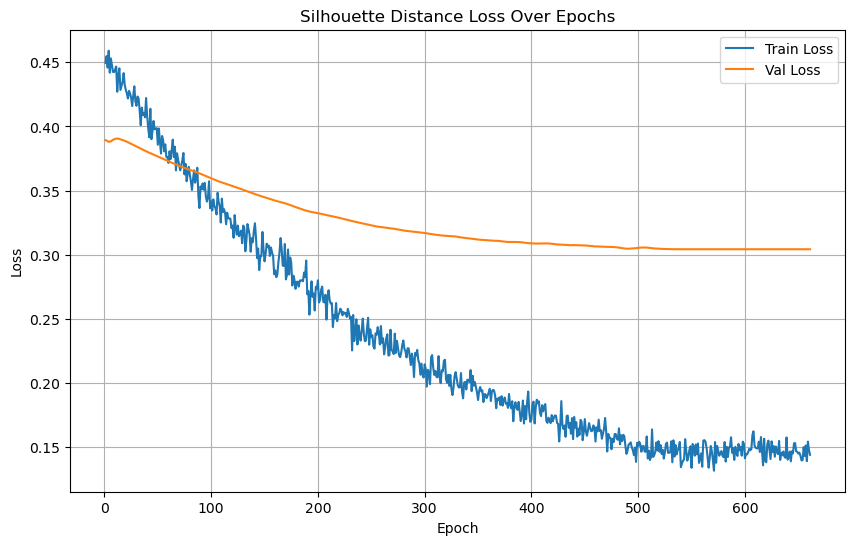

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/2314], Loss: 0.1127


Test Batch [20/2314], Loss: 0.2308
Test Batch [30/2314], Loss: 0.5000
Test Batch [40/2314], Loss: 0.1274
Test Batch [50/2314], Loss: 0.5000
Test Batch [60/2314], Loss: 0.5000


Test Batch [70/2314], Loss: 0.5000


Test Batch [80/2314], Loss: 0.2278
Test Batch [90/2314], Loss: 0.5000
Test Batch [100/2314], Loss: 0.0906
Test Batch [110/2314], Loss: 0.5000
Test Batch [120/2314], Loss: 0.1697
Test Batch [130/2314], Loss: 0.5000
Test Batch [140/2314], Loss: 0.5000


Test Batch [150/2314], Loss: 0.5000
Test Batch [160/2314], Loss: 0.1459
Test Batch [170/2314], Loss: 0.5000
Test Batch [180/2314], Loss: 0.5000
Test Batch [190/2314], Loss: 0.5000
Test Batch [200/2314], Loss: 0.2216
Test Batch [210/2314], Loss: 0.5000


Test Batch [220/2314], Loss: 0.5000
Test Batch [230/2314], Loss: 0.1225
Test Batch [240/2314], Loss: 0.0506
Test Batch [250/2314], Loss: 0.1527
Test Batch [260/2314], Loss: 0.5000
Test Batch [270/2314], Loss: 0.5000
Test Batch [280/2314], Loss: 0.5000


Test Batch [290/2314], Loss: 0.1370
Test Batch [300/2314], Loss: 0.1083
Test Batch [310/2314], Loss: 0.5000
Test Batch [320/2314], Loss: 0.1073
Test Batch [330/2314], Loss: 0.5000
Test Batch [340/2314], Loss: 0.5000
Test Batch [350/2314], Loss: 0.2543
Test Batch [360/2314], Loss: 0.1648


Test Batch [370/2314], Loss: 0.2290
Test Batch [380/2314], Loss: 0.0897
Test Batch [390/2314], Loss: 0.5000
Test Batch [400/2314], Loss: 0.5000
Test Batch [410/2314], Loss: 0.0445
Test Batch [420/2314], Loss: 0.0776
Test Batch [430/2314], Loss: 0.2048


Test Batch [440/2314], Loss: 0.5000
Test Batch [450/2314], Loss: 0.0900
Test Batch [460/2314], Loss: 0.5000
Test Batch [470/2314], Loss: 0.2087
Test Batch [480/2314], Loss: 0.5000


Test Batch [490/2314], Loss: 0.1002
Test Batch [500/2314], Loss: 0.0860
Test Batch [510/2314], Loss: 0.1067
Test Batch [520/2314], Loss: 0.0943
Test Batch [530/2314], Loss: 0.5000
Test Batch [540/2314], Loss: 0.0558
Test Batch [550/2314], Loss: 0.0724


Test Batch [560/2314], Loss: 0.5000
Test Batch [570/2314], Loss: 0.5000
Test Batch [580/2314], Loss: 0.1454
Test Batch [590/2314], Loss: 0.0573
Test Batch [600/2314], Loss: 0.5000


Test Batch [610/2314], Loss: 0.5000
Test Batch [620/2314], Loss: 0.1476
Test Batch [630/2314], Loss: 0.0229
Test Batch [640/2314], Loss: 0.1370
Test Batch [650/2314], Loss: 0.5000
Test Batch [660/2314], Loss: 0.0443


Test Batch [670/2314], Loss: 0.2056
Test Batch [680/2314], Loss: 0.5000
Test Batch [690/2314], Loss: 0.1356
Test Batch [700/2314], Loss: 0.3048
Test Batch [710/2314], Loss: 0.5000
Test Batch [720/2314], Loss: 0.5000
Test Batch [730/2314], Loss: 0.5000


Test Batch [740/2314], Loss: 0.0436
Test Batch [750/2314], Loss: 0.1604
Test Batch [760/2314], Loss: 0.0596
Test Batch [770/2314], Loss: 0.5000
Test Batch [780/2314], Loss: 0.0683
Test Batch [790/2314], Loss: 0.1404


Test Batch [800/2314], Loss: 0.1283
Test Batch [810/2314], Loss: 0.5000
Test Batch [820/2314], Loss: 0.1293
Test Batch [830/2314], Loss: 0.0679
Test Batch [840/2314], Loss: 0.5000
Test Batch [850/2314], Loss: 0.2342
Test Batch [860/2314], Loss: 0.5000


Test Batch [870/2314], Loss: 0.1436
Test Batch [880/2314], Loss: 0.0934
Test Batch [890/2314], Loss: 0.5000
Test Batch [900/2314], Loss: 0.5000
Test Batch [910/2314], Loss: 0.0654
Test Batch [920/2314], Loss: 0.5000
Test Batch [930/2314], Loss: 0.1489
Test Batch [940/2314], Loss: 0.2182


Test Batch [950/2314], Loss: 0.0663
Test Batch [960/2314], Loss: 0.0397
Test Batch [970/2314], Loss: 0.5000
Test Batch [980/2314], Loss: 0.5000
Test Batch [990/2314], Loss: 0.1808
Test Batch [1000/2314], Loss: 0.5000
Test Batch [1010/2314], Loss: 0.1791


Test Batch [1020/2314], Loss: 0.0627
Test Batch [1030/2314], Loss: 0.5000
Test Batch [1040/2314], Loss: 0.1704
Test Batch [1050/2314], Loss: 0.0583
Test Batch [1060/2314], Loss: 0.5000
Test Batch [1070/2314], Loss: 0.5000


Test Batch [1080/2314], Loss: 0.5000
Test Batch [1090/2314], Loss: 0.0421
Test Batch [1100/2314], Loss: 0.1268
Test Batch [1110/2314], Loss: 0.1786
Test Batch [1120/2314], Loss: 0.0535


Test Batch [1130/2314], Loss: 0.1550
Test Batch [1140/2314], Loss: 0.1731
Test Batch [1150/2314], Loss: 0.0419
Test Batch [1160/2314], Loss: 0.0339
Test Batch [1170/2314], Loss: 0.0250


Test Batch [1180/2314], Loss: 0.1820
Test Batch [1190/2314], Loss: 0.2624
Test Batch [1200/2314], Loss: 0.0312
Test Batch [1210/2314], Loss: 0.0638


Test Batch [1220/2314], Loss: 0.1975
Test Batch [1230/2314], Loss: 0.5000
Test Batch [1240/2314], Loss: 0.1191
Test Batch [1250/2314], Loss: 0.0174
Test Batch [1260/2314], Loss: 0.2661


Test Batch [1270/2314], Loss: 0.0781
Test Batch [1280/2314], Loss: 0.5000
Test Batch [1290/2314], Loss: 0.1178
Test Batch [1300/2314], Loss: 0.5000


Test Batch [1310/2314], Loss: 0.2694
Test Batch [1320/2314], Loss: 0.2011
Test Batch [1330/2314], Loss: 0.1616
Test Batch [1340/2314], Loss: 0.0660


Test Batch [1350/2314], Loss: 0.1968
Test Batch [1360/2314], Loss: 0.2000
Test Batch [1370/2314], Loss: 0.2011
Test Batch [1380/2314], Loss: 0.1872


Test Batch [1390/2314], Loss: 0.2034
Test Batch [1400/2314], Loss: 0.2398
Test Batch [1410/2314], Loss: 0.2138


Test Batch [1420/2314], Loss: 0.2300
Test Batch [1430/2314], Loss: 0.0162
Test Batch [1440/2314], Loss: 0.1651
Test Batch [1450/2314], Loss: 0.2163


Test Batch [1460/2314], Loss: 0.2156
Test Batch [1470/2314], Loss: 0.1715
Test Batch [1480/2314], Loss: 0.1851
Test Batch [1490/2314], Loss: 0.2055
Test Batch [1500/2314], Loss: 0.1344


Test Batch [1510/2314], Loss: 0.1879
Test Batch [1520/2314], Loss: 0.5000
Test Batch [1530/2314], Loss: 0.1831
Test Batch [1540/2314], Loss: 0.2365


Test Batch [1550/2314], Loss: 0.2473
Test Batch [1560/2314], Loss: 0.2459
Test Batch [1570/2314], Loss: 0.1815
Test Batch [1580/2314], Loss: 0.1489


Test Batch [1590/2314], Loss: 0.2783
Test Batch [1600/2314], Loss: 0.1671
Test Batch [1610/2314], Loss: 0.2812
Test Batch [1620/2314], Loss: 0.5000


Test Batch [1630/2314], Loss: 0.2528
Test Batch [1640/2314], Loss: 0.2604
Test Batch [1650/2314], Loss: 0.0789
Test Batch [1660/2314], Loss: 0.1866


Test Batch [1670/2314], Loss: 0.1999
Test Batch [1680/2314], Loss: 0.2652
Test Batch [1690/2314], Loss: 0.2217
Test Batch [1700/2314], Loss: 0.2145


Test Batch [1710/2314], Loss: 0.1738
Test Batch [1720/2314], Loss: 0.0938
Test Batch [1730/2314], Loss: 0.1471
Test Batch [1740/2314], Loss: 0.5000
Test Batch [1750/2314], Loss: 0.0600
Test Batch [1760/2314], Loss: 0.1487
Test Batch [1770/2314], Loss: 0.1245
Test Batch [1780/2314], Loss: 0.1314


Test Batch [1790/2314], Loss: 0.1248
Test Batch [1800/2314], Loss: 0.1373
Test Batch [1810/2314], Loss: 0.1542
Test Batch [1820/2314], Loss: 0.1622
Test Batch [1830/2314], Loss: 0.0274
Test Batch [1840/2314], Loss: 0.2075


Test Batch [1850/2314], Loss: 0.1669
Test Batch [1860/2314], Loss: 0.2002
Test Batch [1870/2314], Loss: 0.2025
Test Batch [1880/2314], Loss: 0.5000
Test Batch [1890/2314], Loss: 0.1856


Test Batch [1900/2314], Loss: 0.2283
Test Batch [1910/2314], Loss: 0.1937
Test Batch [1920/2314], Loss: 0.2220
Test Batch [1930/2314], Loss: 0.1755


Test Batch [1940/2314], Loss: 0.1653
Test Batch [1950/2314], Loss: 0.5000
Test Batch [1960/2314], Loss: 0.2000
Test Batch [1970/2314], Loss: 0.2184
Test Batch [1980/2314], Loss: 0.1642
Test Batch [1990/2314], Loss: 0.1363


Test Batch [2000/2314], Loss: 0.1990
Test Batch [2010/2314], Loss: 0.1346
Test Batch [2020/2314], Loss: 0.1668
Test Batch [2030/2314], Loss: 0.1482
Test Batch [2040/2314], Loss: 0.1985


Test Batch [2050/2314], Loss: 0.2243
Test Batch [2060/2314], Loss: 0.1931
Test Batch [2070/2314], Loss: 0.1508
Test Batch [2080/2314], Loss: 0.5000
Test Batch [2090/2314], Loss: 0.5000
Test Batch [2100/2314], Loss: 0.5000


Test Batch [2110/2314], Loss: 0.1717
Test Batch [2120/2314], Loss: 0.2068
Test Batch [2130/2314], Loss: 0.0900
Test Batch [2140/2314], Loss: 0.1761
Test Batch [2150/2314], Loss: 0.5000
Test Batch [2160/2314], Loss: 0.5000


Test Batch [2170/2314], Loss: 0.0202
Test Batch [2180/2314], Loss: 0.1788
Test Batch [2190/2314], Loss: 0.0527
Test Batch [2200/2314], Loss: 0.2249
Test Batch [2210/2314], Loss: 0.0344
Test Batch [2220/2314], Loss: 0.5000


Test Batch [2230/2314], Loss: 0.0375
Test Batch [2240/2314], Loss: 0.5000
Test Batch [2250/2314], Loss: 0.5000
Test Batch [2260/2314], Loss: 0.5000
Test Batch [2270/2314], Loss: 0.2390
Test Batch [2280/2314], Loss: 0.1782


Test Batch [2290/2314], Loss: 0.5000
Test Batch [2300/2314], Loss: 0.5000
Test Batch [2310/2314], Loss: 0.1116

Test Loss: 0.2544


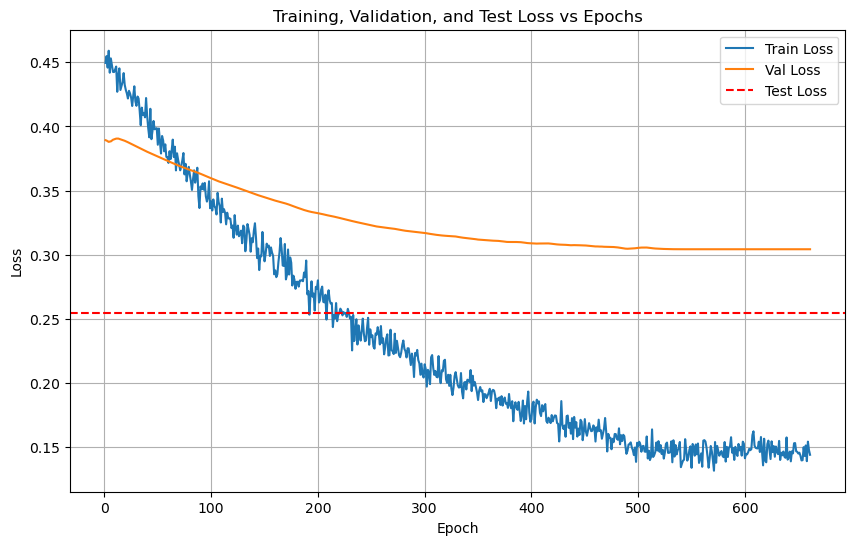

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/2314 for test dataset.
  Processed batch 20/2314 for test dataset.


  Processed batch 30/2314 for test dataset.
  Processed batch 40/2314 for test dataset.
  Processed batch 50/2314 for test dataset.
  Processed batch 60/2314 for test dataset.


  Processed batch 70/2314 for test dataset.
  Processed batch 80/2314 for test dataset.
  Processed batch 90/2314 for test dataset.
  Processed batch 100/2314 for test dataset.


  Processed batch 110/2314 for test dataset.
  Processed batch 120/2314 for test dataset.
  Processed batch 130/2314 for test dataset.
  Processed batch 140/2314 for test dataset.


  Processed batch 150/2314 for test dataset.
  Processed batch 160/2314 for test dataset.
  Processed batch 170/2314 for test dataset.
  Processed batch 180/2314 for test dataset.


  Processed batch 190/2314 for test dataset.
  Processed batch 200/2314 for test dataset.
  Processed batch 210/2314 for test dataset.


  Processed batch 220/2314 for test dataset.
  Processed batch 230/2314 for test dataset.
  Processed batch 240/2314 for test dataset.
  Processed batch 250/2314 for test dataset.


  Processed batch 260/2314 for test dataset.
  Processed batch 270/2314 for test dataset.
  Processed batch 280/2314 for test dataset.
  Processed batch 290/2314 for test dataset.


  Processed batch 300/2314 for test dataset.
  Processed batch 310/2314 for test dataset.
  Processed batch 320/2314 for test dataset.
  Processed batch 330/2314 for test dataset.


  Processed batch 340/2314 for test dataset.
  Processed batch 350/2314 for test dataset.
  Processed batch 360/2314 for test dataset.
  Processed batch 370/2314 for test dataset.


  Processed batch 380/2314 for test dataset.
  Processed batch 390/2314 for test dataset.
  Processed batch 400/2314 for test dataset.
  Processed batch 410/2314 for test dataset.


  Processed batch 420/2314 for test dataset.
  Processed batch 430/2314 for test dataset.
  Processed batch 440/2314 for test dataset.
  Processed batch 450/2314 for test dataset.


  Processed batch 460/2314 for test dataset.
  Processed batch 470/2314 for test dataset.
  Processed batch 480/2314 for test dataset.
  Processed batch 490/2314 for test dataset.


  Processed batch 500/2314 for test dataset.
  Processed batch 510/2314 for test dataset.
  Processed batch 520/2314 for test dataset.


  Processed batch 530/2314 for test dataset.
  Processed batch 540/2314 for test dataset.
  Processed batch 550/2314 for test dataset.
  Processed batch 560/2314 for test dataset.


  Processed batch 570/2314 for test dataset.
  Processed batch 580/2314 for test dataset.
  Processed batch 590/2314 for test dataset.
  Processed batch 600/2314 for test dataset.


  Processed batch 610/2314 for test dataset.
  Processed batch 620/2314 for test dataset.
  Processed batch 630/2314 for test dataset.
  Processed batch 640/2314 for test dataset.


  Processed batch 650/2314 for test dataset.
  Processed batch 660/2314 for test dataset.
  Processed batch 670/2314 for test dataset.
  Processed batch 680/2314 for test dataset.


  Processed batch 690/2314 for test dataset.
  Processed batch 700/2314 for test dataset.
  Processed batch 710/2314 for test dataset.
  Processed batch 720/2314 for test dataset.


  Processed batch 730/2314 for test dataset.
  Processed batch 740/2314 for test dataset.
  Processed batch 750/2314 for test dataset.


  Processed batch 760/2314 for test dataset.
  Processed batch 770/2314 for test dataset.
  Processed batch 780/2314 for test dataset.
  Processed batch 790/2314 for test dataset.


  Processed batch 800/2314 for test dataset.
  Processed batch 810/2314 for test dataset.
  Processed batch 820/2314 for test dataset.
  Processed batch 830/2314 for test dataset.


  Processed batch 840/2314 for test dataset.
  Processed batch 850/2314 for test dataset.
  Processed batch 860/2314 for test dataset.
  Processed batch 870/2314 for test dataset.


  Processed batch 880/2314 for test dataset.
  Processed batch 890/2314 for test dataset.
  Processed batch 900/2314 for test dataset.
  Processed batch 910/2314 for test dataset.


  Processed batch 920/2314 for test dataset.
  Processed batch 930/2314 for test dataset.
  Processed batch 940/2314 for test dataset.
  Processed batch 950/2314 for test dataset.


  Processed batch 960/2314 for test dataset.
  Processed batch 970/2314 for test dataset.
  Processed batch 980/2314 for test dataset.
  Processed batch 990/2314 for test dataset.


  Processed batch 1000/2314 for test dataset.
  Processed batch 1010/2314 for test dataset.
  Processed batch 1020/2314 for test dataset.


  Processed batch 1030/2314 for test dataset.
  Processed batch 1040/2314 for test dataset.
  Processed batch 1050/2314 for test dataset.
  Processed batch 1060/2314 for test dataset.


  Processed batch 1070/2314 for test dataset.
  Processed batch 1080/2314 for test dataset.
  Processed batch 1090/2314 for test dataset.
  Processed batch 1100/2314 for test dataset.


  Processed batch 1110/2314 for test dataset.
  Processed batch 1120/2314 for test dataset.
  Processed batch 1130/2314 for test dataset.
  Processed batch 1140/2314 for test dataset.


  Processed batch 1150/2314 for test dataset.
  Processed batch 1160/2314 for test dataset.
  Processed batch 1170/2314 for test dataset.
  Processed batch 1180/2314 for test dataset.


  Processed batch 1190/2314 for test dataset.
  Processed batch 1200/2314 for test dataset.
  Processed batch 1210/2314 for test dataset.
  Processed batch 1220/2314 for test dataset.


  Processed batch 1230/2314 for test dataset.
  Processed batch 1240/2314 for test dataset.
  Processed batch 1250/2314 for test dataset.
  Processed batch 1260/2314 for test dataset.


  Processed batch 1270/2314 for test dataset.
  Processed batch 1280/2314 for test dataset.
  Processed batch 1290/2314 for test dataset.
  Processed batch 1300/2314 for test dataset.


  Processed batch 1310/2314 for test dataset.
  Processed batch 1320/2314 for test dataset.
  Processed batch 1330/2314 for test dataset.
  Processed batch 1340/2314 for test dataset.


  Processed batch 1350/2314 for test dataset.
  Processed batch 1360/2314 for test dataset.
  Processed batch 1370/2314 for test dataset.
  Processed batch 1380/2314 for test dataset.


  Processed batch 1390/2314 for test dataset.
  Processed batch 1400/2314 for test dataset.
  Processed batch 1410/2314 for test dataset.


  Processed batch 1420/2314 for test dataset.
  Processed batch 1430/2314 for test dataset.
  Processed batch 1440/2314 for test dataset.
  Processed batch 1450/2314 for test dataset.


  Processed batch 1460/2314 for test dataset.
  Processed batch 1470/2314 for test dataset.
  Processed batch 1480/2314 for test dataset.
  Processed batch 1490/2314 for test dataset.


  Processed batch 1500/2314 for test dataset.
  Processed batch 1510/2314 for test dataset.
  Processed batch 1520/2314 for test dataset.
  Processed batch 1530/2314 for test dataset.


  Processed batch 1540/2314 for test dataset.
  Processed batch 1550/2314 for test dataset.
  Processed batch 1560/2314 for test dataset.
  Processed batch 1570/2314 for test dataset.


  Processed batch 1580/2314 for test dataset.
  Processed batch 1590/2314 for test dataset.
  Processed batch 1600/2314 for test dataset.
  Processed batch 1610/2314 for test dataset.


  Processed batch 1620/2314 for test dataset.
  Processed batch 1630/2314 for test dataset.
  Processed batch 1640/2314 for test dataset.


  Processed batch 1650/2314 for test dataset.
  Processed batch 1660/2314 for test dataset.
  Processed batch 1670/2314 for test dataset.


  Processed batch 1680/2314 for test dataset.
  Processed batch 1690/2314 for test dataset.
  Processed batch 1700/2314 for test dataset.
  Processed batch 1710/2314 for test dataset.


  Processed batch 1720/2314 for test dataset.
  Processed batch 1730/2314 for test dataset.
  Processed batch 1740/2314 for test dataset.
  Processed batch 1750/2314 for test dataset.


  Processed batch 1760/2314 for test dataset.
  Processed batch 1770/2314 for test dataset.
  Processed batch 1780/2314 for test dataset.
  Processed batch 1790/2314 for test dataset.


  Processed batch 1800/2314 for test dataset.
  Processed batch 1810/2314 for test dataset.
  Processed batch 1820/2314 for test dataset.
  Processed batch 1830/2314 for test dataset.


  Processed batch 1840/2314 for test dataset.
  Processed batch 1850/2314 for test dataset.
  Processed batch 1860/2314 for test dataset.


  Processed batch 1870/2314 for test dataset.
  Processed batch 1880/2314 for test dataset.
  Processed batch 1890/2314 for test dataset.
  Processed batch 1900/2314 for test dataset.


  Processed batch 1910/2314 for test dataset.
  Processed batch 1920/2314 for test dataset.
  Processed batch 1930/2314 for test dataset.


  Processed batch 1940/2314 for test dataset.
  Processed batch 1950/2314 for test dataset.
  Processed batch 1960/2314 for test dataset.


  Processed batch 1970/2314 for test dataset.
  Processed batch 1980/2314 for test dataset.
  Processed batch 1990/2314 for test dataset.
  Processed batch 2000/2314 for test dataset.


  Processed batch 2010/2314 for test dataset.
  Processed batch 2020/2314 for test dataset.
  Processed batch 2030/2314 for test dataset.
  Processed batch 2040/2314 for test dataset.


  Processed batch 2050/2314 for test dataset.
  Processed batch 2060/2314 for test dataset.
  Processed batch 2070/2314 for test dataset.
  Processed batch 2080/2314 for test dataset.


  Processed batch 2090/2314 for test dataset.
  Processed batch 2100/2314 for test dataset.
  Processed batch 2110/2314 for test dataset.
  Processed batch 2120/2314 for test dataset.


  Processed batch 2130/2314 for test dataset.
  Processed batch 2140/2314 for test dataset.
  Processed batch 2150/2314 for test dataset.
  Processed batch 2160/2314 for test dataset.


  Processed batch 2170/2314 for test dataset.
  Processed batch 2180/2314 for test dataset.
  Processed batch 2190/2314 for test dataset.


  Processed batch 2200/2314 for test dataset.
  Processed batch 2210/2314 for test dataset.
  Processed batch 2220/2314 for test dataset.


  Processed batch 2230/2314 for test dataset.
  Processed batch 2240/2314 for test dataset.
  Processed batch 2250/2314 for test dataset.
  Processed batch 2260/2314 for test dataset.


  Processed batch 2270/2314 for test dataset.
  Processed batch 2280/2314 for test dataset.
  Processed batch 2290/2314 for test dataset.
  Processed batch 2300/2314 for test dataset.


  Processed batch 2310/2314 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148062, 128)
Test labels shape: (148062,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 82.22%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.20      0.33         5
           2       0.56      1.00      0.71         5
           3       1.00      0.60      0.75         5
           4       0.71      1.00      0.83         5
           5       0.80      0.80      0.80         5
           6       0.80      0.80      0.80         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.82        45
   macro avg       0.87      0.82      0.80        45
weighted avg       0.87      0.82      0.80        45


LOG: Evaluating on the test set...
Test Accuracy: 91.57%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     65961
           1       0.90      0.60      0.72      7588
           2       0.44      0.83      0.57      3080
           3       0.49      0.58      0.53      2675
           4       0.67      0.92      0.78      6574
           5       0.75      0.83      0.79      9238
           6       0.83      0.83      0.83      7277
           7       0.99      0.91      0.95     42816
           8       1.00      0.98      0.99      2853

    accuracy                           0.92    148062
   macro avg       0.79      0.83      0.80    148062
weighted avg       0.93      0.92      0.92    148062

Saved SCL_SDL+LRM predictions and true labels to model_predictions


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148062, 128)
Test labels shape: (148062,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.2152  |  Val Loss: 2.1680
Validation loss improved from inf to 2.1680.
[Epoch 2/1000] Train Loss: 2.1962  |  Val Loss: 2.1537
Validation loss improved from 2.1680 to 2.1537.
[Epoch 3/1000] Train Loss: 2.1773  |  Val Loss: 2.1395
Validation loss improved from 2.1537 to 2.1395.
[Epoch 4/1000] Train Loss: 2.1585  |  Val Loss: 2.1252
Validation loss improved from 2.1395 to 2.1252.
[Epoch 5/1000] Train Loss: 2.1400  |  Val Loss: 2.1109
Validation loss improved from 2.1252 to 2.1109.
[Epoch 6/1000] Train Loss: 2.1215  |  Val Loss: 2.0967
Validation loss improved from 2.1109 to 2.0967.
[Epoch 7/1000] Train Loss: 2.1029  |  Val Loss: 2.0824
Validation loss improved from 2.0967 to 2.0824.
[Epoch 8/1000] Train Loss: 2.0843  |  Val Loss: 2.0684
Validation loss improved from 2.0824 to 2.0684.
[Epoch 9/1000] Train Loss: 2.0658  |  Val Loss: 2.0545
Validation loss improved from 2.0684 to 2.0545.
[Epoch 10/1000] Train Loss: 2.0474  |  Val Loss: 2.0407
Validation loss impr

[Epoch 54/1000] Train Loss: 1.4942  |  Val Loss: 1.6389
Validation loss improved from 1.6454 to 1.6389.
[Epoch 55/1000] Train Loss: 1.4850  |  Val Loss: 1.6324
Validation loss improved from 1.6389 to 1.6324.
[Epoch 56/1000] Train Loss: 1.4759  |  Val Loss: 1.6259
Validation loss improved from 1.6324 to 1.6259.
[Epoch 57/1000] Train Loss: 1.4668  |  Val Loss: 1.6194
Validation loss improved from 1.6259 to 1.6194.
[Epoch 58/1000] Train Loss: 1.4577  |  Val Loss: 1.6130
Validation loss improved from 1.6194 to 1.6130.
[Epoch 59/1000] Train Loss: 1.4487  |  Val Loss: 1.6065
Validation loss improved from 1.6130 to 1.6065.
[Epoch 60/1000] Train Loss: 1.4396  |  Val Loss: 1.6000
Validation loss improved from 1.6065 to 1.6000.
[Epoch 61/1000] Train Loss: 1.4307  |  Val Loss: 1.5936
Validation loss improved from 1.6000 to 1.5936.
[Epoch 62/1000] Train Loss: 1.4217  |  Val Loss: 1.5872
Validation loss improved from 1.5936 to 1.5872.
[Epoch 63/1000] Train Loss: 1.4128  |  Val Loss: 1.5808
Validati

[Epoch 75/1000] Train Loss: 1.3062  |  Val Loss: 1.5055
Validation loss improved from 1.5117 to 1.5055.
[Epoch 76/1000] Train Loss: 1.2974  |  Val Loss: 1.4992
Validation loss improved from 1.5055 to 1.4992.
[Epoch 77/1000] Train Loss: 1.2886  |  Val Loss: 1.4930
Validation loss improved from 1.4992 to 1.4930.
[Epoch 78/1000] Train Loss: 1.2797  |  Val Loss: 1.4867
Validation loss improved from 1.4930 to 1.4867.
[Epoch 79/1000] Train Loss: 1.2709  |  Val Loss: 1.4805
Validation loss improved from 1.4867 to 1.4805.
[Epoch 80/1000] Train Loss: 1.2621  |  Val Loss: 1.4741
Validation loss improved from 1.4805 to 1.4741.
[Epoch 81/1000] Train Loss: 1.2533  |  Val Loss: 1.4679
Validation loss improved from 1.4741 to 1.4679.
[Epoch 82/1000] Train Loss: 1.2446  |  Val Loss: 1.4617
Validation loss improved from 1.4679 to 1.4617.
[Epoch 83/1000] Train Loss: 1.2360  |  Val Loss: 1.4555
Validation loss improved from 1.4617 to 1.4555.
[Epoch 84/1000] Train Loss: 1.2273  |  Val Loss: 1.4493
Validati

[Epoch 126/1000] Train Loss: 0.8837  |  Val Loss: 1.2055
Validation loss improved from 1.2109 to 1.2055.
[Epoch 127/1000] Train Loss: 0.8763  |  Val Loss: 1.2001
Validation loss improved from 1.2055 to 1.2001.
[Epoch 128/1000] Train Loss: 0.8690  |  Val Loss: 1.1946
Validation loss improved from 1.2001 to 1.1946.
[Epoch 129/1000] Train Loss: 0.8617  |  Val Loss: 1.1893
Validation loss improved from 1.1946 to 1.1893.
[Epoch 130/1000] Train Loss: 0.8544  |  Val Loss: 1.1839
Validation loss improved from 1.1893 to 1.1839.
[Epoch 131/1000] Train Loss: 0.8472  |  Val Loss: 1.1786
Validation loss improved from 1.1839 to 1.1786.
[Epoch 132/1000] Train Loss: 0.8400  |  Val Loss: 1.1733
Validation loss improved from 1.1786 to 1.1733.
[Epoch 133/1000] Train Loss: 0.8329  |  Val Loss: 1.1680
Validation loss improved from 1.1733 to 1.1680.
[Epoch 134/1000] Train Loss: 0.8258  |  Val Loss: 1.1627
Validation loss improved from 1.1680 to 1.1627.
[Epoch 135/1000] Train Loss: 0.8188  |  Val Loss: 1.157

[Epoch 145/1000] Train Loss: 0.7505  |  Val Loss: 1.1059
Validation loss improved from 1.1110 to 1.1059.
[Epoch 146/1000] Train Loss: 0.7439  |  Val Loss: 1.1010
Validation loss improved from 1.1059 to 1.1010.
[Epoch 147/1000] Train Loss: 0.7374  |  Val Loss: 1.0960
Validation loss improved from 1.1010 to 1.0960.
[Epoch 148/1000] Train Loss: 0.7309  |  Val Loss: 1.0911
Validation loss improved from 1.0960 to 1.0911.
[Epoch 149/1000] Train Loss: 0.7244  |  Val Loss: 1.0862
Validation loss improved from 1.0911 to 1.0862.
[Epoch 150/1000] Train Loss: 0.7180  |  Val Loss: 1.0814
Validation loss improved from 1.0862 to 1.0814.
[Epoch 151/1000] Train Loss: 0.7116  |  Val Loss: 1.0766
Validation loss improved from 1.0814 to 1.0766.
[Epoch 152/1000] Train Loss: 0.7053  |  Val Loss: 1.0719
Validation loss improved from 1.0766 to 1.0719.
[Epoch 153/1000] Train Loss: 0.6989  |  Val Loss: 1.0671
Validation loss improved from 1.0719 to 1.0671.
[Epoch 154/1000] Train Loss: 0.6926  |  Val Loss: 1.062

[Epoch 195/1000] Train Loss: 0.4631  |  Val Loss: 0.8966
Validation loss improved from 0.8999 to 0.8966.
[Epoch 196/1000] Train Loss: 0.4584  |  Val Loss: 0.8934
Validation loss improved from 0.8966 to 0.8934.
[Epoch 197/1000] Train Loss: 0.4537  |  Val Loss: 0.8901
Validation loss improved from 0.8934 to 0.8901.
[Epoch 198/1000] Train Loss: 0.4491  |  Val Loss: 0.8869
Validation loss improved from 0.8901 to 0.8869.
[Epoch 199/1000] Train Loss: 0.4446  |  Val Loss: 0.8837
Validation loss improved from 0.8869 to 0.8837.
[Epoch 200/1000] Train Loss: 0.4401  |  Val Loss: 0.8805
Validation loss improved from 0.8837 to 0.8805.
[Epoch 201/1000] Train Loss: 0.4356  |  Val Loss: 0.8774
Validation loss improved from 0.8805 to 0.8774.
[Epoch 202/1000] Train Loss: 0.4312  |  Val Loss: 0.8743
Validation loss improved from 0.8774 to 0.8743.
[Epoch 203/1000] Train Loss: 0.4268  |  Val Loss: 0.8712
Validation loss improved from 0.8743 to 0.8712.
[Epoch 204/1000] Train Loss: 0.4225  |  Val Loss: 0.868

[Epoch 216/1000] Train Loss: 0.3731  |  Val Loss: 0.8339
Validation loss improved from 0.8366 to 0.8339.
[Epoch 217/1000] Train Loss: 0.3693  |  Val Loss: 0.8313
Validation loss improved from 0.8339 to 0.8313.
[Epoch 218/1000] Train Loss: 0.3655  |  Val Loss: 0.8287
Validation loss improved from 0.8313 to 0.8287.
[Epoch 219/1000] Train Loss: 0.3617  |  Val Loss: 0.8262
Validation loss improved from 0.8287 to 0.8262.
[Epoch 220/1000] Train Loss: 0.3580  |  Val Loss: 0.8237
Validation loss improved from 0.8262 to 0.8237.
[Epoch 221/1000] Train Loss: 0.3543  |  Val Loss: 0.8212
Validation loss improved from 0.8237 to 0.8212.
[Epoch 222/1000] Train Loss: 0.3507  |  Val Loss: 0.8187
Validation loss improved from 0.8212 to 0.8187.
[Epoch 223/1000] Train Loss: 0.3471  |  Val Loss: 0.8163
Validation loss improved from 0.8187 to 0.8163.
[Epoch 224/1000] Train Loss: 0.3435  |  Val Loss: 0.8139
Validation loss improved from 0.8163 to 0.8139.
[Epoch 225/1000] Train Loss: 0.3400  |  Val Loss: 0.811

[Epoch 269/1000] Train Loss: 0.2166  |  Val Loss: 0.7256
Validation loss improved from 0.7272 to 0.7256.
[Epoch 270/1000] Train Loss: 0.2145  |  Val Loss: 0.7240
Validation loss improved from 0.7256 to 0.7240.
[Epoch 271/1000] Train Loss: 0.2123  |  Val Loss: 0.7225
Validation loss improved from 0.7240 to 0.7225.
[Epoch 272/1000] Train Loss: 0.2102  |  Val Loss: 0.7210
Validation loss improved from 0.7225 to 0.7210.
[Epoch 273/1000] Train Loss: 0.2082  |  Val Loss: 0.7195
Validation loss improved from 0.7210 to 0.7195.
[Epoch 274/1000] Train Loss: 0.2061  |  Val Loss: 0.7180
Validation loss improved from 0.7195 to 0.7180.
[Epoch 275/1000] Train Loss: 0.2041  |  Val Loss: 0.7165
Validation loss improved from 0.7180 to 0.7165.
[Epoch 276/1000] Train Loss: 0.2021  |  Val Loss: 0.7150
Validation loss improved from 0.7165 to 0.7150.
[Epoch 277/1000] Train Loss: 0.2001  |  Val Loss: 0.7135
Validation loss improved from 0.7150 to 0.7135.
[Epoch 278/1000] Train Loss: 0.1982  |  Val Loss: 0.712

[Epoch 289/1000] Train Loss: 0.1781  |  Val Loss: 0.6973
Validation loss improved from 0.6986 to 0.6973.
[Epoch 290/1000] Train Loss: 0.1764  |  Val Loss: 0.6960
Validation loss improved from 0.6973 to 0.6960.
[Epoch 291/1000] Train Loss: 0.1747  |  Val Loss: 0.6948
Validation loss improved from 0.6960 to 0.6948.
[Epoch 292/1000] Train Loss: 0.1731  |  Val Loss: 0.6935
Validation loss improved from 0.6948 to 0.6935.
[Epoch 293/1000] Train Loss: 0.1714  |  Val Loss: 0.6923
Validation loss improved from 0.6935 to 0.6923.
[Epoch 294/1000] Train Loss: 0.1698  |  Val Loss: 0.6911
Validation loss improved from 0.6923 to 0.6911.
[Epoch 295/1000] Train Loss: 0.1682  |  Val Loss: 0.6899
Validation loss improved from 0.6911 to 0.6899.
[Epoch 296/1000] Train Loss: 0.1666  |  Val Loss: 0.6886
Validation loss improved from 0.6899 to 0.6886.
[Epoch 297/1000] Train Loss: 0.1650  |  Val Loss: 0.6874
Validation loss improved from 0.6886 to 0.6874.
[Epoch 298/1000] Train Loss: 0.1635  |  Val Loss: 0.686

[Epoch 341/1000] Train Loss: 0.1106  |  Val Loss: 0.6435
Validation loss improved from 0.6443 to 0.6435.
[Epoch 342/1000] Train Loss: 0.1097  |  Val Loss: 0.6427
Validation loss improved from 0.6435 to 0.6427.
[Epoch 343/1000] Train Loss: 0.1087  |  Val Loss: 0.6420
Validation loss improved from 0.6427 to 0.6420.
[Epoch 344/1000] Train Loss: 0.1078  |  Val Loss: 0.6412
Validation loss improved from 0.6420 to 0.6412.
[Epoch 345/1000] Train Loss: 0.1069  |  Val Loss: 0.6404
Validation loss improved from 0.6412 to 0.6404.
[Epoch 346/1000] Train Loss: 0.1060  |  Val Loss: 0.6397
Validation loss improved from 0.6404 to 0.6397.
[Epoch 347/1000] Train Loss: 0.1051  |  Val Loss: 0.6390
Validation loss improved from 0.6397 to 0.6390.
[Epoch 348/1000] Train Loss: 0.1042  |  Val Loss: 0.6382
Validation loss improved from 0.6390 to 0.6382.
[Epoch 349/1000] Train Loss: 0.1034  |  Val Loss: 0.6375
Validation loss improved from 0.6382 to 0.6375.
[Epoch 350/1000] Train Loss: 0.1025  |  Val Loss: 0.636

[Epoch 366/1000] Train Loss: 0.0900  |  Val Loss: 0.6261
Validation loss improved from 0.6268 to 0.6261.
[Epoch 367/1000] Train Loss: 0.0893  |  Val Loss: 0.6255
Validation loss improved from 0.6261 to 0.6255.
[Epoch 368/1000] Train Loss: 0.0886  |  Val Loss: 0.6249
Validation loss improved from 0.6255 to 0.6249.
[Epoch 369/1000] Train Loss: 0.0879  |  Val Loss: 0.6242
Validation loss improved from 0.6249 to 0.6242.
[Epoch 370/1000] Train Loss: 0.0872  |  Val Loss: 0.6236
Validation loss improved from 0.6242 to 0.6236.
[Epoch 371/1000] Train Loss: 0.0865  |  Val Loss: 0.6230
Validation loss improved from 0.6236 to 0.6230.
[Epoch 372/1000] Train Loss: 0.0859  |  Val Loss: 0.6224
Validation loss improved from 0.6230 to 0.6224.
[Epoch 373/1000] Train Loss: 0.0852  |  Val Loss: 0.6218
Validation loss improved from 0.6224 to 0.6218.
[Epoch 374/1000] Train Loss: 0.0845  |  Val Loss: 0.6213
Validation loss improved from 0.6218 to 0.6213.
[Epoch 375/1000] Train Loss: 0.0839  |  Val Loss: 0.620

[Epoch 415/1000] Train Loss: 0.0627  |  Val Loss: 0.6020
Validation loss improved from 0.6024 to 0.6020.
[Epoch 416/1000] Train Loss: 0.0622  |  Val Loss: 0.6016
Validation loss improved from 0.6020 to 0.6016.
[Epoch 417/1000] Train Loss: 0.0618  |  Val Loss: 0.6012
Validation loss improved from 0.6016 to 0.6012.
[Epoch 418/1000] Train Loss: 0.0614  |  Val Loss: 0.6009
Validation loss improved from 0.6012 to 0.6009.
[Epoch 419/1000] Train Loss: 0.0610  |  Val Loss: 0.6005
Validation loss improved from 0.6009 to 0.6005.
[Epoch 420/1000] Train Loss: 0.0605  |  Val Loss: 0.6002
Validation loss improved from 0.6005 to 0.6002.
[Epoch 421/1000] Train Loss: 0.0601  |  Val Loss: 0.5998
Validation loss improved from 0.6002 to 0.5998.
[Epoch 422/1000] Train Loss: 0.0597  |  Val Loss: 0.5994
Validation loss improved from 0.5998 to 0.5994.
[Epoch 423/1000] Train Loss: 0.0593  |  Val Loss: 0.5991
Validation loss improved from 0.5994 to 0.5991.
[Epoch 424/1000] Train Loss: 0.0589  |  Val Loss: 0.598

[Epoch 442/1000] Train Loss: 0.0524  |  Val Loss: 0.5932
Validation loss improved from 0.5935 to 0.5932.
[Epoch 443/1000] Train Loss: 0.0520  |  Val Loss: 0.5929
Validation loss improved from 0.5932 to 0.5929.
[Epoch 444/1000] Train Loss: 0.0517  |  Val Loss: 0.5926
Validation loss improved from 0.5929 to 0.5926.
[Epoch 445/1000] Train Loss: 0.0514  |  Val Loss: 0.5923
Validation loss improved from 0.5926 to 0.5923.
[Epoch 446/1000] Train Loss: 0.0510  |  Val Loss: 0.5921
Validation loss improved from 0.5923 to 0.5921.
[Epoch 447/1000] Train Loss: 0.0507  |  Val Loss: 0.5918
Validation loss improved from 0.5921 to 0.5918.
[Epoch 448/1000] Train Loss: 0.0504  |  Val Loss: 0.5915
Validation loss improved from 0.5918 to 0.5915.
[Epoch 449/1000] Train Loss: 0.0501  |  Val Loss: 0.5913
Validation loss improved from 0.5915 to 0.5913.
[Epoch 450/1000] Train Loss: 0.0498  |  Val Loss: 0.5910
Validation loss improved from 0.5913 to 0.5910.
[Epoch 451/1000] Train Loss: 0.0495  |  Val Loss: 0.590

[Epoch 489/1000] Train Loss: 0.0394  |  Val Loss: 0.5827
Validation loss improved from 0.5828 to 0.5827.
[Epoch 490/1000] Train Loss: 0.0392  |  Val Loss: 0.5825
Validation loss improved from 0.5827 to 0.5825.
[Epoch 491/1000] Train Loss: 0.0390  |  Val Loss: 0.5823
Validation loss improved from 0.5825 to 0.5823.
[Epoch 492/1000] Train Loss: 0.0387  |  Val Loss: 0.5821
Validation loss improved from 0.5823 to 0.5821.
[Epoch 493/1000] Train Loss: 0.0385  |  Val Loss: 0.5820
Validation loss improved from 0.5821 to 0.5820.
[Epoch 494/1000] Train Loss: 0.0383  |  Val Loss: 0.5818
Validation loss improved from 0.5820 to 0.5818.
[Epoch 495/1000] Train Loss: 0.0381  |  Val Loss: 0.5816
Validation loss improved from 0.5818 to 0.5816.
[Epoch 496/1000] Train Loss: 0.0379  |  Val Loss: 0.5815
Validation loss improved from 0.5816 to 0.5815.
[Epoch 497/1000] Train Loss: 0.0377  |  Val Loss: 0.5813
Validation loss improved from 0.5815 to 0.5813.
[Epoch 498/1000] Train Loss: 0.0375  |  Val Loss: 0.581

[Epoch 509/1000] Train Loss: 0.0353  |  Val Loss: 0.5795
Validation loss improved from 0.5796 to 0.5795.
[Epoch 510/1000] Train Loss: 0.0351  |  Val Loss: 0.5793
Validation loss improved from 0.5795 to 0.5793.
[Epoch 511/1000] Train Loss: 0.0349  |  Val Loss: 0.5792
Validation loss improved from 0.5793 to 0.5792.
[Epoch 512/1000] Train Loss: 0.0347  |  Val Loss: 0.5791
Validation loss improved from 0.5792 to 0.5791.
[Epoch 513/1000] Train Loss: 0.0345  |  Val Loss: 0.5789
Validation loss improved from 0.5791 to 0.5789.
[Epoch 514/1000] Train Loss: 0.0343  |  Val Loss: 0.5788
Validation loss improved from 0.5789 to 0.5788.
[Epoch 515/1000] Train Loss: 0.0341  |  Val Loss: 0.5787
Validation loss improved from 0.5788 to 0.5787.
[Epoch 516/1000] Train Loss: 0.0340  |  Val Loss: 0.5786
Validation loss improved from 0.5787 to 0.5786.
[Epoch 517/1000] Train Loss: 0.0338  |  Val Loss: 0.5784
Validation loss improved from 0.5786 to 0.5784.
[Epoch 518/1000] Train Loss: 0.0336  |  Val Loss: 0.578

[Epoch 560/1000] Train Loss: 0.0272  |  Val Loss: 0.5744
Validation loss improved from 0.5744 to 0.5744.
[Epoch 561/1000] Train Loss: 0.0270  |  Val Loss: 0.5743
Validation loss improved from 0.5744 to 0.5743.
[Epoch 562/1000] Train Loss: 0.0269  |  Val Loss: 0.5743
Validation loss improved from 0.5743 to 0.5743.
[Epoch 563/1000] Train Loss: 0.0268  |  Val Loss: 0.5742
Validation loss improved from 0.5743 to 0.5742.
[Epoch 564/1000] Train Loss: 0.0267  |  Val Loss: 0.5741
Validation loss improved from 0.5742 to 0.5741.
[Epoch 565/1000] Train Loss: 0.0265  |  Val Loss: 0.5741
Validation loss improved from 0.5741 to 0.5741.
[Epoch 566/1000] Train Loss: 0.0264  |  Val Loss: 0.5740
Validation loss improved from 0.5741 to 0.5740.
[Epoch 567/1000] Train Loss: 0.0263  |  Val Loss: 0.5739
Validation loss improved from 0.5740 to 0.5739.
[Epoch 568/1000] Train Loss: 0.0262  |  Val Loss: 0.5738
Validation loss improved from 0.5739 to 0.5738.
[Epoch 569/1000] Train Loss: 0.0260  |  Val Loss: 0.573

[Epoch 580/1000] Train Loss: 0.0247  |  Val Loss: 0.5732
Validation loss improved from 0.5732 to 0.5732.
[Epoch 581/1000] Train Loss: 0.0246  |  Val Loss: 0.5731
Validation loss improved from 0.5732 to 0.5731.
[Epoch 582/1000] Train Loss: 0.0245  |  Val Loss: 0.5731
Validation loss improved from 0.5731 to 0.5731.
[Epoch 583/1000] Train Loss: 0.0244  |  Val Loss: 0.5730
Validation loss improved from 0.5731 to 0.5730.
[Epoch 584/1000] Train Loss: 0.0243  |  Val Loss: 0.5730
Validation loss improved from 0.5730 to 0.5730.
[Epoch 585/1000] Train Loss: 0.0242  |  Val Loss: 0.5729
Validation loss improved from 0.5730 to 0.5729.
[Epoch 586/1000] Train Loss: 0.0240  |  Val Loss: 0.5729
Validation loss improved from 0.5729 to 0.5729.
[Epoch 587/1000] Train Loss: 0.0239  |  Val Loss: 0.5728
Validation loss improved from 0.5729 to 0.5728.
[Epoch 588/1000] Train Loss: 0.0238  |  Val Loss: 0.5728
Validation loss improved from 0.5728 to 0.5728.
[Epoch 589/1000] Train Loss: 0.0237  |  Val Loss: 0.572

[Epoch 638/1000] Train Loss: 0.0192  |  Val Loss: 0.5715
Validation loss improved from 0.5715 to 0.5715.
[Epoch 639/1000] Train Loss: 0.0191  |  Val Loss: 0.5714
Validation loss improved from 0.5715 to 0.5714.
[Epoch 640/1000] Train Loss: 0.0190  |  Val Loss: 0.5714
Validation loss improved from 0.5714 to 0.5714.
[Epoch 641/1000] Train Loss: 0.0189  |  Val Loss: 0.5714
Validation loss improved from 0.5714 to 0.5714.
[Epoch 642/1000] Train Loss: 0.0189  |  Val Loss: 0.5714
Validation loss improved from 0.5714 to 0.5714.
[Epoch 643/1000] Train Loss: 0.0188  |  Val Loss: 0.5714
Validation loss improved from 0.5714 to 0.5714.
[Epoch 644/1000] Train Loss: 0.0187  |  Val Loss: 0.5714
Validation loss improved from 0.5714 to 0.5714.
[Epoch 645/1000] Train Loss: 0.0186  |  Val Loss: 0.5714
Validation loss improved from 0.5714 to 0.5714.
[Epoch 646/1000] Train Loss: 0.0185  |  Val Loss: 0.5714
Validation loss improved from 0.5714 to 0.5714.
[Epoch 647/1000] Train Loss: 0.0185  |  Val Loss: 0.571

[Epoch 654/1000] Train Loss: 0.0179  |  Val Loss: 0.5714
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 655/1000] Train Loss: 0.0179  |  Val Loss: 0.5713
Validation loss improved from 0.5713 to 0.5713.
[Epoch 656/1000] Train Loss: 0.0178  |  Val Loss: 0.5713
Validation loss improved from 0.5713 to 0.5713.
[Epoch 657/1000] Train Loss: 0.0177  |  Val Loss: 0.5713
Validation loss improved from 0.5713 to 0.5713.
[Epoch 658/1000] Train Loss: 0.0177  |  Val Loss: 0.5713
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 659/1000] Train Loss: 0.0176  |  Val Loss: 0.5714
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 660/1000] Train Loss: 0.0175  |  Val Loss: 0.5714
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 661/1000] Train Loss: 0.0174  |  Val Loss: 0.5714
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 662/1000] Train Loss: 0.0174  |  Val Loss: 0.5713
Validation loss improved from 0.5713 to 0.5713.
[Epoch 663/1000] Train Lo

[Epoch 712/1000] Train Loss: 0.0143  |  Val Loss: 0.5716
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 713/1000] Train Loss: 0.0143  |  Val Loss: 0.5716
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 714/1000] Train Loss: 0.0142  |  Val Loss: 0.5716
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 715/1000] Train Loss: 0.0142  |  Val Loss: 0.5716
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 716/1000] Train Loss: 0.0141  |  Val Loss: 0.5716
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 717/1000] Train Loss: 0.0140  |  Val Loss: 0.5716
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 718/1000] Train Loss: 0.0140  |  Val Loss: 0.5716
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 719/1000] Train Loss: 0.0139  |  Val Loss: 0.5716
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 720/1000] Train Loss: 0.0139  |  Val Loss: 0.5717
!! Validation loss did NOT improve !! Patience:

[Epoch 733/1000] Train Loss: 0.0133  |  Val Loss: 0.5718
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 734/1000] Train Loss: 0.0132  |  Val Loss: 0.5718
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 735/1000] Train Loss: 0.0132  |  Val Loss: 0.5719
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 736/1000] Train Loss: 0.0131  |  Val Loss: 0.5719
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 737/1000] Train Loss: 0.0131  |  Val Loss: 0.5719
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 738/1000] Train Loss: 0.0130  |  Val Loss: 0.5719
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 739/1000] Train Loss: 0.0130  |  Val Loss: 0.5719
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 740/1000] Train Loss: 0.0129  |  Val Loss: 0.5719
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 741/1000] Train Loss: 0.0129  |  Val Loss: 0.5720
!! Validation loss did NOT improve !! Patience:

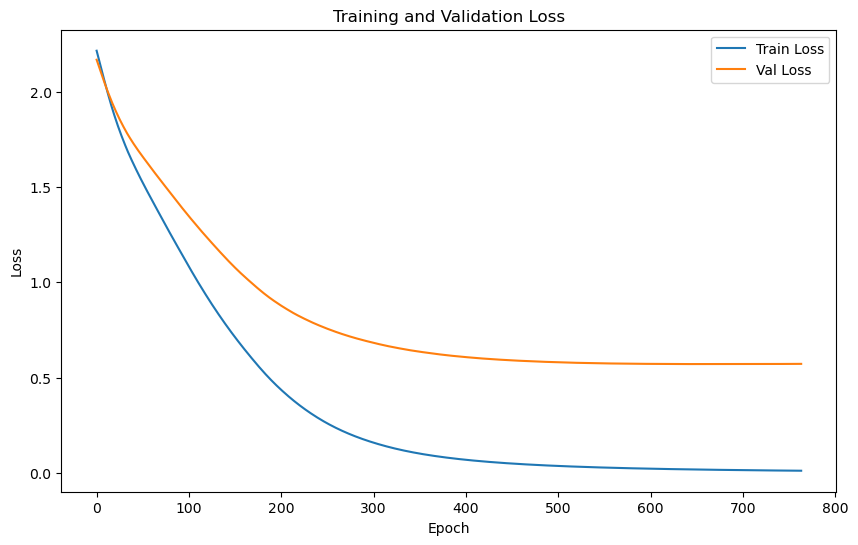

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.2522 | Test Accuracy: 93.00%


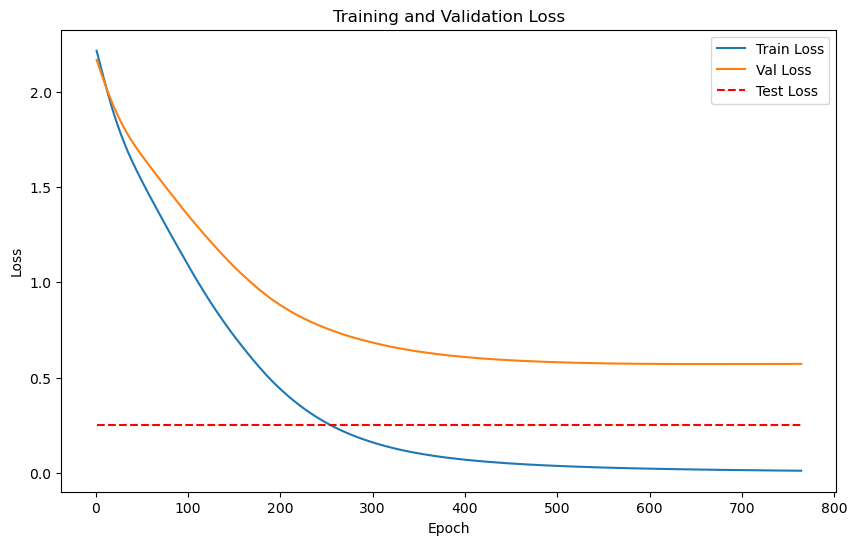

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


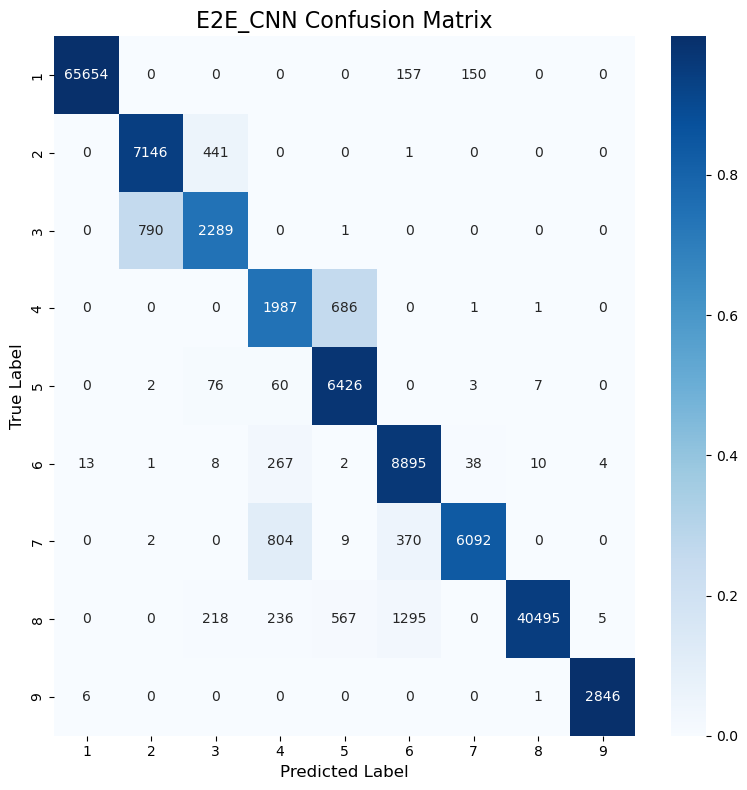

Classification Accuracy: 95.79%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


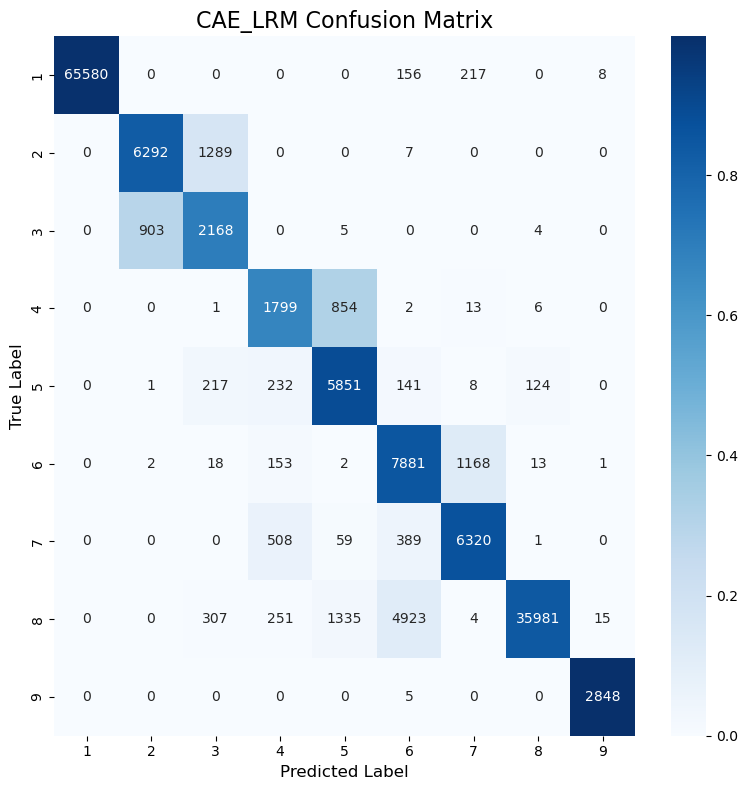

Classification Accuracy: 90.99%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


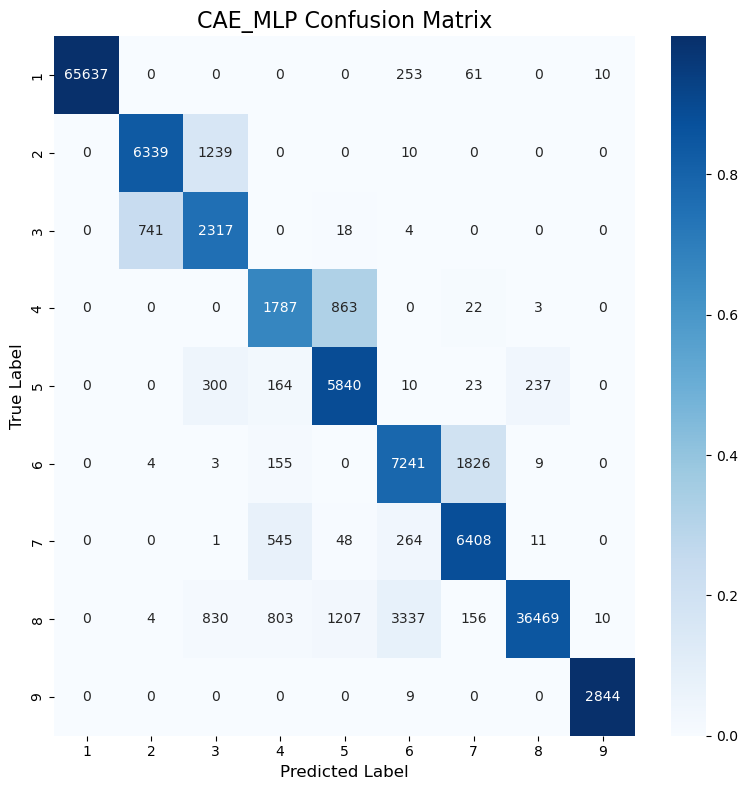

Classification Accuracy: 91.10%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


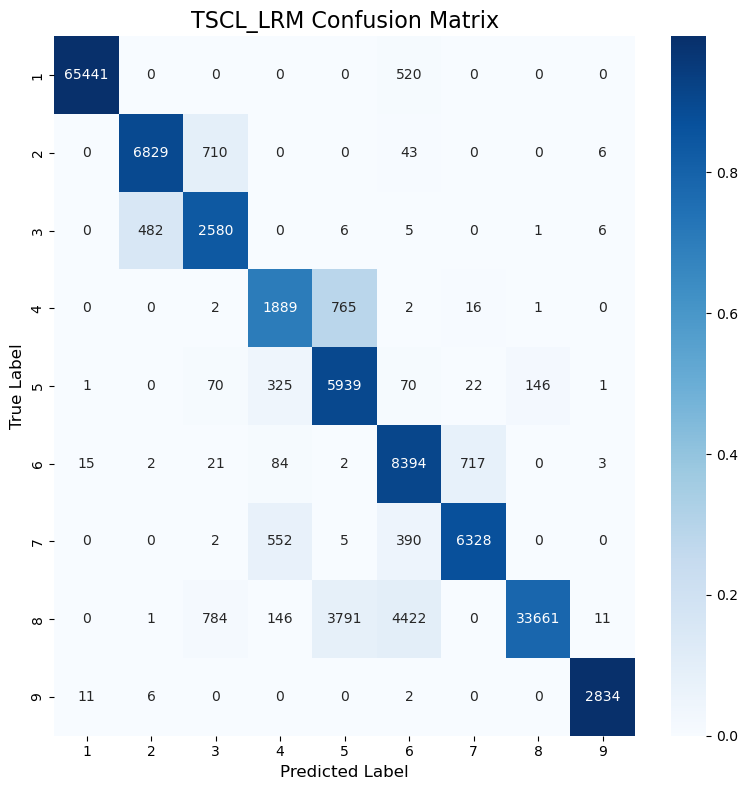

Classification Accuracy: 90.43%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


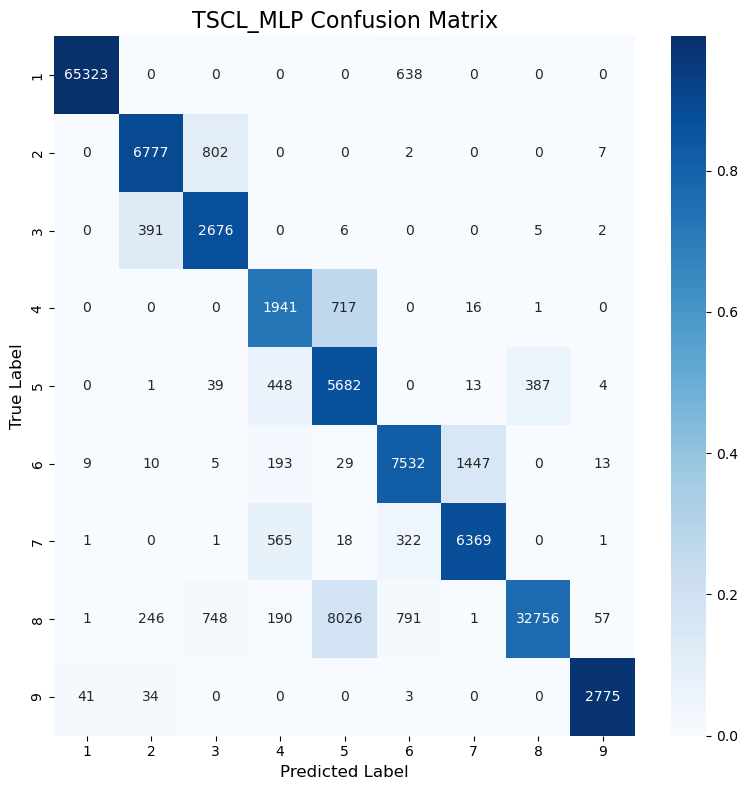

Classification Accuracy: 89.04%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


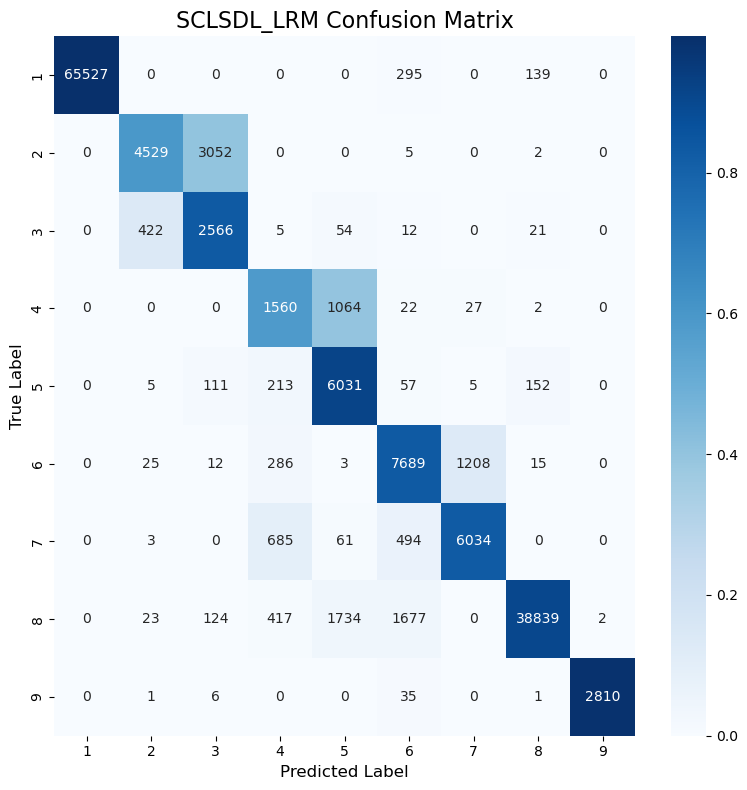

Classification Accuracy: 91.57%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


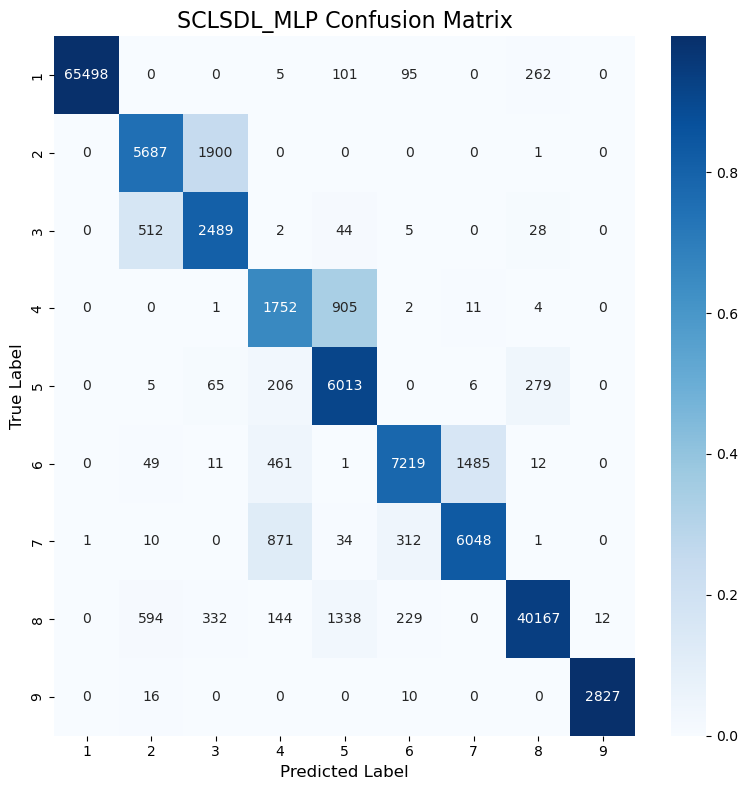

Classification Accuracy: 93.00%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          95.79
1    LRM (CAE)          90.99
2    MLP (CAE)          91.10
3     TSCL LRM          90.43
4     TSCL MLP          89.04
5  SCL_SDL LRM          91.57
6  SCL_SDL MLP          93.00

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          95.79
6  SCL_SDL MLP          93.00
5  SCL_SDL LRM          91.57
2    MLP (CAE)          91.10
1    LRM (CAE)          90.99
3     TSCL LRM          90.43
4     TSCL MLP          89.04
